# ЗАДАЧА
В приложенных файлах вы увидите данные по прохождению студентами тестов на образовательной платформе. Такие данные могут быть использованы для построения персонализированных ИИ-ассистентов для поддержки обучения студента. На текущем этапе сосредоточимся на начальном этапе — сборе и подготовке данных.

**ВАМ НЕОБХОДИМО:**
Используя библиотеку pandas (или аналоги), проанализировать как можно больше характеристик, влияющих на успеваемость студентов.

# Решение

## 1. Импорт библиотек и написание функций 

In [1]:
# импортируем необходмые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# настройка визуализации
%matplotlib inline
plt.style.use('seaborn-v0_8')
%config InlineBackend.figure_format = "retina"

### Функции:

In [2]:
def df_info(df):
    """
    Функция принимает на вход датафрейм и выводит информацию о нем:
    общая информация, размерность, пропущенные значения, уникальные значения.
    Args:
        df: датафрейм для анализа
    """
    # вывод общей информации
    print("--- Общая информация ---\n")
    display(df)
    display(df.info())
    # вывод размерности
    print("--- Размерность ---")
    display(df.shape)
    # вывод числа пропущенных значений
    print("--- Число пропущенных значений ---")
    display(df.isna().sum())
    # вывод числа уникальных значений
    print("--- Число уникальных значений в признаках ---")
    display(df.nunique())
    

## 2. Загрузка данных

### 2.1. TRAIN.CSV

In [3]:
# загрузим данные train.csv
train = pd.read_csv("data/train.csv")
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


- `row_id`: (**int64**) ID code for the row.    
ID строки.
- `timestamp`: (**int64**) the time in milliseconds between this user interaction and the first event completion from that user.    
Время в миллисекундах между этим взаимодействием с пользователем и первым завершением события от этого пользователя.
- `user_id`: (**int32**) ID code for the user.    
ID пользователя.
- `content_id`: (**int16**) ID code for the user interaction.    
ID взаимодействия с пользователем.
- `content_type_id`: (**int8**) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.    
0, если событием был вопрос, заданный пользователю, 1, если событием был просмотр лекции.
- `task_container_id`: (**int16**) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a *task_container_id*.    
ID партии вопросов или лекций. Например, пользователь может просмотреть три вопроса подряд, прежде чем увидит объяснения к ним. Все эти три вопроса будут иметь общий идентификатор *task_container_id*.
- `user_answer`: (**int8**) the user's answer to the question, if any. Read -1 as null, for lectures.    
Ответ пользователя на вопрос, если таковой имеется. Зачитывайте -1 как null, для лекций.
- `answered_correctly`: (**int8**) if the user responded correctly. Read -1 as null, for lectures.    
Если пользователь ответил правильно. Зачитывайте -1 как null, для лекций.
- `prior_question_elapsed_time`: (**float32**) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.    
Среднее время в миллисекундах, которое потребовалось пользователю, чтобы ответить на каждый вопрос в предыдущем пакете вопросов, без учета всех лекций между ними. Является null для первого пакета вопросов или лекции пользователя. Обратите внимание, что время - это среднее время, затраченное пользователем на решение каждого вопроса в предыдущем пакете.
- `prior_question_had_explanation`: (**bool**) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.    
Увидел ли пользователь объяснение и правильный ответ (ответы) после ответа на предыдущий пакет вопросов, игнорируя все лекции между ними. Значение разделяется на один пакет вопросов и является нулевым для первого пакета вопросов или лекции пользователя. Как правило, первые несколько вопросов, которые видит пользователь, были частью диагностического теста при входе в систему, где он не получил никакой обратной связи.

### 2.2. QUESTIONS.CSV: METADATA FOR THE QUESTIONS POSED TO USERS.
Метаданные для вопросов, задаваемых пользователям.

In [4]:
# загрузим данные questions.csv
questions = pd.read_csv("data/questions.csv")
questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


- `question_id`: foreign key for the **train/test** *content_id* column, when the content type is question (0).    
Внешний ключ для столбца *content_id*, когда тип содержимого - вопрос (0).
- `bundle_id`: code for which questions are served together.     
Код, по которому вопросы подаются вместе.
- `correct_answer`: the answer to the question. Can be compared with the train user_answer column to check if the user was right.    
Ответ на вопрос. Можно сравнить с колонкой **train** *user_answer*, чтобы проверить, правильно ли ответил пользователь.
- `part`: the relevant section of the TOEIC test.     
Cоответствующий раздел теста TOEIC.
- `tags`: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.     
Один или несколько подробных кодов тегов для вопроса. Смысл тегов не сообщается, но этих кодов достаточно для объединения вопросов в кластеры.

### 2.3. LECTURES.CSV: METADATA FOR THE LECTURES WATCHED BY USERS AS THEY PROGRESS IN THEIR EDUCATION.
Метаданные для лекций, просматриваемых пользователями по мере их обучения.

In [5]:
# загрузим данные lectures.csv
lectures = pd.read_csv("data/lectures.csv")
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


- `lecture_id`: foreign key for the train/test *content_id column*, when the content type is lecture (1).    
Внешний ключ для столбца **train/test** *content_id*, когда тип контента - лекция (1).
- `part`: top level category code for the lecture.    
Код категории верхнего уровня для лекции.
- `tag`: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.    
Один код тега для лекции. Смысл тегов не приводится, но этих кодов достаточно для группировки лекций.
- `type_of`: brief description of the core purpose of the lecture.    
Краткое описание основной цели лекции.

## 3. Предварительный анализ и очистка

### 3.1. TRAIN.CSV

In [6]:
# выведем информацию по train.csv
df_info(train)

--- Общая информация ---



,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False
...,...,...,...,...,...,...,...,...,...,...
101230327,101230327,428564420,2147482888,3586,0,22,0,1,18000.0,True
101230328,101230328,428585000,2147482888,6341,0,23,3,1,14000.0,True
101230329,101230329,428613475,2147482888,4212,0,24,3,1,14000.0,True
101230330,101230330,428649406,2147482888,6343,0,25,1,0,22000.0,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int64  
 4   content_type_id                 int64  
 5   task_container_id               int64  
 6   user_answer                     int64  
 7   answered_correctly              int64  
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  object 
dtypes: float64(1), int64(8), object(1)
memory usage: 7.5+ GB


None

--- Размерность ---


(101230332, 10)

--- Число пропущенных значений ---


row_id                                  0
timestamp                               0
user_id                                 0
content_id                              0
content_type_id                         0
task_container_id                       0
user_answer                             0
answered_correctly                      0
prior_question_elapsed_time       2351538
prior_question_had_explanation     392506
dtype: int64

--- Число уникальных значений в признаках ---


row_id                            101230332
timestamp                          72821015
user_id                              393656
content_id                            13782
content_type_id                           2
task_container_id                     10000
user_answer                               5
answered_correctly                        3
prior_question_elapsed_time            3258
prior_question_had_explanation            2
dtype: int64

#### 3.1.1. Сдвигаем значения столбцов 

Признаки `prior_question_elapsed_time` и `prior_question_had_explanation` имеют значения, касательно предыдущего пакета вопросов, без учета лекций между ними. Первые значения в разрезе `user_id`- это, соотвественно, `NaN`. Поэтому необходимо сдвинуть значения этих двух признаков на одно значение вверх, чтобы привести датасет к соответствию.

In [7]:
# сдвигаем значения последних 2-х признаков на 1 значение вверх
train["prior_question_elapsed_time"] = train["prior_question_elapsed_time"].shift(-1)
train["prior_question_had_explanation"] = train["prior_question_had_explanation"].shift(-1)

#### 3.1.2. Анализ пропущенных значениий и дубликатов

In [8]:
# расчитаем долю пропусков в столбце prior_question_elapsed_time
nan_prior_question_elapsed_time = train["prior_question_elapsed_time"].isna().sum() / len(train) * 100
# расчитаем долю пропусков в столбце prior_question_had_explanation
nan_prior_question_had_explanation = train["prior_question_had_explanation"].isna().sum() / len(train) * 100

# выведем полученные данные
print(f"Доля NaN в признаке *prior_question_elapsed_time* = {nan_prior_question_elapsed_time:.2f} %")
print(f"Доля NaN в признаке *prior_question_had_explanation* = {nan_prior_question_had_explanation:.2f} %")

Доля NaN в признаке *prior_question_elapsed_time* = 2.32 %
Доля NaN в признаке *prior_question_had_explanation* = 0.39 %


Теперь узнаем, совпадают ли пропуски в обоих столбцах или нет.

In [9]:
# маска пропущенных значений в признаке prior_question_elapsed_time
nan_mask_1 = train["prior_question_elapsed_time"].isnull()
# маска пропущенных значений в признаке prior_question_had_explanation
nan_mask_2 = train["prior_question_had_explanation"].isnull()

# выведем число строк, в которых пропуски в обоих столбцах
train[nan_mask_1 & nan_mask_2].shape[0]

392506

Да, совпадают. Строки с пропущенными значениями в `prior_question_had_explanation` имеют обязательно пропуски в `prior_question_elapsed_time`, причем пропусков в последнем признаке значительно больше.

Узнаем сколько у нас уникальных `user_id`  

In [10]:
# количество уникальных значений признака user_id
train.user_id.nunique()

393656

Выведем дубликаты.

In [11]:
# выведем дубликаты строк
train[train.duplicated()]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation


#### 3.1.3. **Выводы:**
- размер датасета достаточно большой: `(101230332, 10)`
- преимущественный тип данных - `int64`, а также
    - **prior_question_elapsed_time** - `float64`
    - **prior_question_had_explanation** - `object`, при этом имеются только 2 уникальных значения - `True` и `False`.
- значения признаков `prior_question_elapsed_time` и `prior_question_had_explanation` смещены вниз на 1 строку,т.к. относятся к предыдущему пакету вопросов. Мы сместили их вверх на 1 строку.
- признак `row_id` дублирует индексы, но пока его удалять не будем.
- в признаках `prior_question_elapsed_time` и `prior_question_had_explanation` имеются пропущенные значения: `2351538` и `392506` соответственно. При этом число уникальный пользователей, т.е. количество уникальных значений `user_id` равно `393656`. При этом мы знаем, что для первого пакета данных пользователя (вопрос или лекция) значение обоих признаков будет `NaN`. Мы также выяснили, что пропущенным значениям в признаке `prior_question_had_explanation` обязательно соответствуют пропущенные значения в признаке `prior_question_elapsed_time`. Зная число уникальных пользователей, мы можем сказать, что число пропущенных значений в признаках `prior_question_elapsed_time` и `prior_question_had_explanation` должно быть равно `393656` в каждом, однако это не так. Причем для последнего признака разница относительно небольшая (пропусков меньше, чем кол-во пользователей на 1000 с небольшим), а вот в предпоследнем признаке пропусков значительно больше, чем кол-во пользователей.
- вероятной причиной, описанных в предыдущем пункте аномалий, скорее всего является то, что в данных присутствует "мусор", т.е. ошибки полученные при сборе, хранении либо группировке данных. Нормальное количество `NaN` в обоих признаках, по идее, должно быть `393656`, остальное - "мусор". 
- возможные дальнейшие стратегии по исследованю пропусков:
    - разделить "нормальные" пропуски и "мусорные", оставив первые и исследовав и, скорее всего, удалив последние
    - не тратить время и удалить все строки с пропусками, т.к. их доля крайне мала, по сравнению с общим объемом данных и врядли мы получим ценные данные даже из "нормальных" пропусков (их доля будет менее 0.4% от общего объема датасета)
    - можно заполнить пропуски средним или медианным значением по столбцу либо в разрезе `user_id`
- окончательная стратегия по пропускам - удаление
- Дубликатов нет, НО(!) **интересный момент** - если колонки не сдвигать, то будет найдено `135` дубликатов, до `14` дубликатов на 1 ползователя. 
- признаки `content_type_id`, `user_answer`, `answered_correctly`, `prior_question_had_explanation` - категориальные

In [12]:
# удаляем строки с пропусками
train.dropna(inplace=True)

### 3.2. QUESTIONS.CSV

In [13]:
df_info(questions)

--- Общая информация ---



,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
...,...,...,...,...,...
13518,13518,13518,3,5,14
13519,13519,13519,3,5,8
13520,13520,13520,2,5,73
13521,13521,13521,0,5,125


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


None

--- Размерность ---


(13523, 5)

--- Число пропущенных значений ---


question_id       0
bundle_id         0
correct_answer    0
part              0
tags              1
dtype: int64

--- Число уникальных значений в признаках ---


question_id       13523
bundle_id          9765
correct_answer        4
part                  7
tags               1519
dtype: int64

#### 3.2.1. Анализ пропущенных значений

В признаке `tags` есть пропуск. Выведем его.

In [14]:
# выведем строку с пропуском 
questions[questions.isna().any(axis=1)]

,question_id,bundle_id,correct_answer,part,tags
10033,10033,10033,2,6,NaN


Мы видим значение `question_id` в строке с пропуском которое равно `10033`. Посмотрим, есть ли еще такие вопросы в таблице.

In [15]:
# отфильтруем таблицу по question_id = 10033
questions[questions["question_id"] == 10033]

,question_id,bundle_id,correct_answer,part,tags
10033,10033,10033,2,6,NaN


Только отдна строка. Сделаем тоже, для `bundle_id` = `10033` (на всякий случай).

In [16]:
questions[questions["bundle_id"] == 10033]

,question_id,bundle_id,correct_answer,part,tags
10033,10033,10033,2,6,NaN


Та же строка. Теперь зная, что `question_id` - это внешний ключ для `content_id` таблицы `train`, отфильтруем `train` по этому ключу.

In [17]:
# отфильтруем таблицу train по content_id = 10033
train[train["content_id"] == 10033]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
62750278,62750278,1286282597,1333688829,10033,0,1127,2,1,1250.0,False


Отлично,  только одна строка.

Теперь удалим строку с пропуском в таблице `questions` и связанную с ней по ключу строку в таблице `train`, иначе, там появится `NaN` при объединении таблиц.

In [18]:
# удаляем строки с пропусками в questions
questions.dropna(inplace=True)

# получаем индекс строки для удаления в train
index_name = train[train["content_id"] == 10033].index 
# удаляем строку по полученному индексу
train.drop(index_name, inplace = True)

#### 3.2.2. Поиск дубликатов

In [19]:
questions[questions.duplicated()]

,question_id,bundle_id,correct_answer,part,tags


Дубликатов нет.

#### 3.2.3. Анализ признака `tags`

In [20]:
# узнаем количество уникальных значений в признаке в порядке убывания
questions.tags.value_counts(ascending=False)

tags
8                 738
73                617
53                523
1                 413
96                373
                 ... 
157 144 81          1
157 144 38          1
106 169 162 81      1
157 169 162 81      1
157 169 92          1
Name: count, Length: 1519, dtype: int64

Уникальных значений признака `1519`, но мы видим, что в тегах может быть несколько значений, что искажает общую картину. 

Узнаем число значений признака `tags`, разбив каждое значение (т.е. тип **str**) на составляющие и узнаем их количество в каждой строке.

In [21]:
# разбиваем str каждого значения tags по пробелам и вычисляем длину полученного списка
tag_len = questions["tags"].apply(lambda x: len(x.split(" ")))
# изучим количество каждого уникального значения длины (кол-ва цифр) признака
tag_len.value_counts(ascending=False, normalize=True)

tags
1    0.485135
3    0.294039
4    0.149460
5    0.050732
2    0.012646
6    0.007987
Name: proportion, dtype: float64

#### 3.2.4. Выводы

- размерность датасета `(13523, 5)`
- дубликатов нет
- есть одно пропущенное значение в признаке `tags`, удалена строка с пропуском и связанная с ним строка в датасете `train`
- признак `tags` содержит теги в виде чисел, при этом значением признака в 48.5% является 1 число (тег), в 29% 3 числа, в 15% 4 числа и в 5% и менее - 5,2,6 чисел. Смысловые значения тегов нам неизвестны, известно только, что они используются для объединения вопросов в кластеры.
- признаки `correct_answer`, `part`, `tags` - категориальные.

### 3.3. LECTURES.CSV

In [22]:
df_info(lectures)

--- Общая информация ---



,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question
...,...,...,...,...
413,32535,8,5,solving question
414,32570,113,3,solving question
415,32604,24,6,concept
416,32625,142,2,concept


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


None

--- Размерность ---


(418, 4)

--- Число пропущенных значений ---


lecture_id    0
tag           0
part          0
type_of       0
dtype: int64

--- Число уникальных значений в признаках ---


lecture_id    418
tag           151
part            7
type_of         4
dtype: int64

In [23]:
# ищем дубликаты
lectures[lectures.duplicated()]

,lecture_id,tag,part,type_of


#### 3.3.1. Выводы

- датасет небольшой, размерность `(418, 4)`
- пропусков и дубликатов нет
- признак `tag` используется для группировок лекций, но точного смысла его значений мы не знаем. В отличие от схожего признака `tags` в предыдущей таблице `questions`, значения признака `tag` в таблице `lections` представлены изначально числами (по 1 числу)
- признаки `tag`, `part`, `type_of` - категориальные

### 3.4. Сведение данных из трех исходных таблиц в один общий датасет

Соединим `train` отфильтрованный по `content_type_id` = 0 ("вопрос") с таблицей вопросов `questions` по ключевым столбцам `content_id` и `question_id` соответственно.

In [24]:
# маска для фильтрации по "вопросам"
mask = train["content_type_id"] == 0
# объединяем отфильтрованный train с questions
train_q = pd.merge(
    train[mask], 
    questions,
    # ключевые столбцы train и questions соответственно
    left_on="content_id", right_on="question_id", 
    how="left"
    ).rename(columns={ # переименовывваем присоединенные столбцы добавив префикс "q_"
    "bundle_id":"q_bundle_id",
    "correct_answer":"q_correct_answer",
    "part":"q_part",
    "tags":"q_tags"
    })


Соединим `train` отфильтрованный по `content_type_id` = 1 ("лекция") с таблицей лекций `lectures` по ключевым столбцам `content_id` и `lrcture_id` соответственно.

In [25]:
# маска для фильтрации по "лекциям"
mask = train["content_type_id"] == 1
# объединяем отфильтрованный train с lectures
train_l = pd.merge(
    train[mask], 
    lectures, 
    # ключевые столбцы train и lectures соответственно
    left_on="content_id", right_on="lecture_id", 
    how="left").rename(columns={ # переименовывваем присоединенные столбцы добавив префикс "l_"
    "tag":"l_tag",
    "part":"l_part",
    "type_of":"l_type_of"
    })

Собираем итоговый датафрейм из двух таблиц, созданных выше, сортируя данные по `row_id`, как в исходной таблице (хотя, вроде как это необязательно, в итоговой таблице строки будут идти в том же порядке, что и в исходной таблице за вычетом строк с пропусками, которые мы удалили выше).

In [26]:
train_final = pd.merge(
    train_q,
    train_l,
    how="outer"
).sort_values(by="row_id", ascending=True)

Теперь удалим ненужные признаки:
- `row_id` - этот признак соответствует индексам исходной таблицы
- `question_id` и `lecture_id` - это внешние ключи для `content_id`
- `q_bundle_id` - соответствует `question_id`

In [27]:
# признаки для удаления
cols_for_del = ["row_id","question_id","lecture_id", "q_bundle_id"]

# удаляем выбранные признаки
train_final.drop(cols_for_del, axis=1, inplace=True)

Сохраним полученную таблицу в файл.

In [28]:
train_final.to_csv("data/train_final.csv", encoding='utf-8', index=False)

## 4. EDA

In [3]:
# загрузим итоговый датасет
df = pd.read_csv("data/train_final.csv")

In [4]:
df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,q_correct_answer,q_part,q_tags,l_tag,l_part,l_type_of
0,0,115,5692,0,1,3,1,37000.0,False,3.0,5.0,151,NaN,NaN,NaN
1,56943,115,5716,0,2,2,1,55000.0,False,2.0,5.0,168,NaN,NaN,NaN
2,118363,115,128,0,0,0,1,19000.0,False,0.0,1.0,131 149 92,NaN,NaN,NaN
3,131167,115,7860,0,3,0,1,11000.0,False,0.0,1.0,131 104 81,NaN,NaN,NaN
4,137965,115,7922,0,4,1,1,5000.0,False,1.0,1.0,131 149 92,NaN,NaN,NaN


- `timestamp`: (**int64**) the time in milliseconds between this user interaction and the first event completion from that user.    
Время в миллисекундах между этим взаимодействием с пользователем и первым завершением события от этого пользователя.
- `user_id`: (**int32**) ID code for the user.    
ID пользователя.
- `content_id`: (**int16**) ID code for the user interaction.    
ID взаимодействия с пользователем.
- `content_type_id`: (**int8**) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.    
0, если событием был вопрос, заданный пользователю, 1, если событием был просмотр лекции.
- `task_container_id`: (**int16**) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a *task_container_id*.    
ID партии вопросов или лекций. Например, пользователь может просмотреть три вопроса подряд, прежде чем увидит объяснения к ним. Все эти три вопроса будут иметь общий идентификатор *task_container_id*.
- `user_answer`: (**int8**) the user's answer to the question, if any. Read -1 as null, for lectures.    
Ответ пользователя на вопрос, если таковой имеется. Зачитывайте -1 как null, для лекций.
- `answered_correctly`: (**int8**) if the user responded correctly. Read -1 as null, for lectures.    
Если пользователь ответил правильно. Зачитывайте -1 как null, для лекций.
- `prior_question_elapsed_time`: (**float32**) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.    
Среднее время в миллисекундах, которое потребовалось пользователю, чтобы ответить на каждый вопрос в предыдущем пакете вопросов, без учета всех лекций между ними. Является null для первого пакета вопросов или лекции пользователя. Обратите внимание, что время - это среднее время, затраченное пользователем на решение каждого вопроса в предыдущем пакете. **Примечание: колонки были сдвинуты и и данный признак соответствует текущему вопросу**
- `prior_question_had_explanation`: (**bool**) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.    
Увидел ли пользователь объяснение и правильный ответ (ответы) после ответа на предыдущий пакет вопросов, игнорируя все лекции между ними. Значение разделяется на один пакет вопросов и является нулевым для первого пакета вопросов или лекции пользователя. Как правило, первые несколько вопросов, которые видит пользователь, были частью диагностического теста при входе в систему, где он не получил никакой обратной связи.    
**Примечание: колонки были сдвинуты и и данный признак соответствует текущему вопросу**
-
-
- `q_correct_answer`: the answer to the question. Can be compared with the train user_answer column to check if the user was right.    
Ответ на вопрос. Можно сравнить с колонкой **train** *user_answer*, чтобы проверить, правильно ли ответил пользователь.
- `q_part`: the relevant section of the TOEIC test.     
Cоответствующий раздел теста TOEIC.
- `q_tags`: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.     
Один или несколько подробных кодов тегов для вопроса. Смысл тегов не сообщается, но этих кодов достаточно для объединения вопросов в кластеры.
-   
-
- `l_part`: top level category code for the lecture.    
Код категории верхнего уровня для лекции.
- `_tag`: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.    
Один код тега для лекции. Смысл тегов не приводится, но этих кодов достаточно для группировки лекций.
- `l_type_of`: brief description of the core purpose of the lecture.    
Краткое описание основной цели лекции.

In [5]:
# выведем информацию
df_info(df)

--- Общая информация ---



,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,q_correct_answer,q_part,q_tags,l_tag,l_part,l_type_of
0,0,115,5692,0,1,3,1,37000.0,False,3.0,5.0,151,NaN,NaN,NaN
1,56943,115,5716,0,2,2,1,55000.0,False,2.0,5.0,168,NaN,NaN,NaN
2,118363,115,128,0,0,0,1,19000.0,False,0.0,1.0,131 149 92,NaN,NaN,NaN
3,131167,115,7860,0,3,0,1,11000.0,False,0.0,1.0,131 104 81,NaN,NaN,NaN
4,137965,115,7922,0,4,1,1,5000.0,False,1.0,1.0,131 149 92,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98878788,428542872,2147482888,6202,0,21,2,1,18000.0,True,2.0,5.0,8,NaN,NaN,NaN
98878789,428564420,2147482888,3586,0,22,0,1,14000.0,True,0.0,5.0,8,NaN,NaN,NaN
98878790,428585000,2147482888,6341,0,23,3,1,14000.0,True,3.0,5.0,60,NaN,NaN,NaN
98878791,428613475,2147482888,4212,0,24,3,1,22000.0,True,3.0,5.0,95,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98878793 entries, 0 to 98878792
Data columns (total 15 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int64  
 1   user_id                         int64  
 2   content_id                      int64  
 3   content_type_id                 int64  
 4   task_container_id               int64  
 5   user_answer                     int64  
 6   answered_correctly              int64  
 7   prior_question_elapsed_time     float64
 8   prior_question_had_explanation  bool   
 9   q_correct_answer                float64
 10  q_part                          float64
 11  q_tags                          object 
 12  l_tag                           float64
 13  l_part                          float64
 14  l_type_of                       object 
dtypes: bool(1), float64(5), int64(7), object(2)
memory usage: 10.4+ GB


None

--- Размерность ---


(98878793, 15)

--- Число пропущенных значений ---


timestamp                                0
user_id                                  0
content_id                               0
content_type_id                          0
task_container_id                        0
user_answer                              0
answered_correctly                       0
prior_question_elapsed_time              0
prior_question_had_explanation           0
q_correct_answer                   1900034
q_part                             1900034
q_tags                             1900034
l_tag                             96978759
l_part                            96978759
l_type_of                         96978759
dtype: int64

--- Число уникальных значений в признаках ---


timestamp                         71130406
user_id                             393570
content_id                           13781
content_type_id                          2
task_container_id                    10000
user_answer                              5
answered_correctly                       3
prior_question_elapsed_time           3258
prior_question_had_explanation           2
q_correct_answer                         4
q_part                                   7
q_tags                                1519
l_tag                                  151
l_part                                   7
l_type_of                                4
dtype: int64

В датасете имеются пропущенные значения:
- в признаках `q_correct_answer`, `q_part`, `q_tags`, если `content_type_id` = 1 ("лекция")
- в признаках `l_tag`, `l_part`,  `l_type_of`, если `content_type_id` = 0 ("вопрос")
- признаки `content_type_id`, `user_answer`, `answered_correctly`, `prior_question_had_explanation`, `q_correct_answer`, `q_part`, `l_part`, `l_type_of` - **категориальные**

Изучим корреляции числовых признаков.

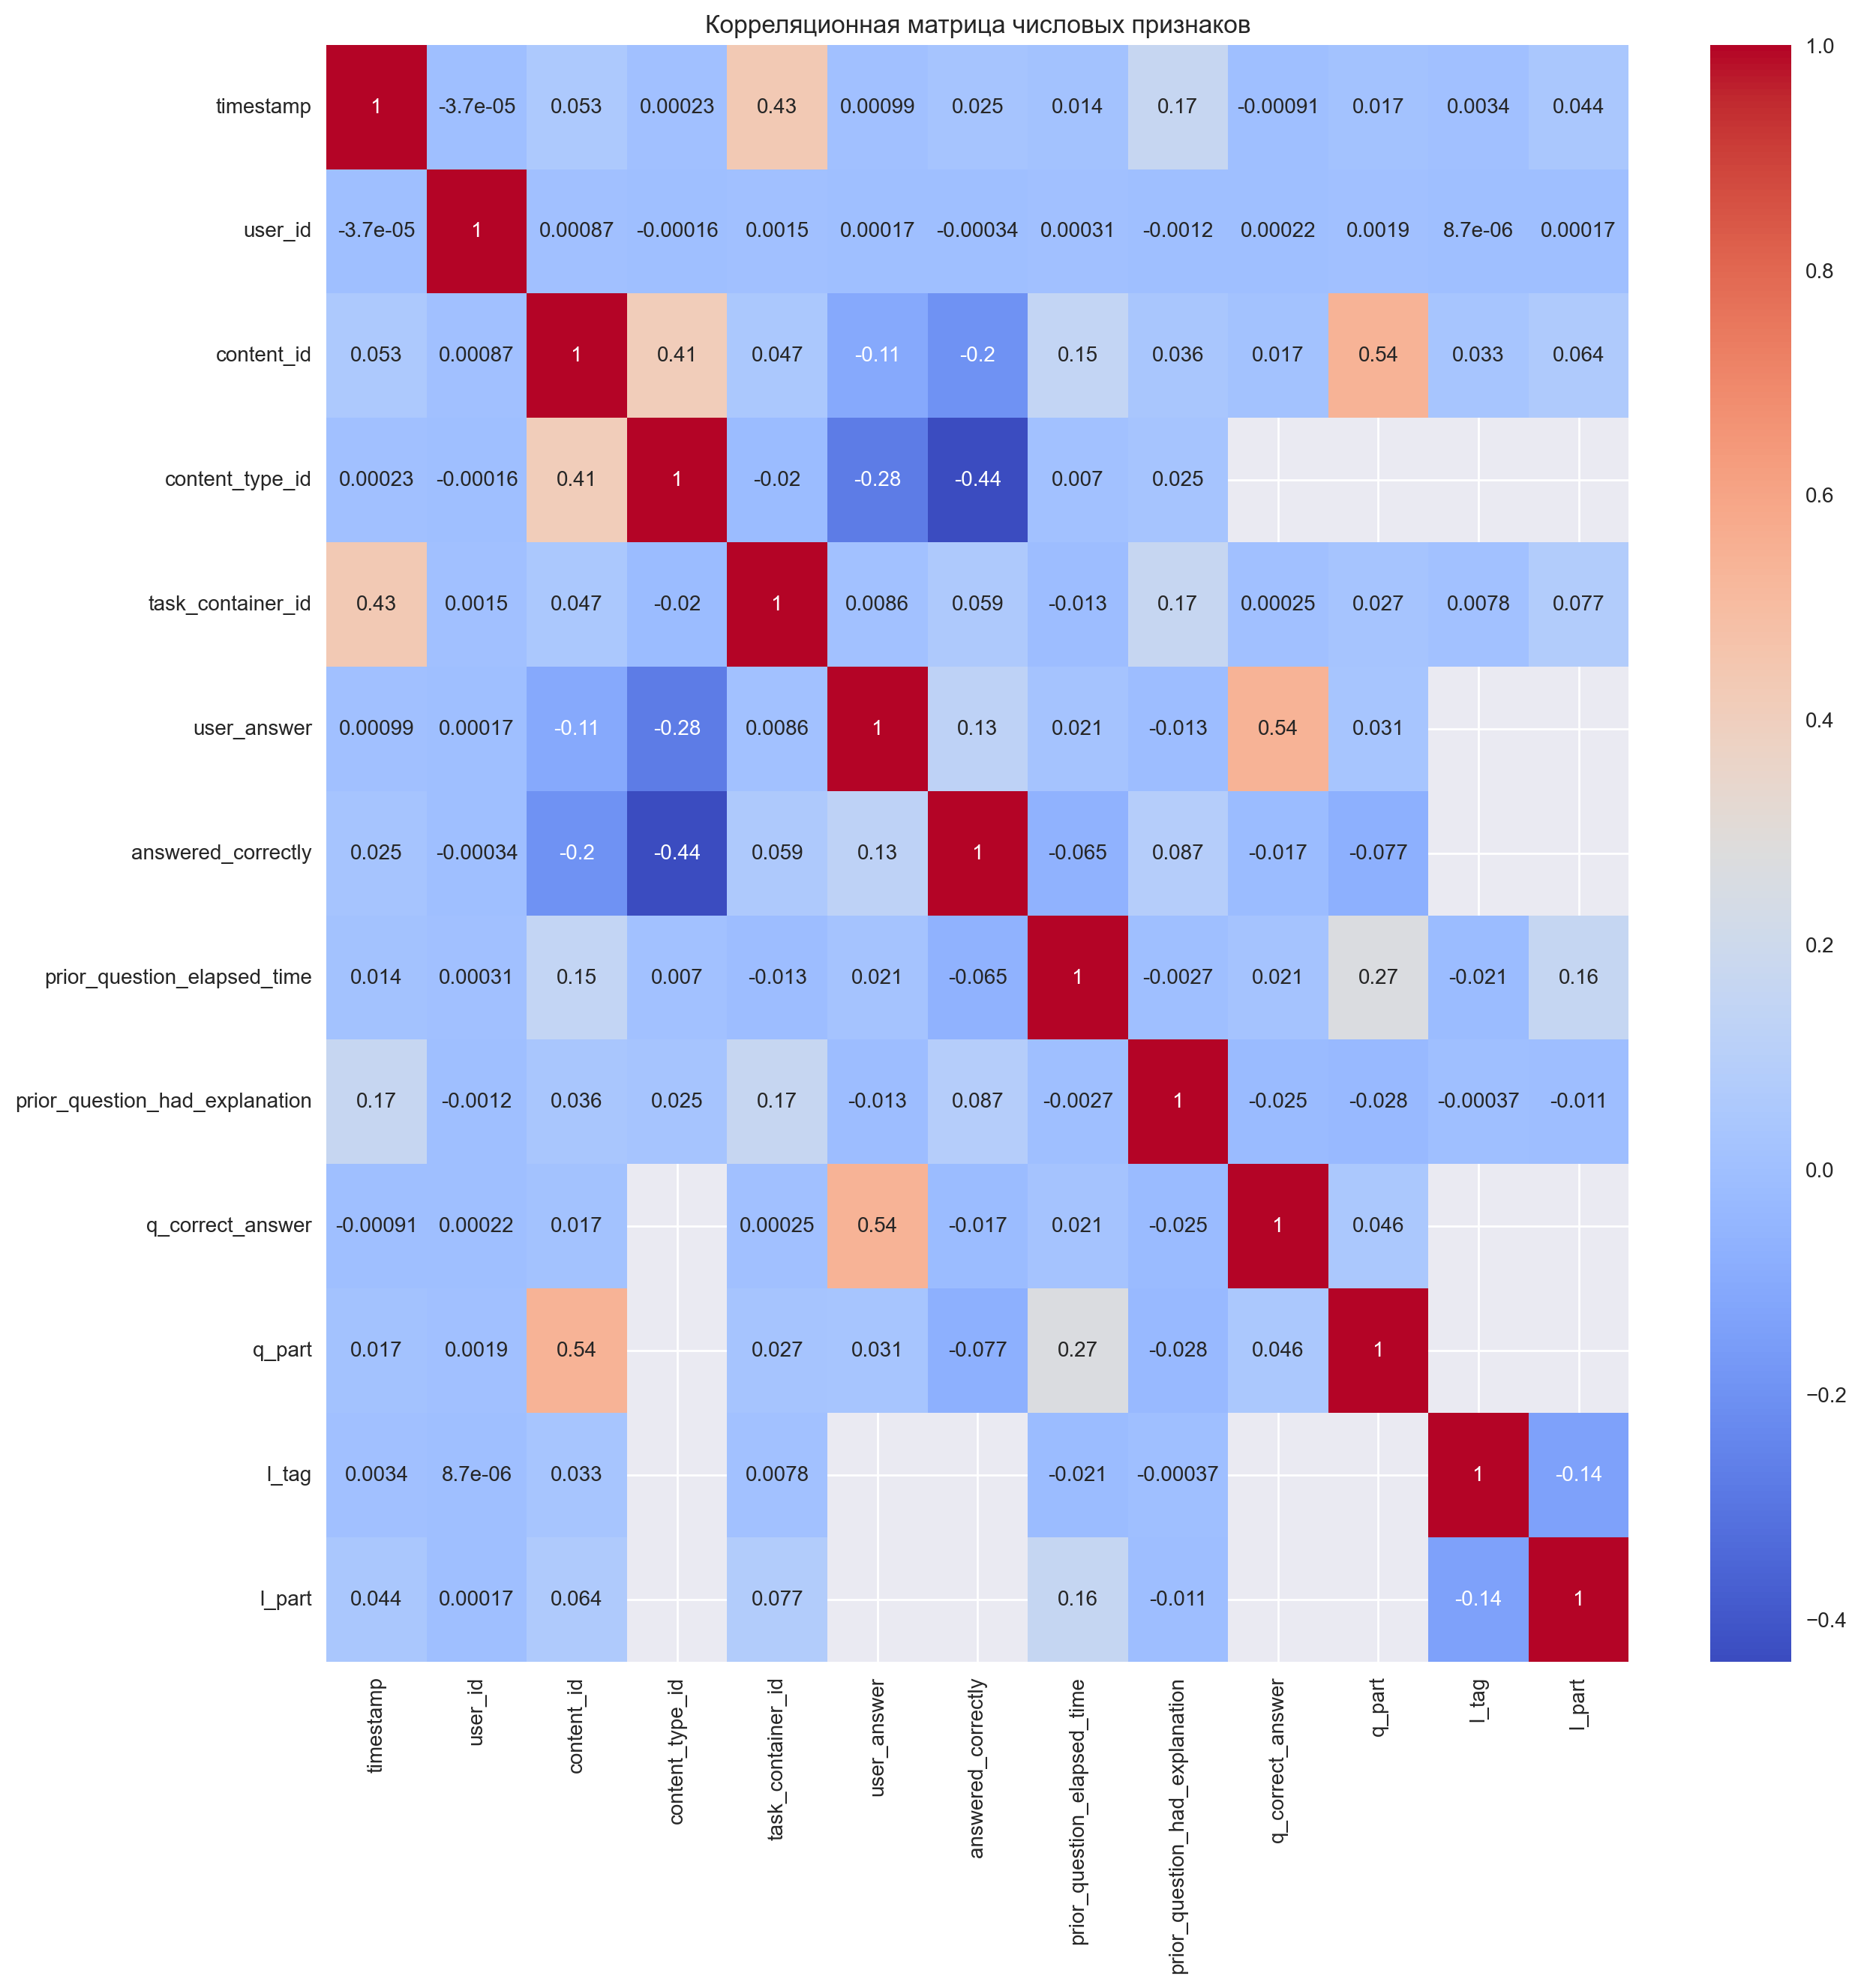

In [6]:
# Корреляционная матрица для числовых признаков
corr_matrix = df.drop(["q_tags","l_type_of"], axis=1).corr()

# Визуализация
plt.figure(figsize=(14, 14))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица числовых признаков')
plt.show()

### 4.0. Промежуточные выводы


- В датасете имеются пропущенные значения:
    - в признаках `q_correct_answer`, `q_part`, `q_tags`, если `content_type_id` = 1 ("лекция")
    - в признаках `l_tag`, `l_part`,  `l_type_of`, если `content_type_id` = 0 ("вопрос")
- пропуски связаны с `content_type_id` - в одном случае мы добавили признаки вопросов, в другом - признаки лекций
- признаки `content_type_id`, `user_answer`, `answered_correctly`, `prior_question_had_explanation`, `q_correct_answer`, `q_part`, `l_part`, `l_type_of` - **категориальные**
- отмечена умеренная корреляция между следующими признаками:
    - `content_type_id` и `content_id`
    - `task_container_id` и `timestamp`
    - `answered_correctly` и `content_type_id` (отрицательная)
    - `q_correct_answer` и `user_answer`
    - `q_part` и `content_id`

### 4.1. Признак `timestamp`

`timestamp`: (**int64**) the time in milliseconds between this user interaction and the first event completion from that user.    
Время в миллисекундах между этим взаимодействием с пользователем и первым завершением события от этого пользователя.

Получим статистические данные признака.

In [7]:
df[["timestamp"]].describe()

,timestamp
count,9.887879e+07
mean,7.712769e+09
std,1.159799e+10
min,0.000000e+00
25%,5.230705e+08
50%,2.677159e+09
75%,9.944019e+09
max,8.719333e+10


Визуализируем распределение признака.

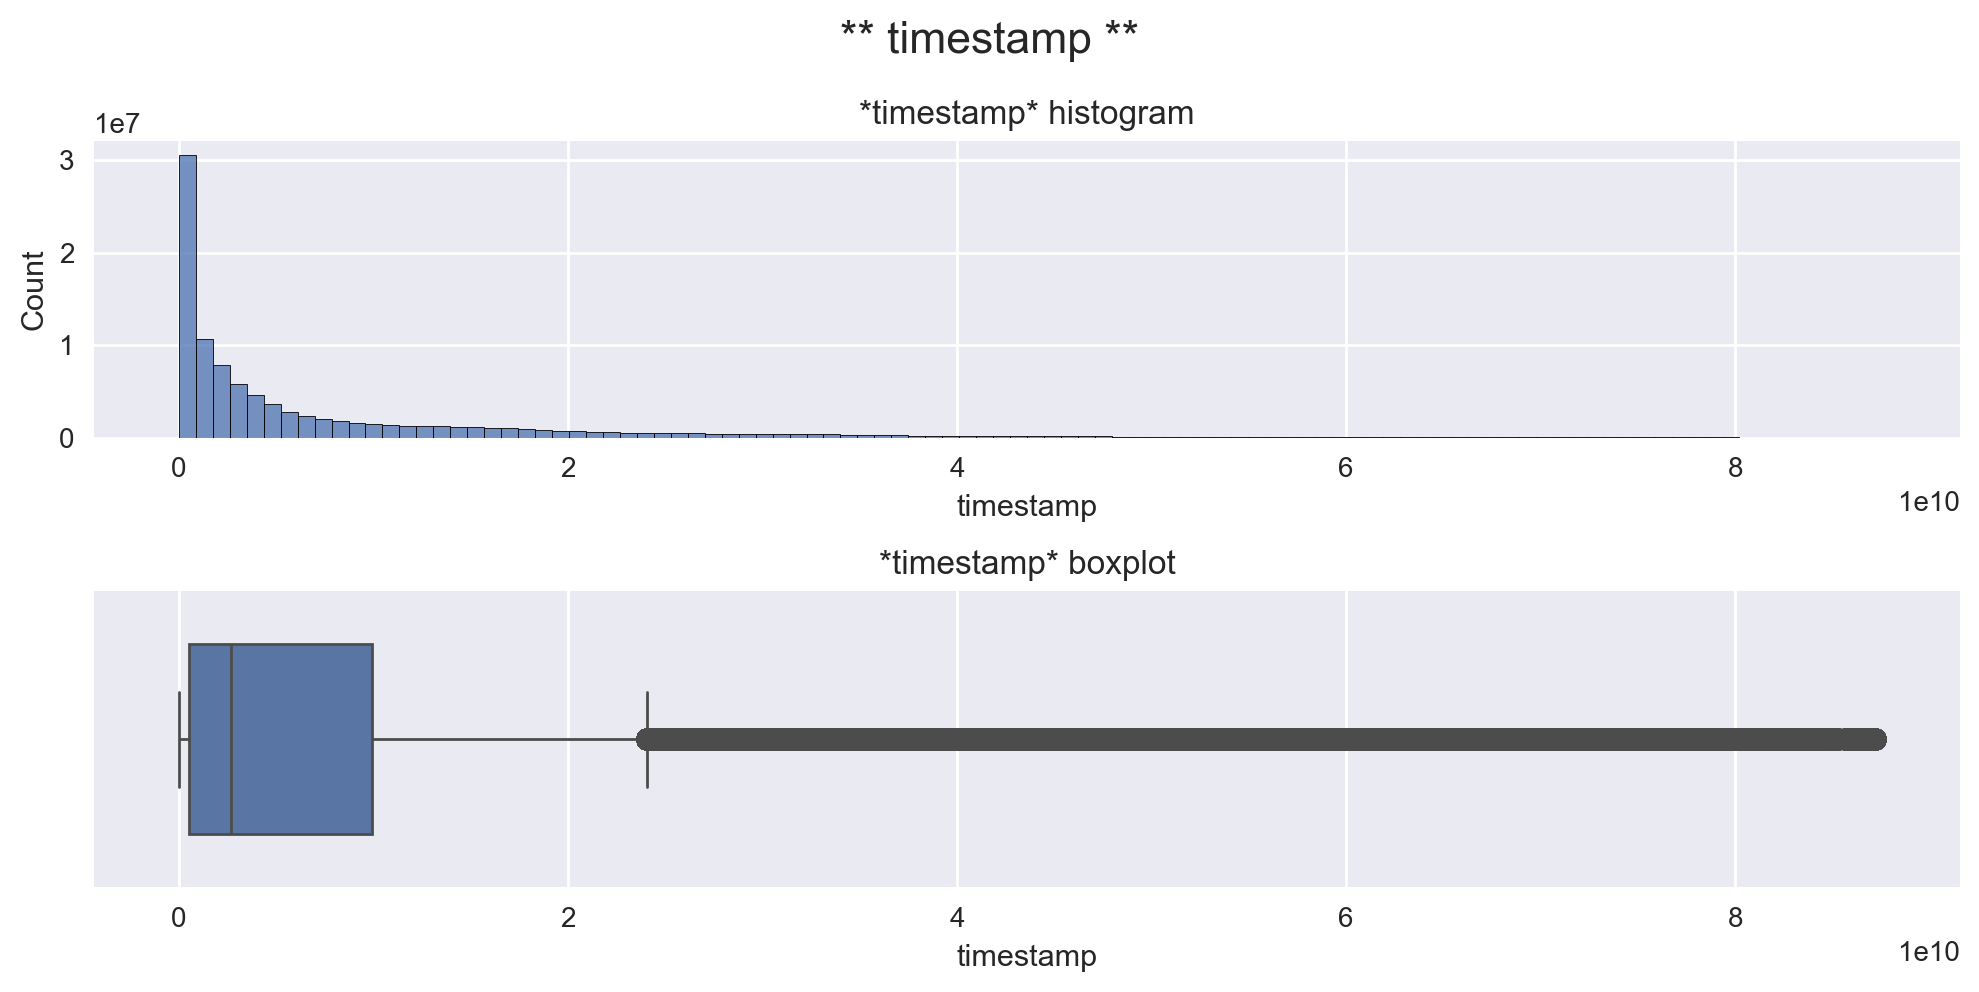

In [8]:
# задаем фигуру и ее заголовок
fig = plt.figure(figsize=(10,5))
fig.suptitle("** timestamp **", fontsize=16)

# первый график - гистограмма
plt.subplot(2, 1, 1)
histogram = sns.histplot(data=df, x='timestamp', bins=100) # график
histogram.set_title('*timestamp* histogram') # подпись графика

# второй график - ящик с усами
plt.subplot(2, 1, 2)
boxplot = sns.boxplot(data=df, x='timestamp', gap = .2) # график, gap - промежуток м/ду коробками
boxplot.set(title='*timestamp* boxplot', ylabel='') # подпись графика

plt.tight_layout() # промежуток между диаграммами
plt.show()

Распределение признака в разрезе признака `answered_correctly`

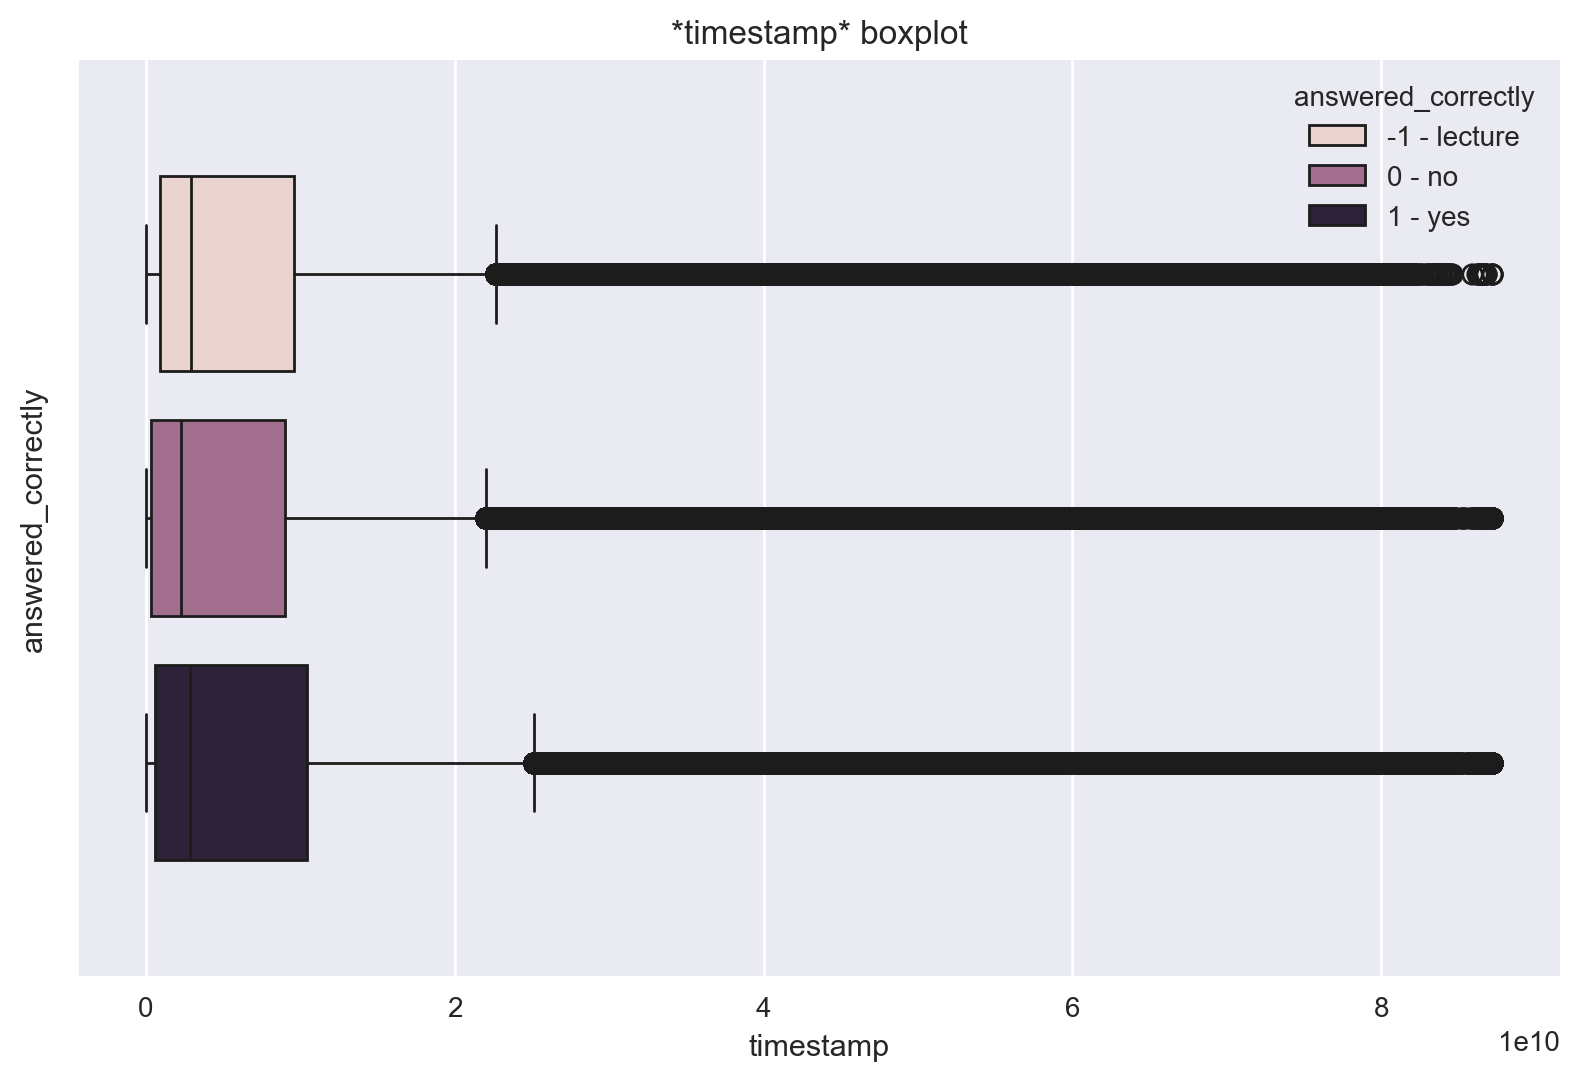

In [10]:
boxplot = sns.boxplot(data=df, x='timestamp', hue="answered_correctly", gap = .2) # график, gap - промежуток м/ду коробками
boxplot.set(title='*timestamp* boxplot', ylabel='answered_correctly') # подпись графика

plt.tight_layout() # промежуток между диаграммами
plt.legend(title='answered_correctly', labels=["-1 - lecture","0 - no","1 - yes"]) # легенда
plt.show()

Выведем данный признак для 5 случайных пользователей в виде линейного графика.

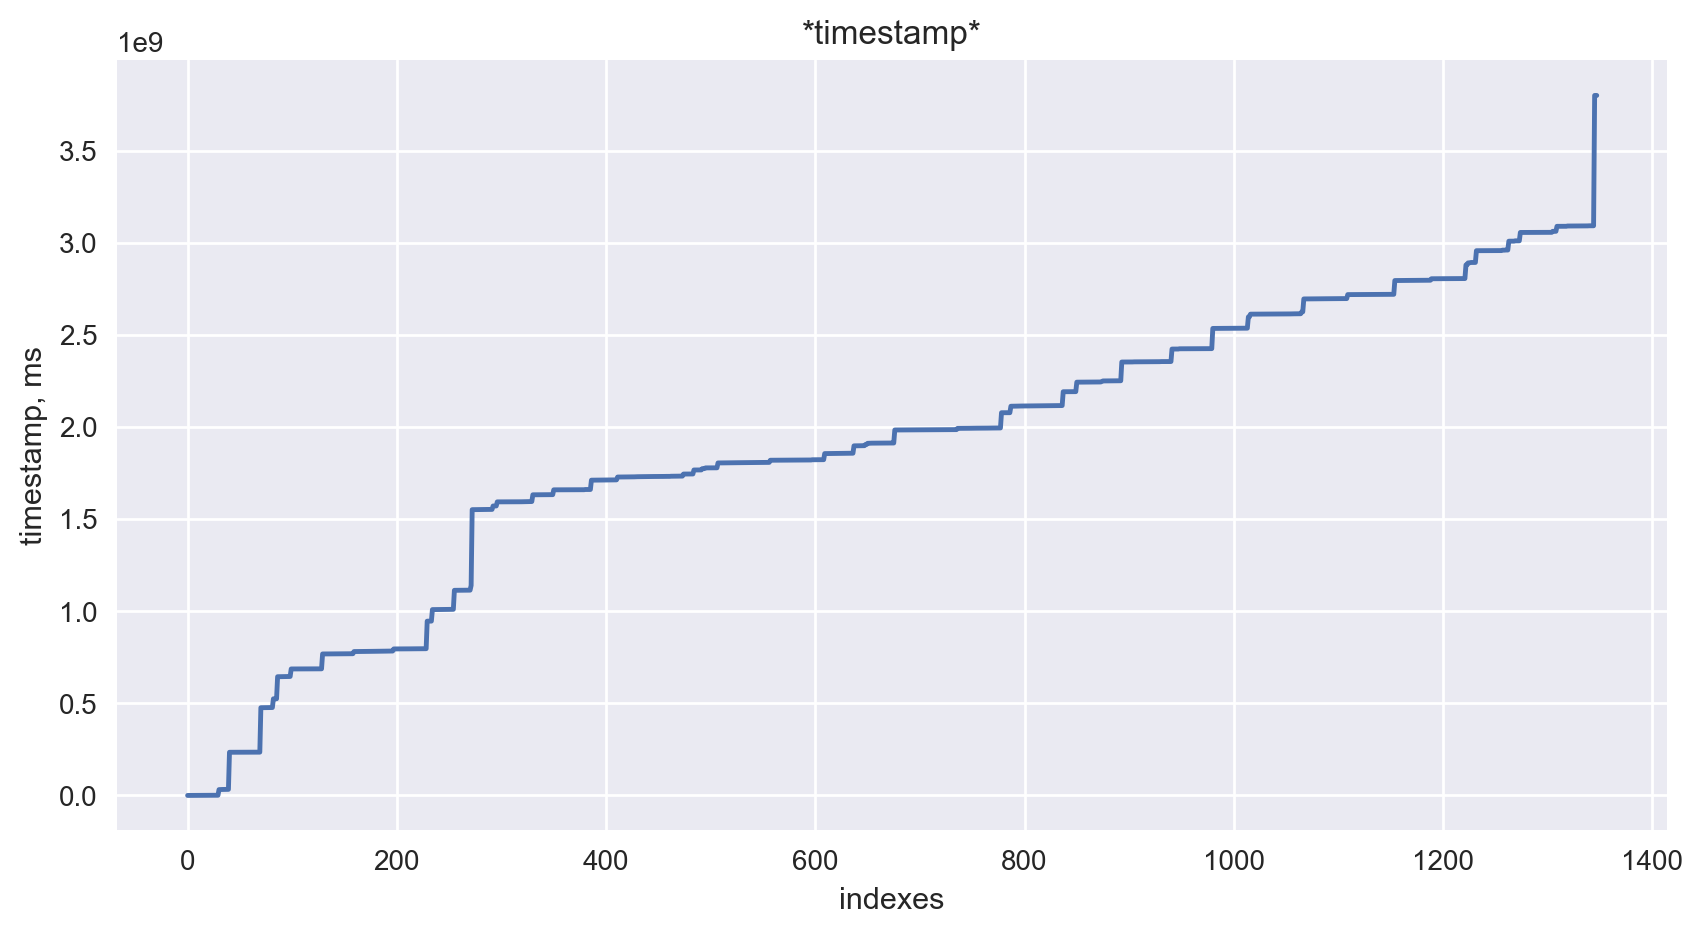

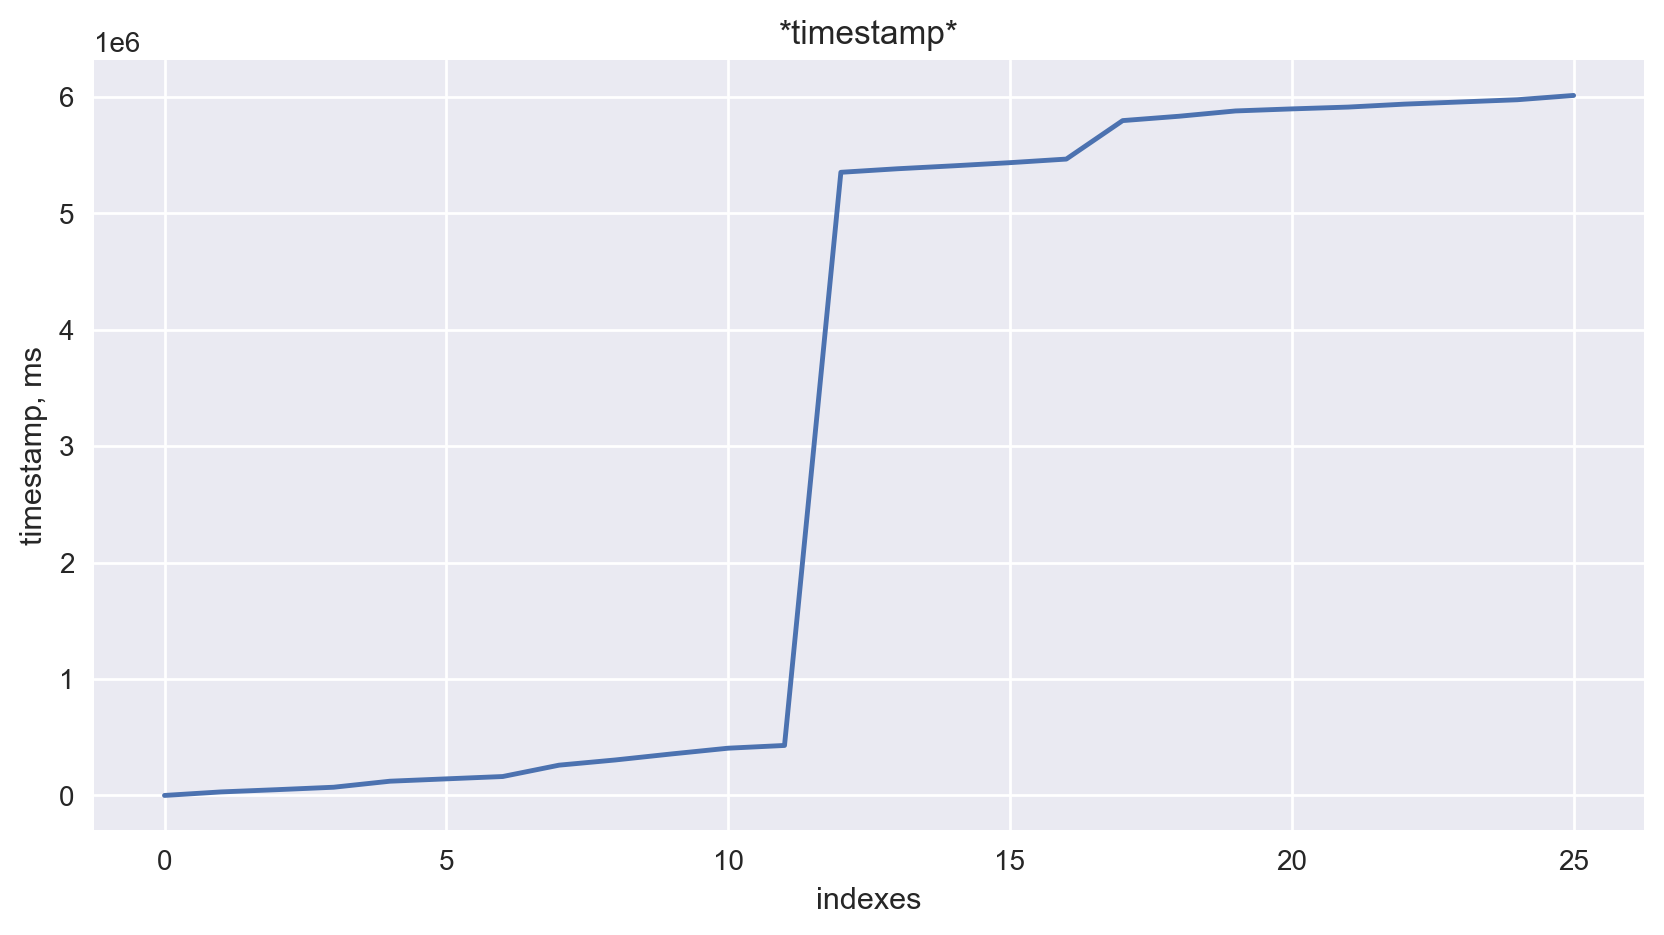

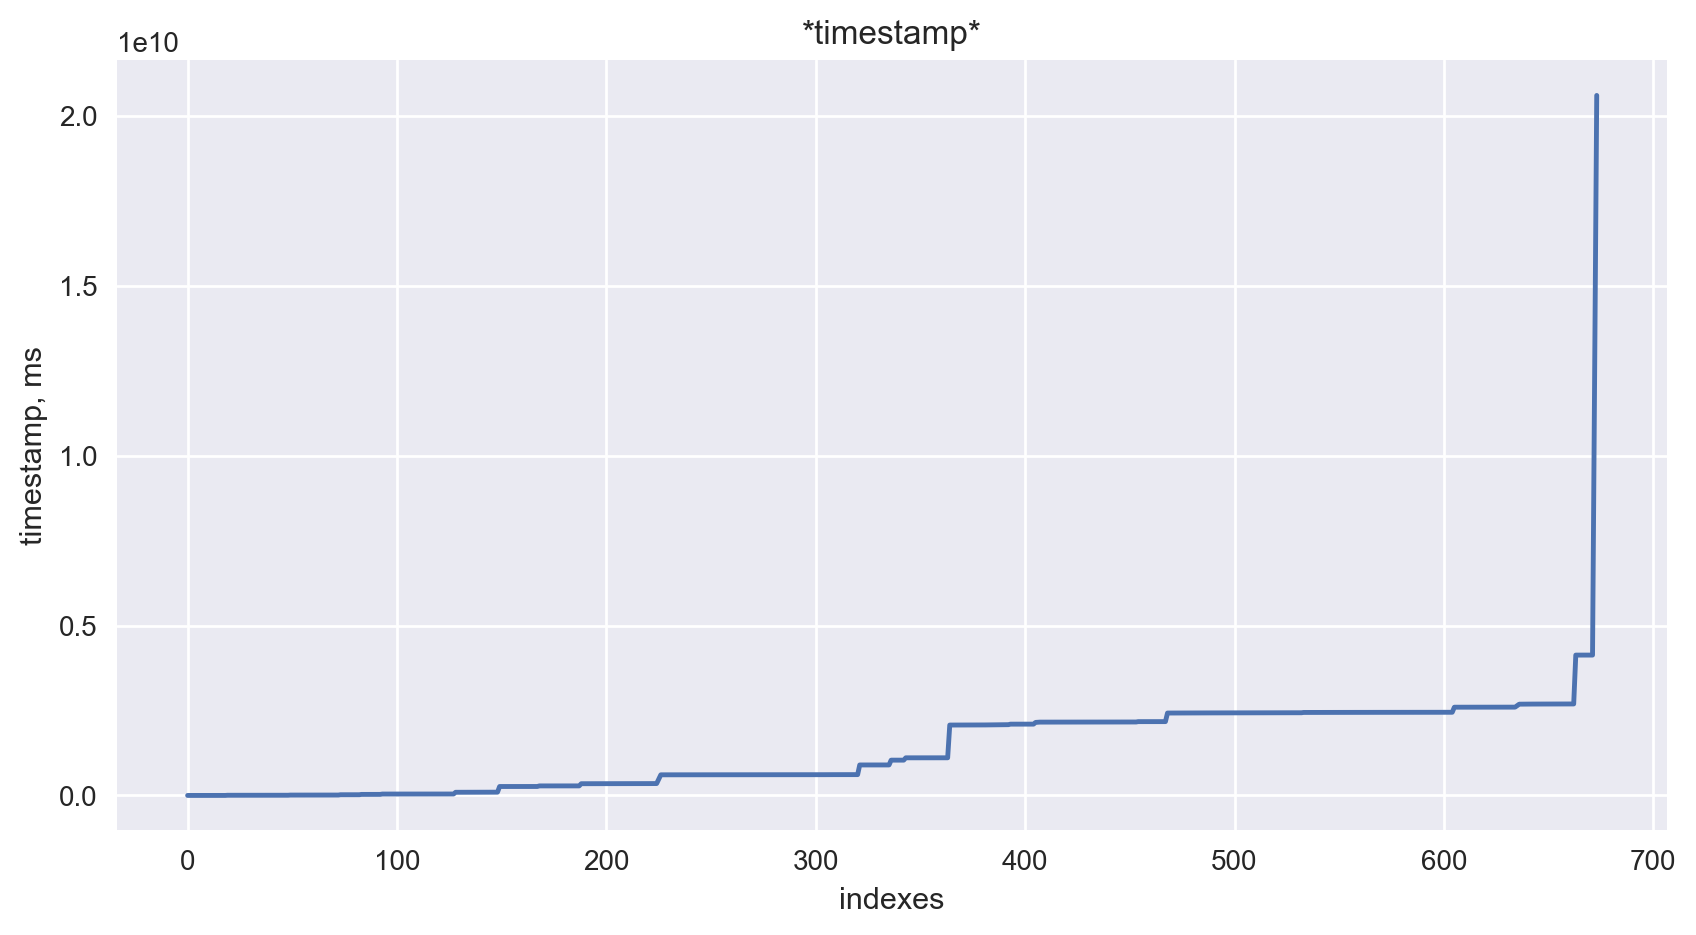

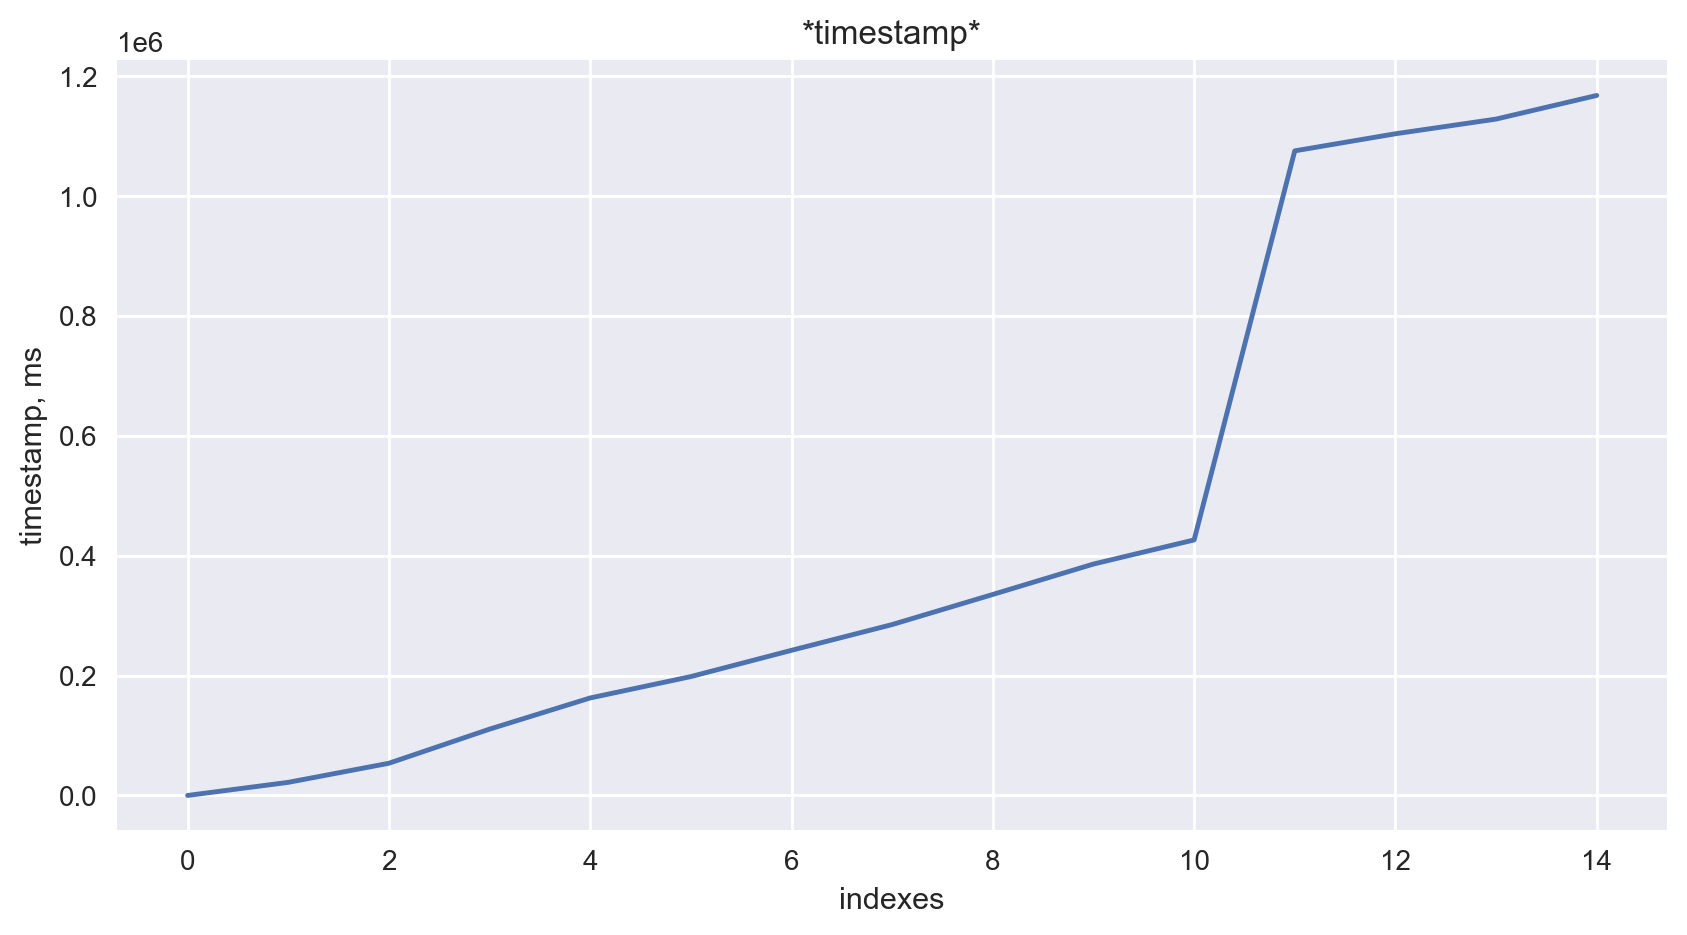

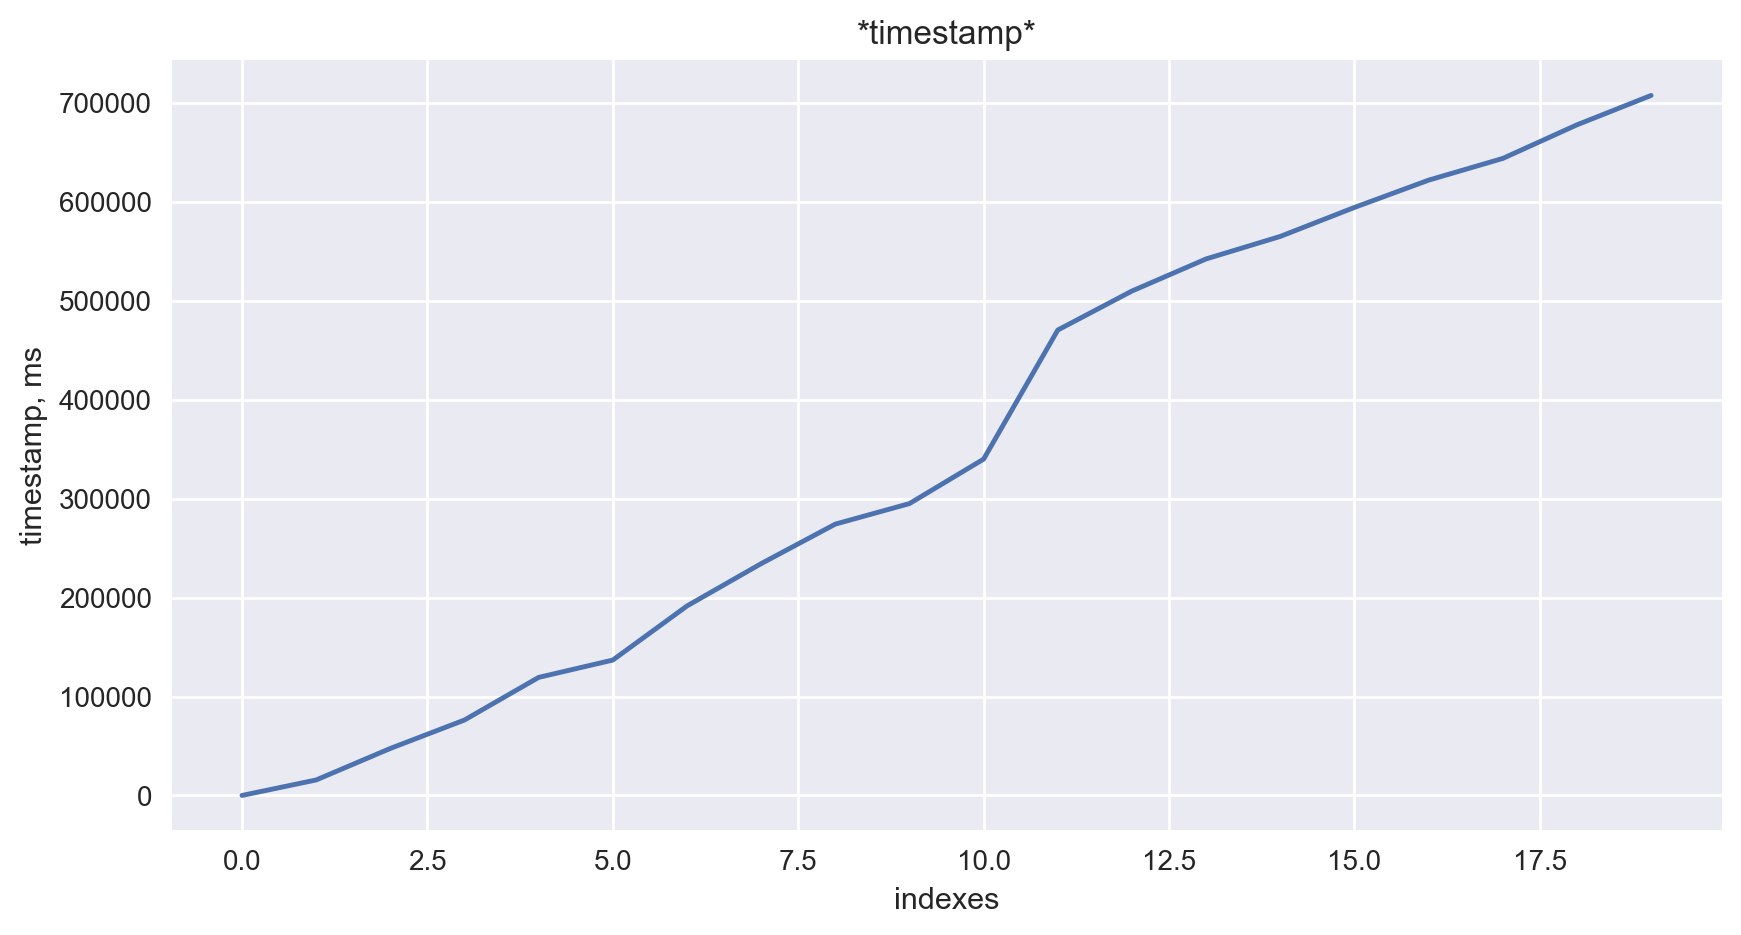

In [11]:
# получим 5 случайных пользователей
random_user_id = random.choices(df["user_id"].unique(), k=5)

# для каждого пользователя
for user_id in random_user_id:
    # маска пользователя
    mask = df["user_id"] == user_id
    # линейный график 
    plt.figure(figsize=(10, 5))
    plt.plot(df[mask].reset_index().index, df[mask]['timestamp'])
    plt.title('*timestamp*')
    plt.xlabel('indexes')
    plt.ylabel('timestamp, ms')
    plt.show()

**Выводы:**
- признак числовой
- распределение ближе к логнормальному, значения выше, примерно, 2.4e10 являются выбросами
- значения признака при взаимодействии с пользователем растет во времени, однако не обязательно ровно: иногда график имеет ступенчатый вид либо имеет резкий подъем вначале или в конце
- существенной разницы в распределении признака в разрезе признака `answered_correctly` нет

### 4.2. Признак `user_id`

`user_id`: (**int32**) ID code for the user.    
ID пользователя.

Получим статистические данные признака.

In [32]:
df[["user_id"]].describe()

,user_id
count,9.887879e+07
mean,1.076747e+09
std,6.196978e+08
min,1.150000e+02
25%,5.408447e+08
50%,1.071800e+09
75%,1.615742e+09
max,2.147483e+09


Визуализируем распределение признака.

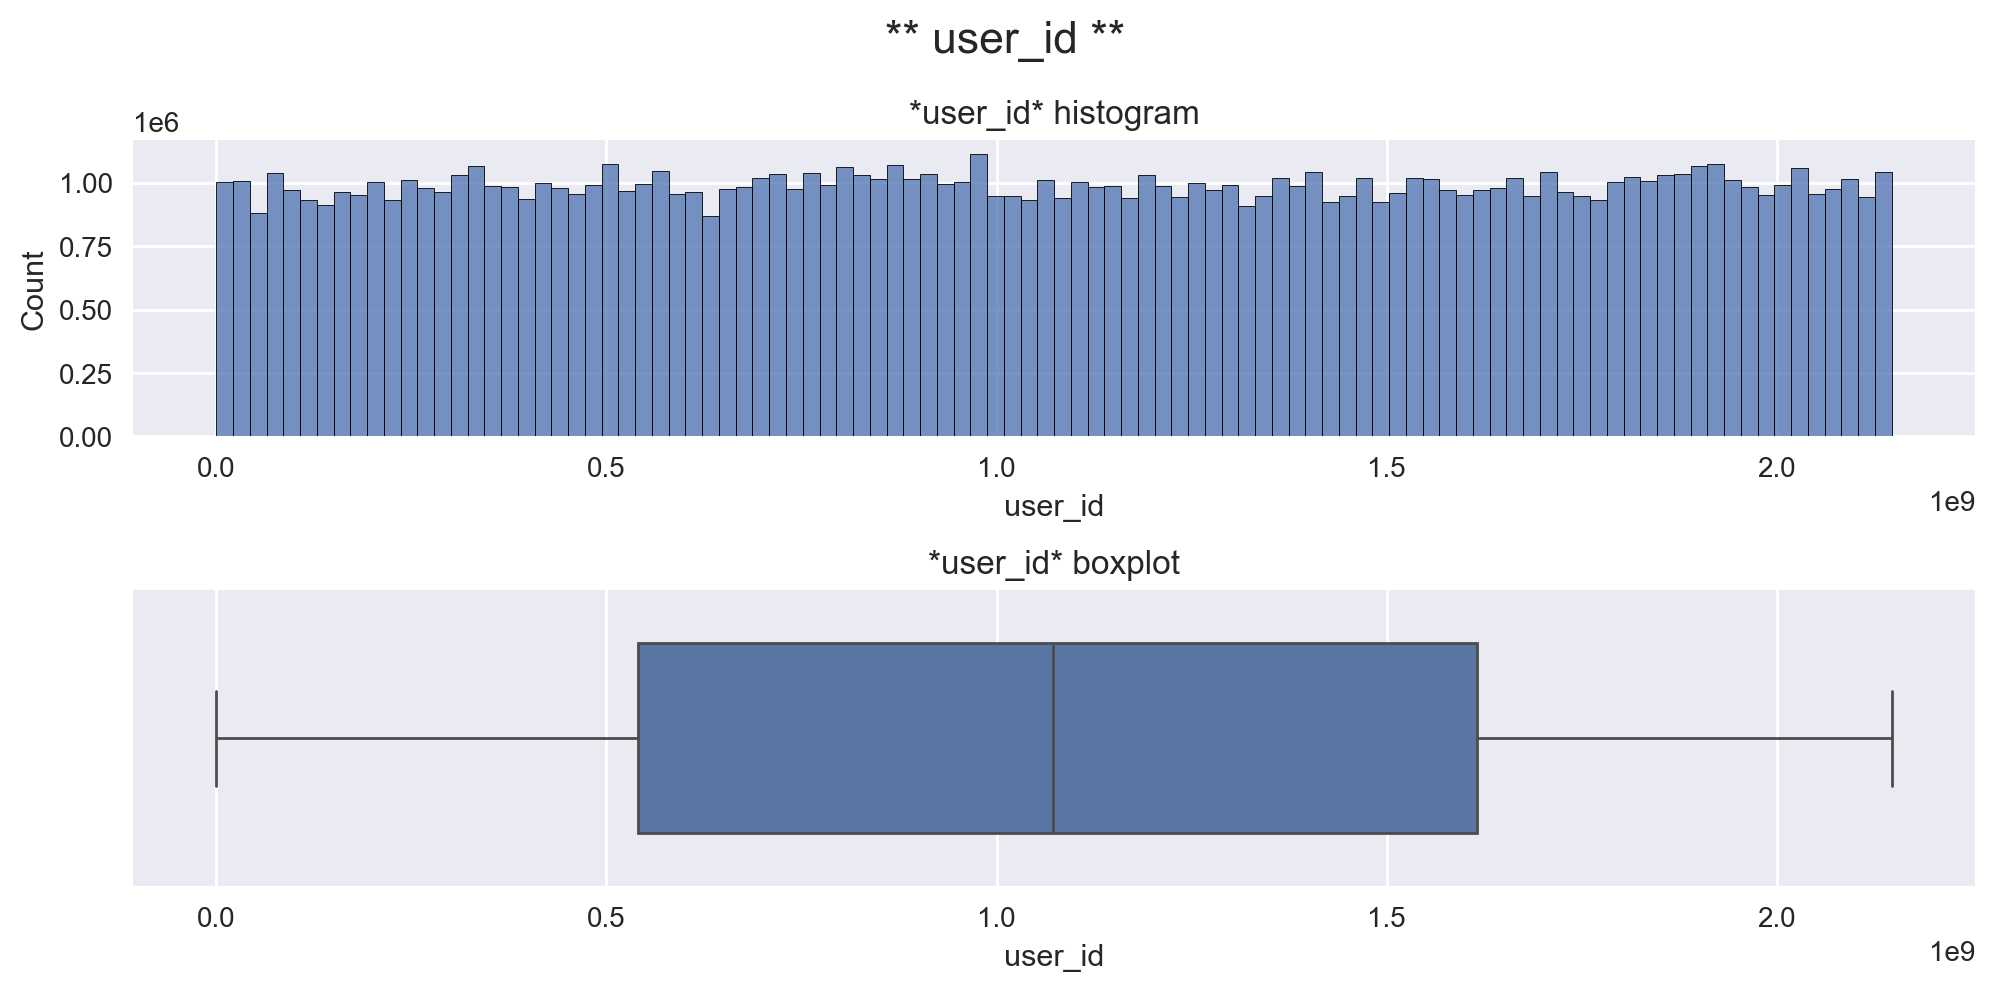

In [33]:
# задаем фигуру и ее заголовок
fig = plt.figure(figsize=(10,5))
fig.suptitle("** user_id **", fontsize=16)

# первый график - гистограмма
plt.subplot(2, 1, 1)
histogram = sns.histplot(data=df, x='user_id', bins=100) # график
histogram.set_title('*user_id* histogram') # подпись графика

# второй график - ящик с усами
plt.subplot(2, 1, 2)
boxplot = sns.boxplot(data=df, x='user_id', gap = .2) # график, gap - промежуток м/ду коробками
boxplot.set(title='*user_id* boxplot', ylabel='') # подпись графика

plt.tight_layout() # промежуток между диаграммами
plt.show()

In [34]:
df.user_id.value_counts(normalize=True)

user_id
801103753     1.780766e-04
1478712595    1.703196e-04
455973631     1.682767e-04
1842816145    1.671946e-04
1743444187    1.660922e-04
                  ...     
785368481     1.011339e-08
852229065     1.011339e-08
763739841     1.011339e-08
1264318047    1.011339e-08
522534363     1.011339e-08
Name: proportion, Length: 393570, dtype: float64

**Выводы:** 
- признак числовой, но по сути - категориальный
- если посмотреть на его распределение как числового признака - каких-то явных отклонений и выбросов нет

### 4.3. Признак `content_id`

`content_id`: (**int16**) ID code for the user interaction.    
ID взаимодействия с пользователем.

Получим статистические данные признака.

In [35]:
df[["content_id"]].describe()

,content_id
count,9.887879e+07
mean,5.220997e+03
std,3.865282e+03
min,0.000000e+00
25%,2.063000e+03
50%,5.020000e+03
75%,7.448000e+03
max,3.273600e+04


In [15]:
df[["content_id"]].nunique()

content_id    13781
dtype: int64

In [42]:
df.content_id.value_counts(normalize=True).iloc[:10]

content_id
6116    0.002131
6173    0.002022
4120    0.001999
175     0.001967
7876    0.001911
7900    0.001825
2064    0.001776
2065    0.001776
2063    0.001776
4492    0.001751
Name: proportion, dtype: float64

In [43]:
df.content_id.nunique()

13781

Визуализируем распределение признака.

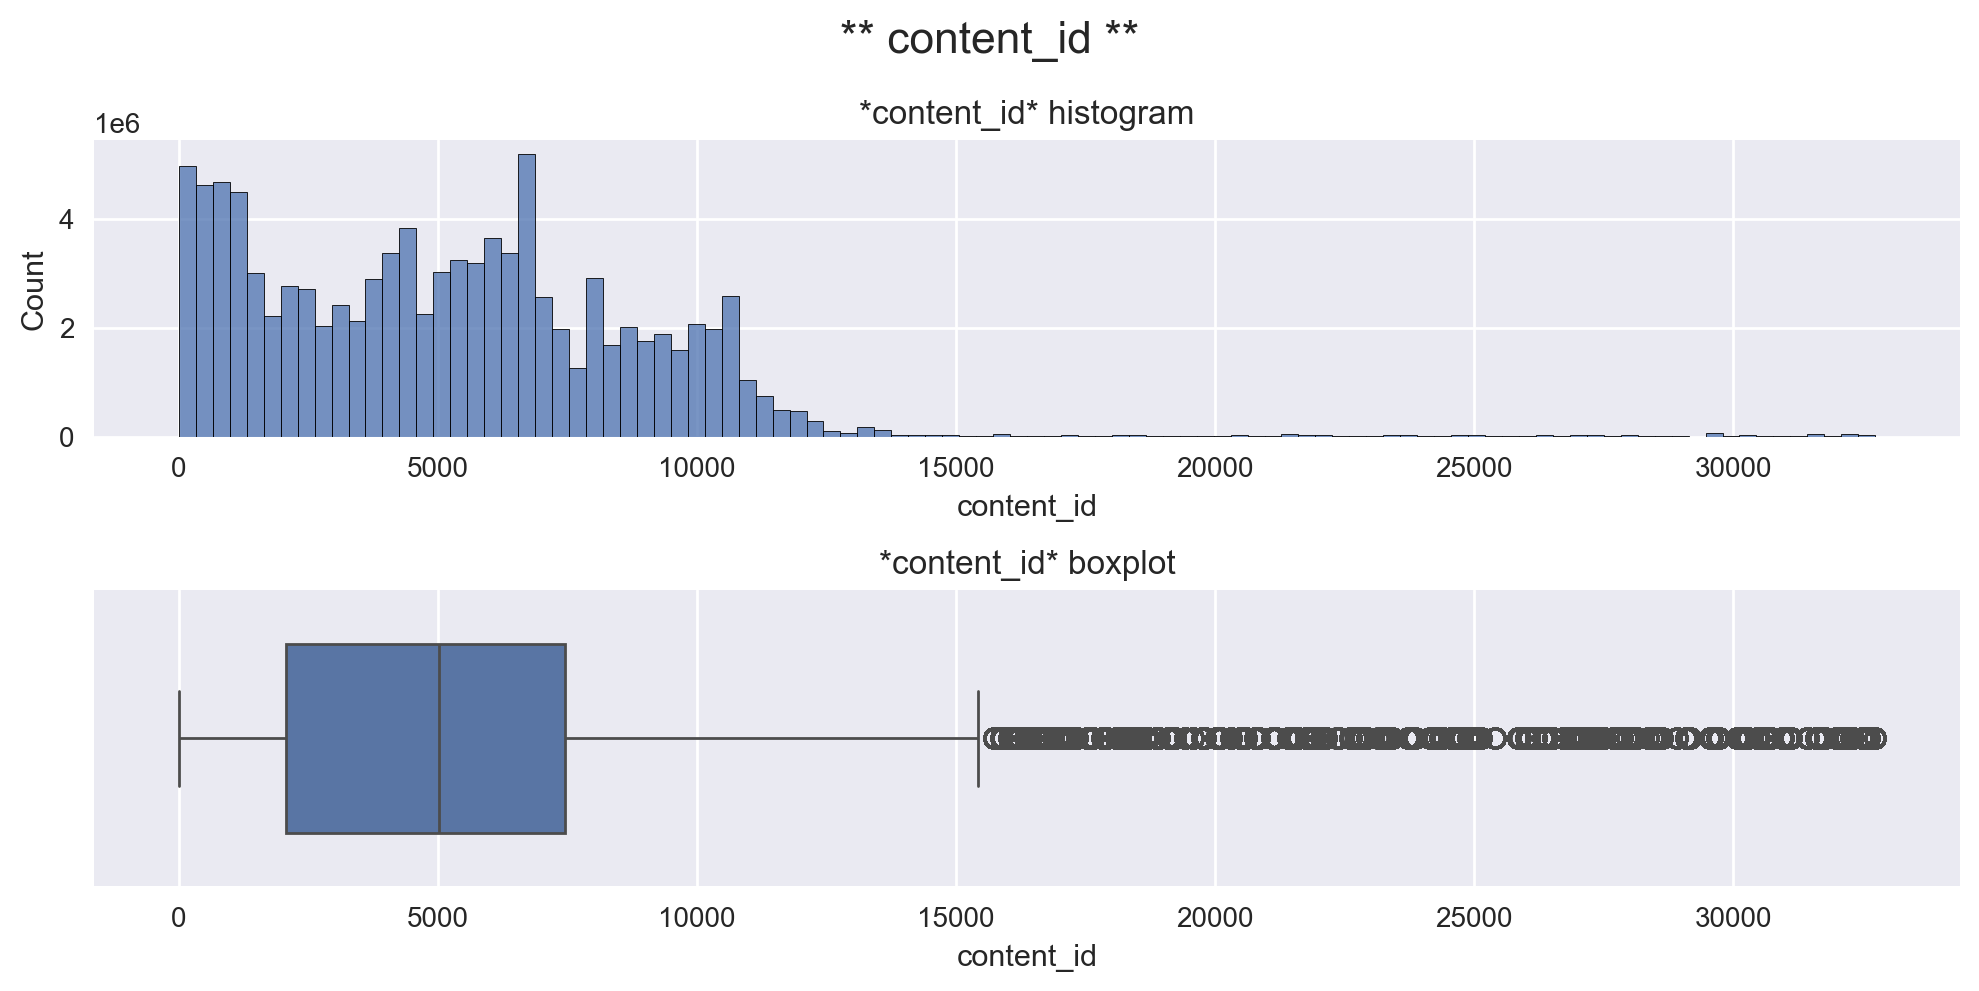

In [36]:
# задаем фигуру и ее заголовок
fig = plt.figure(figsize=(10,5))
fig.suptitle("** content_id **", fontsize=16)

# первый график - гистограмма
plt.subplot(2, 1, 1)
histogram = sns.histplot(data=df, x='content_id', bins=100) # график
histogram.set_title('*content_id* histogram') # подпись графика

# второй график - ящик с усами
plt.subplot(2, 1, 2)
boxplot = sns.boxplot(data=df, x='content_id', gap = .2) # график, gap - промежуток м/ду коробками
boxplot.set(title='*content_id* boxplot', ylabel='') # подпись графика

plt.tight_layout() # промежуток между диаграммами
plt.show()

Распределение признака в разрезе признака `answered_correctly`

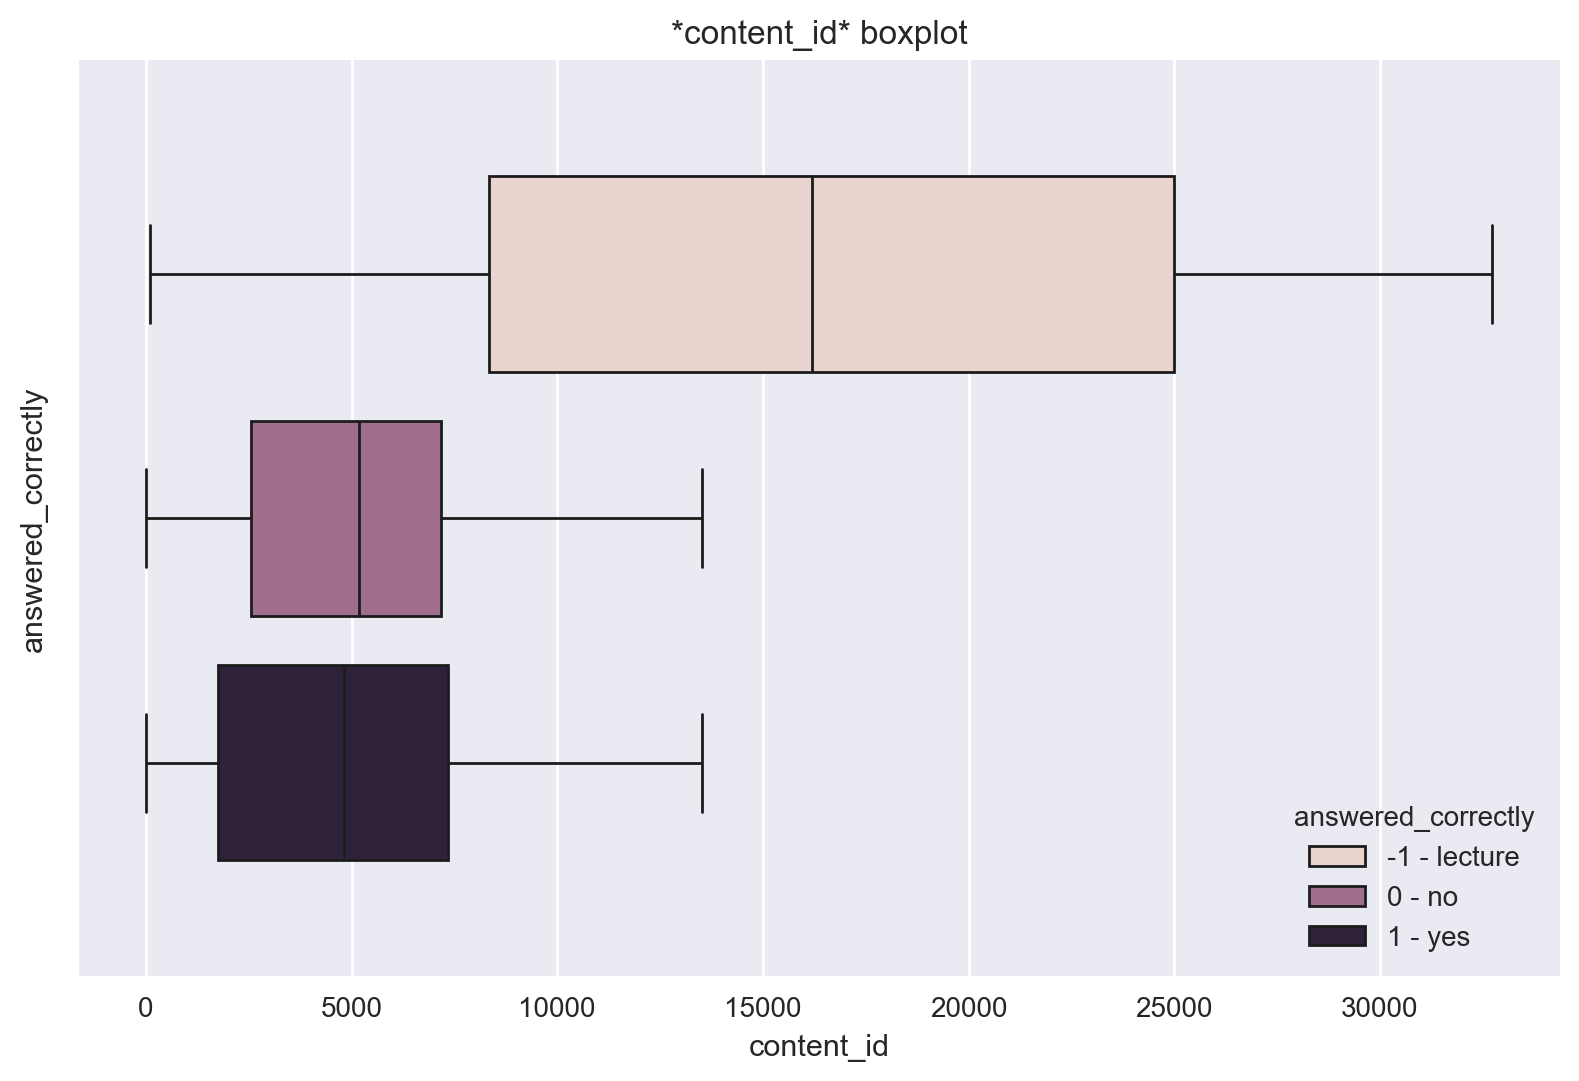

In [39]:
boxplot = sns.boxplot(data=df, x='content_id', hue="answered_correctly", gap = .2) # график, gap - промежуток м/ду коробками
boxplot.set(title='*content_id* boxplot', ylabel='answered_correctly') # подпись графика

plt.tight_layout() # промежуток между диаграммами
plt.legend(title='answered_correctly', labels=["-1 - lecture","0 - no","1 - yes"]) # легенда
plt.show()

**Выводы:**
- не совсем понятна суть данного признака, количество его уникальных значений явно меньше количества пользователей
- при анализе распределения его в разрезе `answered_correctly` отсутствуют выбросы и видно, что в целом есть значения `content_id`, которым соответствую в основном лекции, а есть значения, которым соответствую в основном вопросы

### 4.4. Признак `content_type_id`

`content_type_id`: (**int8**) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.    
0, если событием был вопрос, заданный пользователю, 1, если событием был просмотр лекции.

Получим статистические данные признака.

In [10]:
df[["content_type_id"]].describe()

,content_type_id
count,9.887879e+07
mean,1.921579e-02
std,1.372827e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


In [45]:
df["content_type_id"].value_counts()

content_type_id
0    96978759
1     1900034
Name: count, dtype: int64

Визуализируем признак в разрезе признака `answered_correctly`

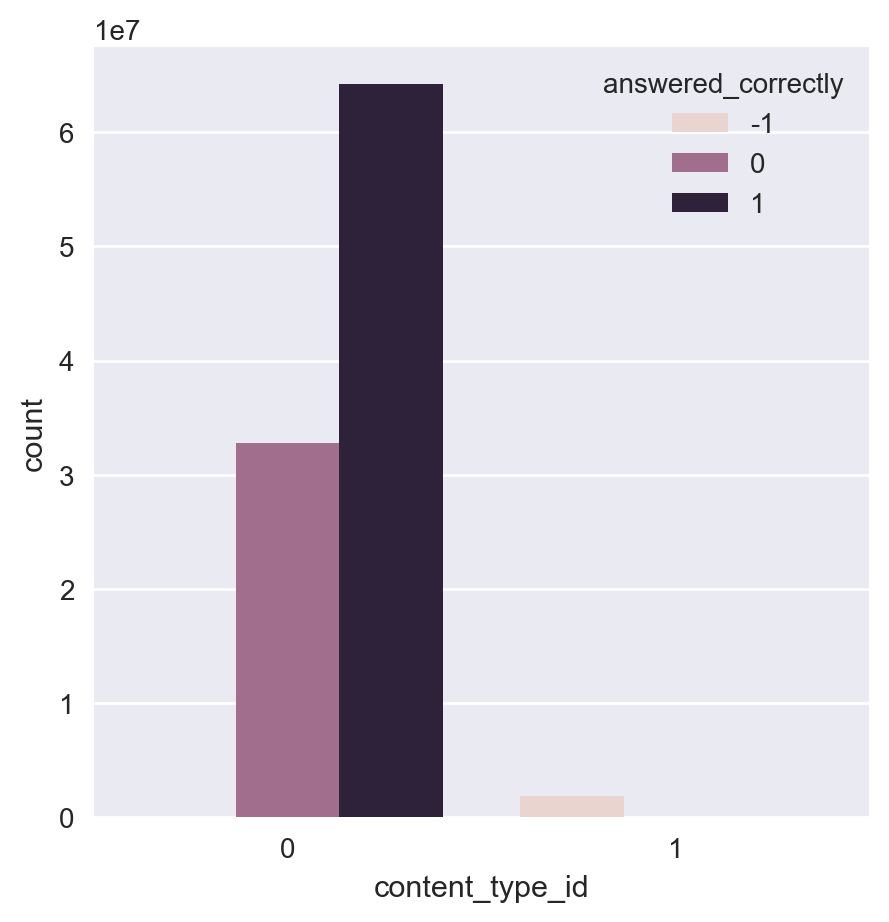

In [4]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='content_type_id',hue='answered_correctly',data=df)
plt.show()

**Выводы:**
- категориальный признак
- количество лекции совсем невелико, по сравнению с количеством вопросов
- пользователи отвечали на вопросы правильно почти в 2 раза чаще, чем неправильно

### 4.5. Признак `task_container_id`

`task_container_id`: (**int16**) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a *task_container_id*.    
ID партии вопросов или лекций. Например, пользователь может просмотреть три вопроса подряд, прежде чем увидит объяснения к ним. Все эти три вопроса будут иметь общий идентификатор *task_container_id*.

Получим статистические данные признака.

In [5]:
df[["task_container_id"]].describe()

,task_container_id
count,9.887879e+07
mean,9.105055e+02
std,1.366437e+03
min,0.000000e+00
25%,1.050000e+02
50%,3.840000e+02
75%,1.103000e+03
max,9.999000e+03


Визуализируем распределение признака.

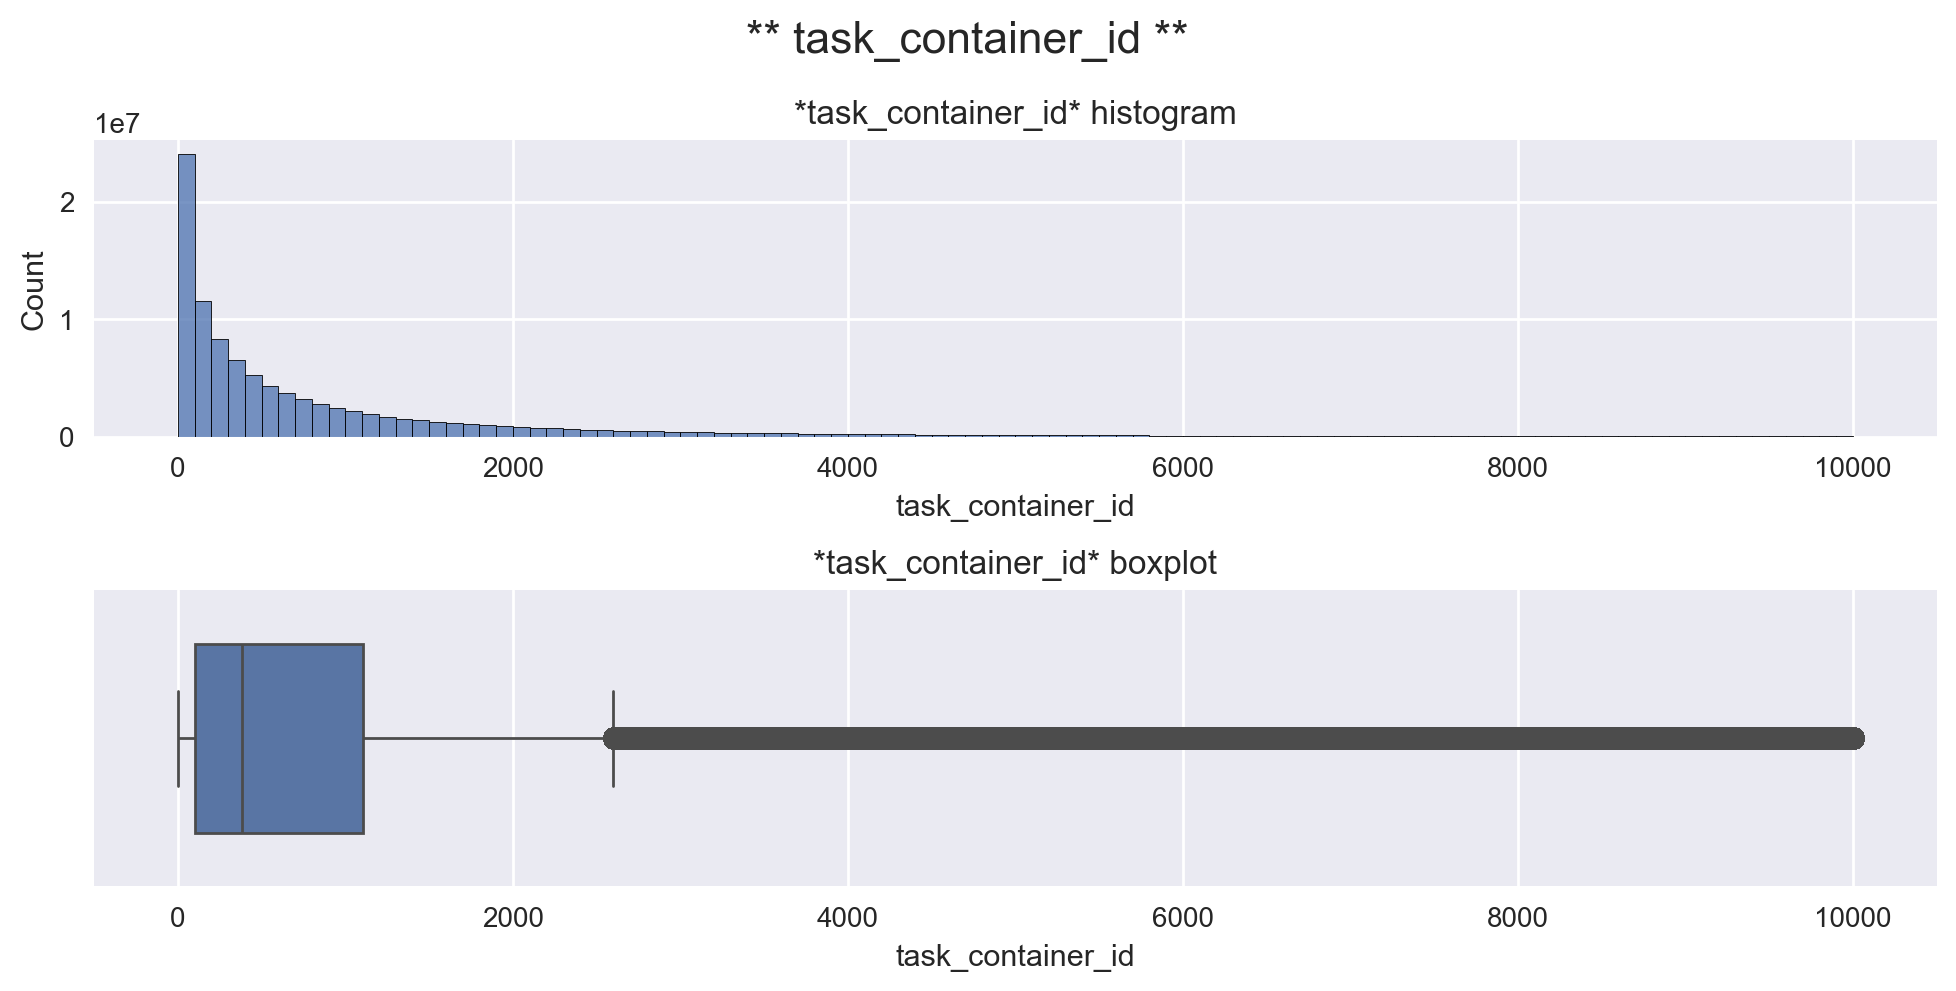

In [8]:
# задаем фигуру и ее заголовок
fig = plt.figure(figsize=(10,5))
fig.suptitle("** task_container_id **", fontsize=16)

# первый график - гистограмма
plt.subplot(2, 1, 1)
histogram = sns.histplot(data=df, x='task_container_id', bins=100) # график
histogram.set_title('*task_container_id* histogram') # подпись графика

# второй график - ящик с усами
plt.subplot(2, 1, 2)
boxplot = sns.boxplot(data=df, x='task_container_id', gap = .2) # график, gap - промежуток м/ду коробками
boxplot.set(title='*task_container_id* boxplot', ylabel='') # подпись графика

plt.tight_layout() # промежуток между диаграммами
plt.show()

Распределение признака в разрезе признака `answered_correctly`

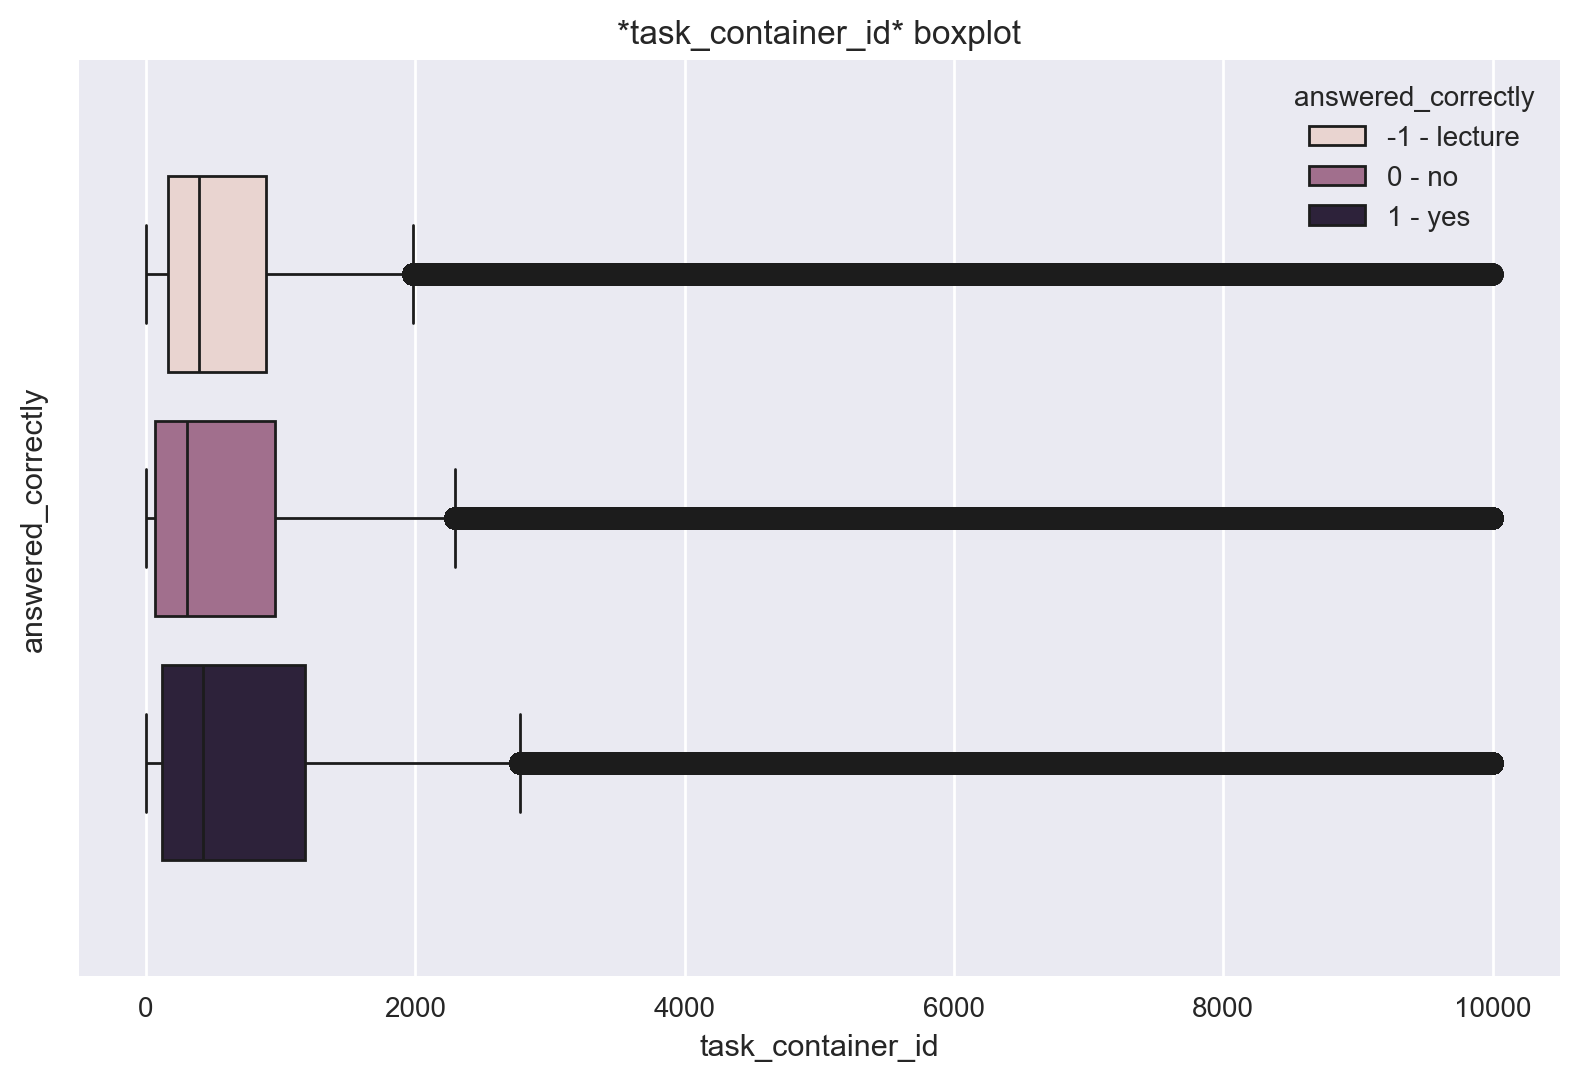

In [9]:
boxplot = sns.boxplot(data=df, x='task_container_id', hue="answered_correctly", gap = .2) # график, gap - промежуток м/ду коробками
boxplot.set(title='*task_container_id* boxplot', ylabel='answered_correctly') # подпись графика

plt.tight_layout() # промежуток между диаграммами
plt.legend(title='answered_correctly', labels=["-1 - lecture","0 - no","1 - yes"]) # легенда
plt.show()

Распределение признака в разрезе признака `user_answer`

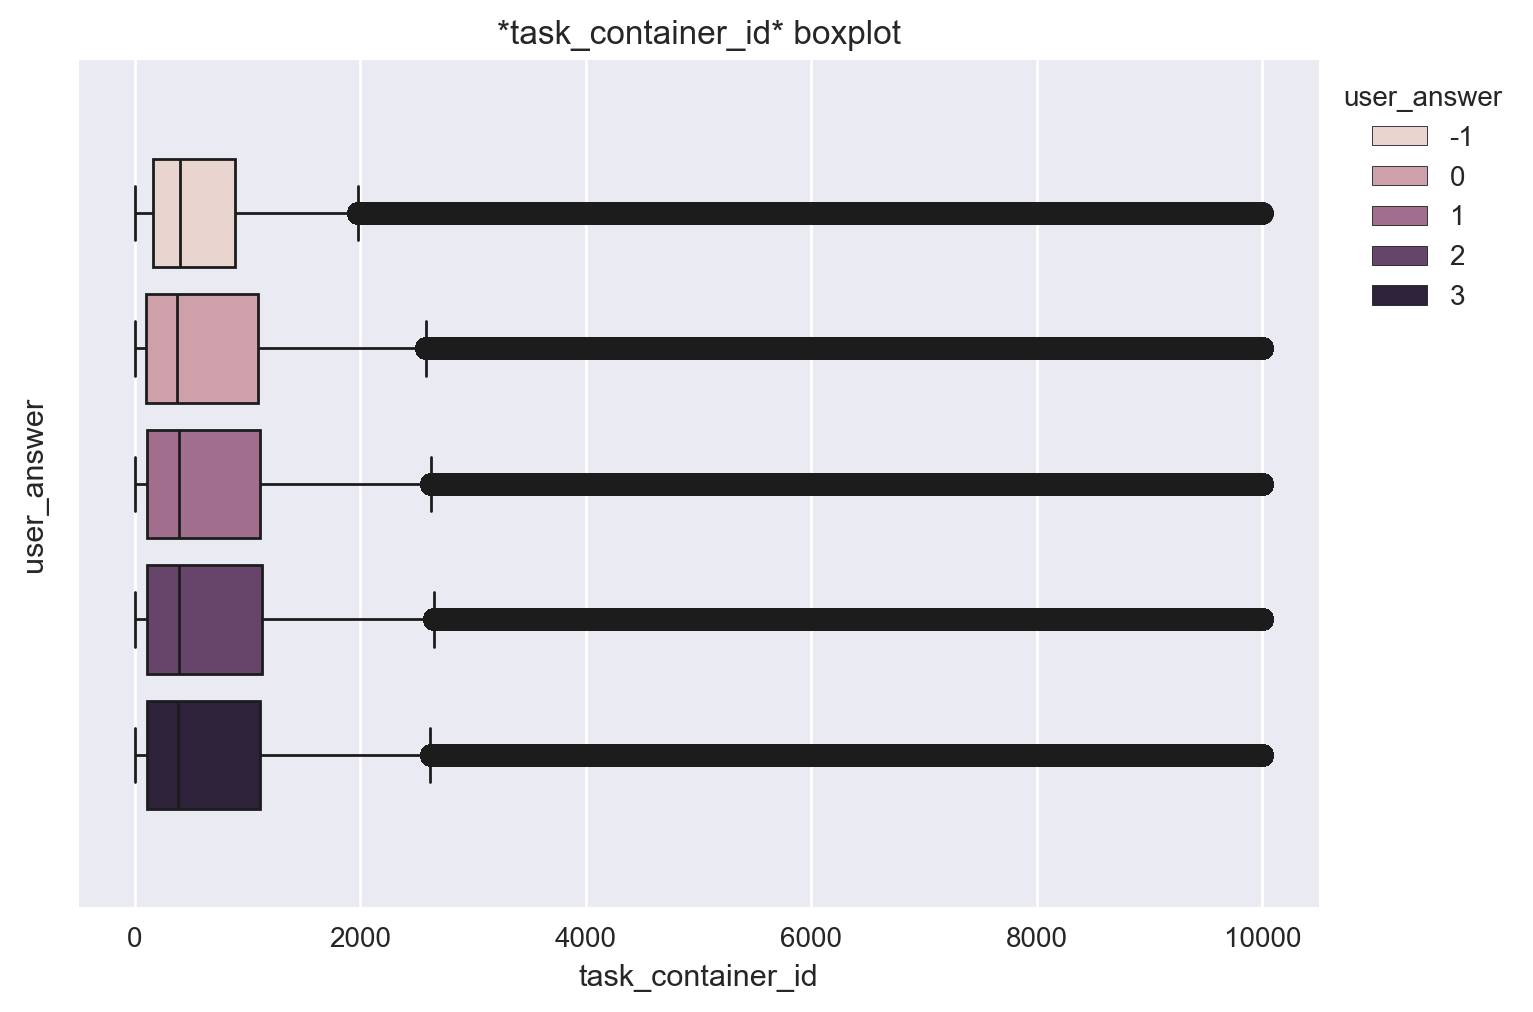

In [20]:
boxplot = sns.boxplot(data=df, x='task_container_id', hue="user_answer", gap = .2) # график, gap - промежуток м/ду коробками
boxplot.set(title='*task_container_id* boxplot', ylabel='user_answer') # подпись графика

plt.legend(title = "user_answer", loc='upper left', bbox_to_anchor=(1, 1)) # легенда
plt.show()

**Выводы:**
- признак числовой, но по сути категориальный
- распределение его в разрезе `answered_correctly` и `user_answer` принципиально не отличается, есть выбросы. Хотя можно отметить, что для лекций IQR меньше

### 4.6. Признаки `user_answer` и `answered_correctly`

- `user_answer`: (**int8**) the user's answer to the question, if any. Read -1 as null, for lectures.    
Ответ пользователя на вопрос, если таковой имеется. Зачитывайте -1 как null, для лекций.
- `answered_correctly`: (**int8**) if the user responded correctly. Read -1 as null, for lectures.    
Если пользователь ответил правильно. Зачитывайте -1 как null, для лекций.

Получим статистические данные признаков.

In [11]:
df[["user_answer", "answered_correctly"]].describe()

,user_answer,answered_correctly
count,9.887879e+07,9.887879e+07
mean,1.376398e+00,6.300612e-01
std,1.192625e+00,5.210716e-01
min,-1.000000e+00,-1.000000e+00
25%,0.000000e+00,0.000000e+00
50%,1.000000e+00,1.000000e+00
75%,3.000000e+00,1.000000e+00
max,3.000000e+00,1.000000e+00


Визуализируем признаки.

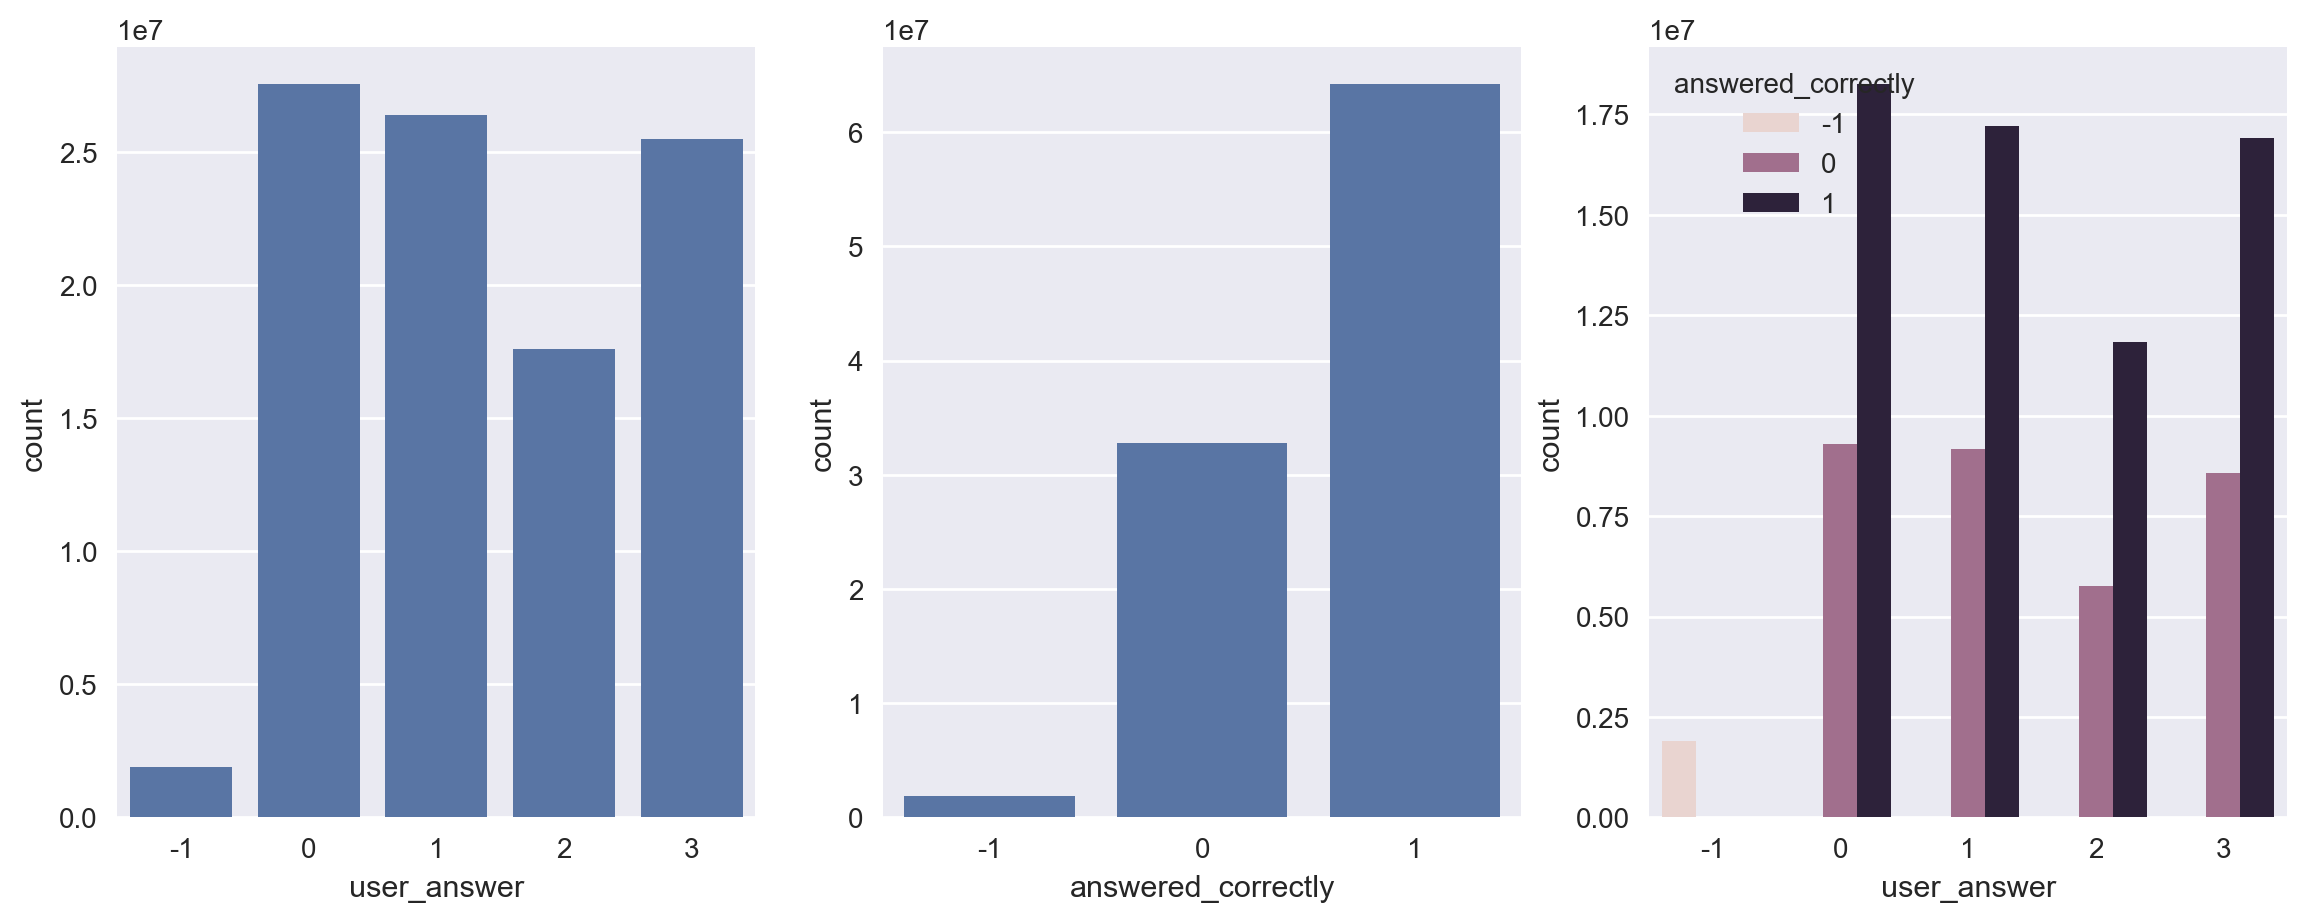

In [14]:
fig = plt.figure(figsize=(14,5))

plt.subplot(1, 3, 1)
sns.countplot(x='user_answer',data=df)

plt.subplot(1, 3, 2)
sns.countplot(x='answered_correctly',data=df)

plt.subplot(1, 3, 3)
sns.countplot(x='user_answer',hue='answered_correctly',data=df)

plt.show()

**Выводы:**
- это категориальные признаки
- выделяется значение признака `user_answer` равное 2 - пользователи реже выбирали данный вариант ответа
- при выборе любого ответа, как и в целом, пользователи почти в 2 раза чаще отвечали правильно

### 4.7. Признак `prior_question_elapsed_time`

`prior_question_elapsed_time`: (**float32**) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.    
Среднее время в миллисекундах, которое потребовалось пользователю, чтобы ответить на каждый вопрос в текущем пакете вопросов, без учета всех лекций между ними. Является null для первого пакета вопросов или лекции пользователя. 

Получим статистические данные признака.

In [21]:
df[["prior_question_elapsed_time"]].describe()

,prior_question_elapsed_time
count,9.887879e+07
mean,2.542381e+04
std,1.994815e+04
min,0.000000e+00
25%,1.600000e+04
50%,2.100000e+04
75%,2.966600e+04
max,3.000000e+05


Визуализируем распределение признака.

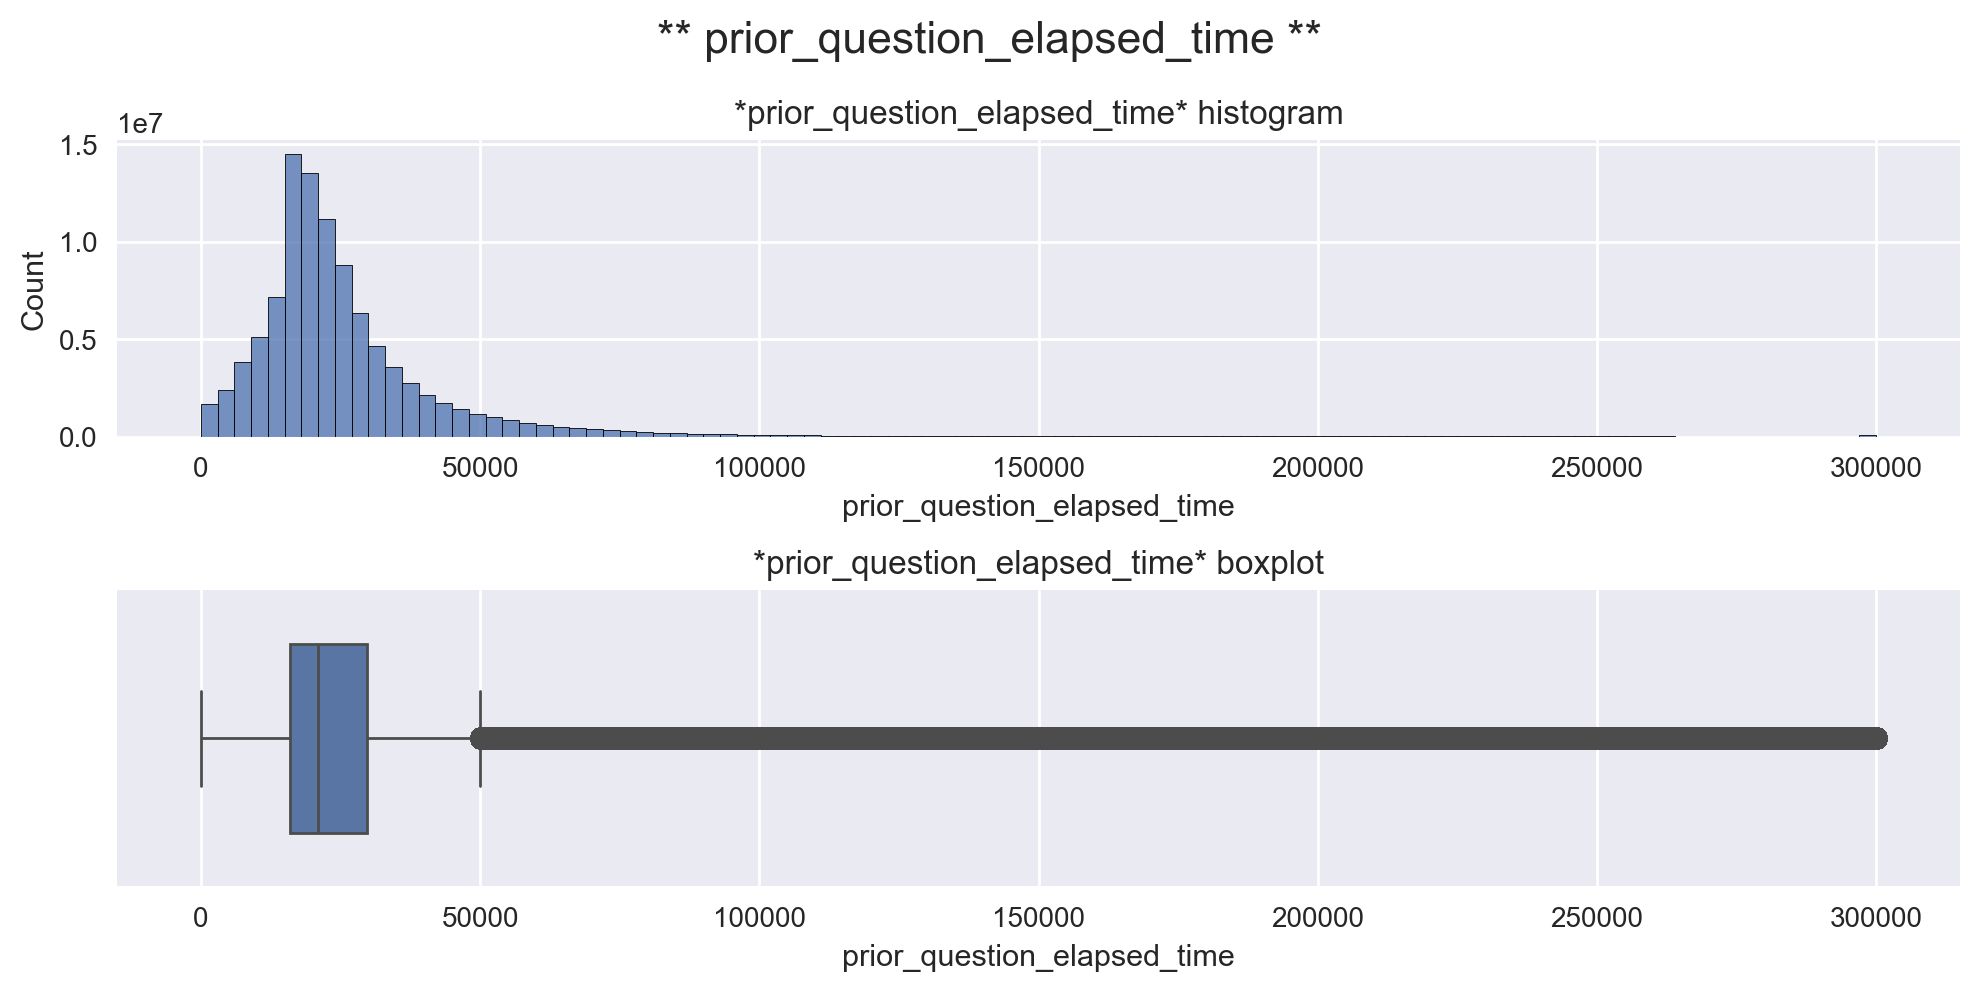

In [22]:
# задаем фигуру и ее заголовок
fig = plt.figure(figsize=(10,5))
fig.suptitle("** prior_question_elapsed_time **", fontsize=16)

# первый график - гистограмма
plt.subplot(2, 1, 1)
histogram = sns.histplot(data=df, x='prior_question_elapsed_time', bins=100) # график
histogram.set_title('*prior_question_elapsed_time* histogram') # подпись графика

# второй график - ящик с усами
plt.subplot(2, 1, 2)
boxplot = sns.boxplot(data=df, x='prior_question_elapsed_time', gap = .2) # график, gap - промежуток м/ду коробками
boxplot.set(title='*prior_question_elapsed_time* boxplot', ylabel='') # подпись графика

plt.tight_layout() # промежуток между диаграммами
plt.show()

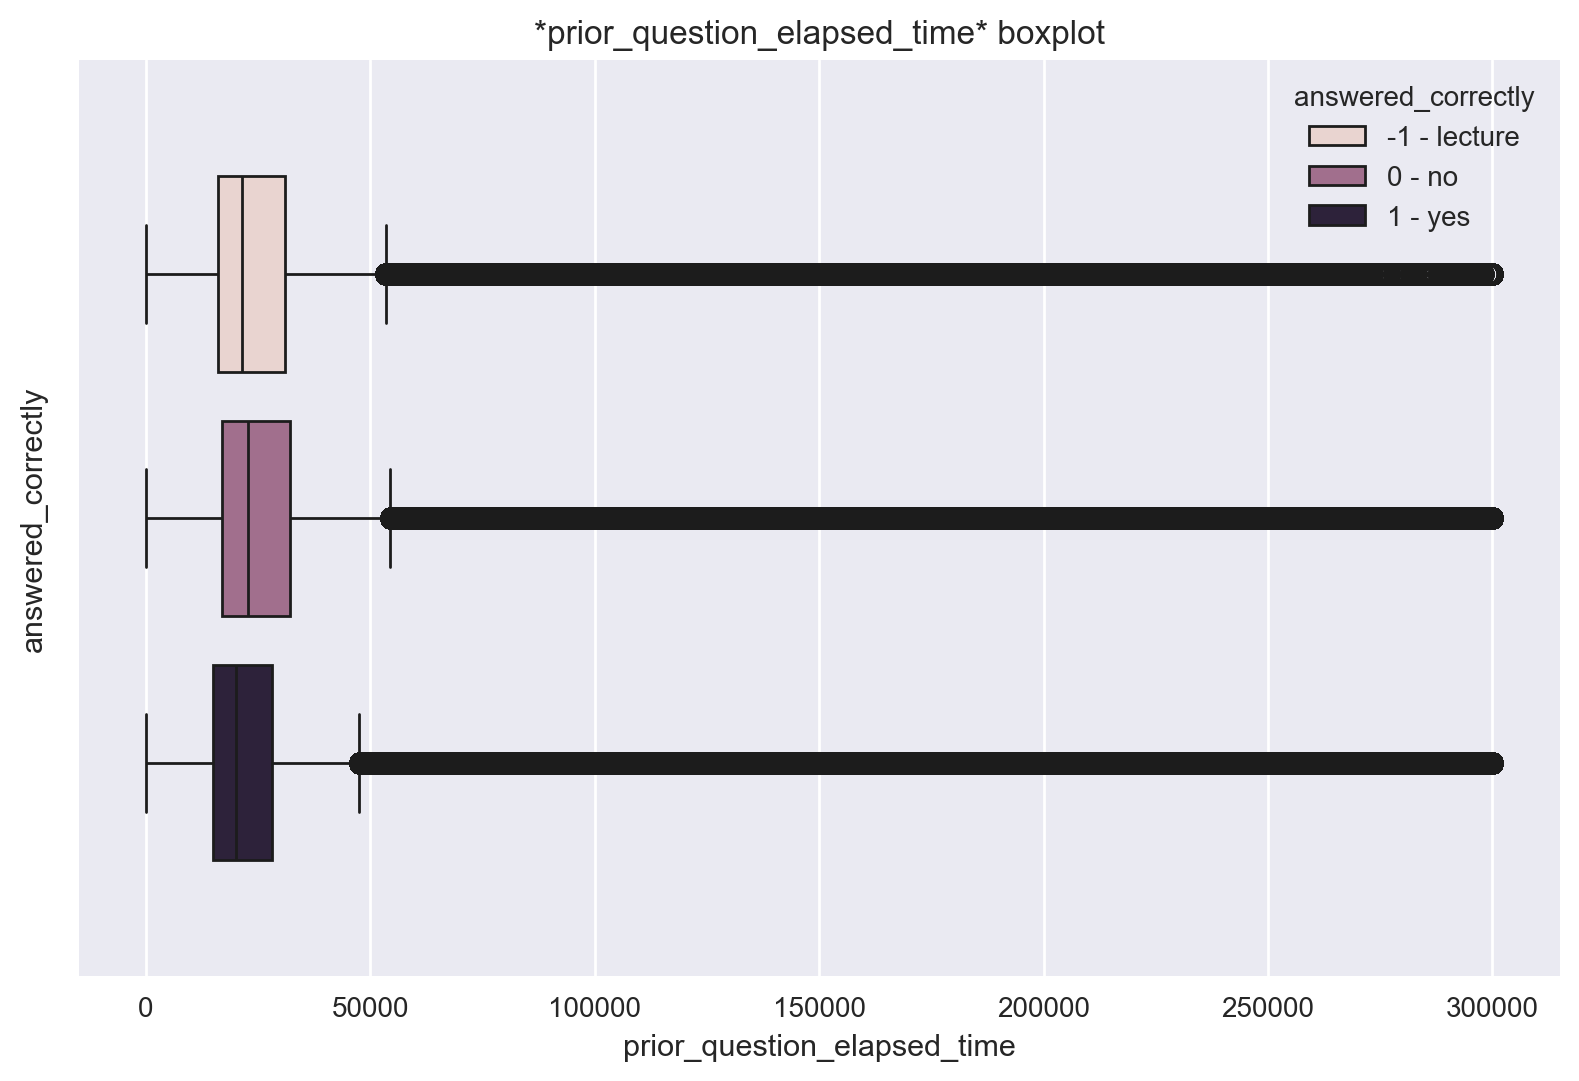

In [23]:
boxplot = sns.boxplot(data=df, x='prior_question_elapsed_time', hue="answered_correctly", gap = .2) # график, gap - промежуток м/ду коробками
boxplot.set(title='*prior_question_elapsed_time* boxplot', ylabel='answered_correctly') # подпись графика

plt.tight_layout() # промежуток между диаграммами
plt.legend(title='answered_correctly', labels=["-1 - lecture","0 - no","1 - yes"]) # легенда
plt.show()

Распределение признака в разрезе признака `user_answer`

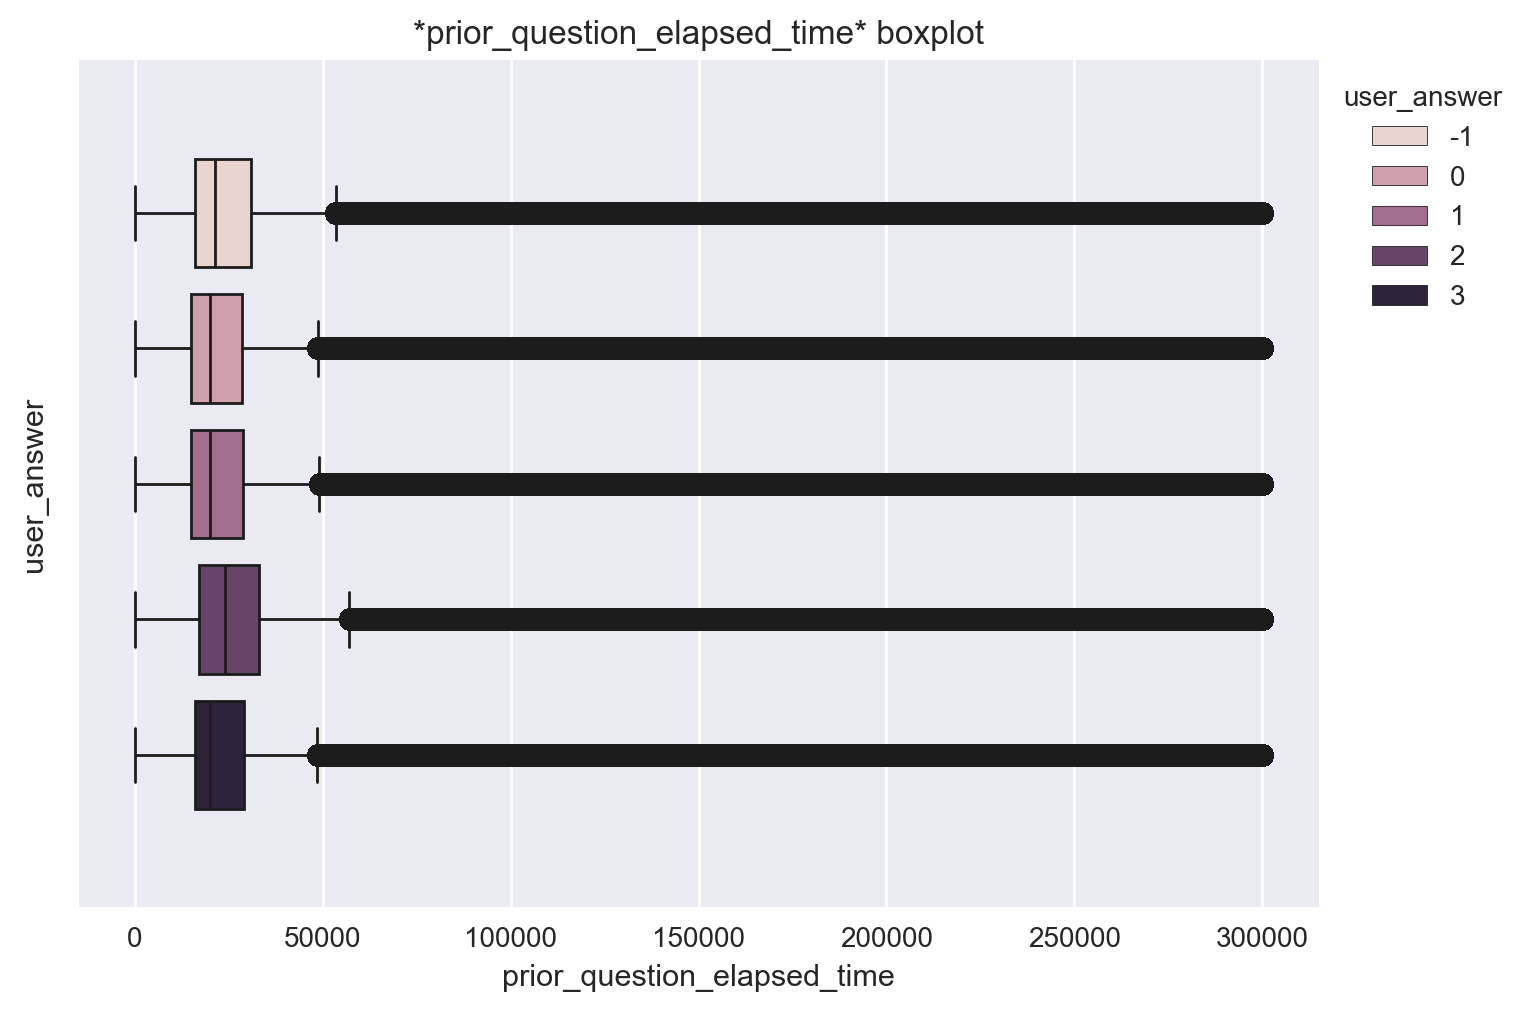

In [24]:
boxplot = sns.boxplot(data=df, x='prior_question_elapsed_time', hue="user_answer", gap = .2) # график, gap - промежуток м/ду коробками
boxplot.set(title='*prior_question_elapsed_time* boxplot', ylabel='user_answer') # подпись графика

plt.legend(title = "user_answer", loc='upper left', bbox_to_anchor=(1, 1)) # легенда
plt.show()

**Выводы:**
- признак числовой
- емеются выбросы выше значения, примерно, 50000. Распределение левее уровня выбросов близко к нормальному.
- существенной разницы в распределении признака в разрезе `answered_correctly` и `user_answer` нет. Хотя, можно отметить, что при правильном ответе IQR несколько меньше. Возможно, пользователь часто сразу знает правильный ответ и тратит меньше времени на данный вопрос.

### 4.8. Признак `prior_question_had_explanation`

`prior_question_had_explanation`: (**bool**) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.    
Увидел ли пользователь объяснение и правильный ответ (ответы) после ответа на текущий пакет вопросов, игнорируя все лекции между ними. 

Получим статистические данные признака.

In [25]:
df[["prior_question_had_explanation"]].describe()

,prior_question_had_explanation
count,98878793
unique,2
top,True
freq,89685560


Визуализируем данные, в т.ч. в разрезе признаков `answered_correctly` и `user_answer`

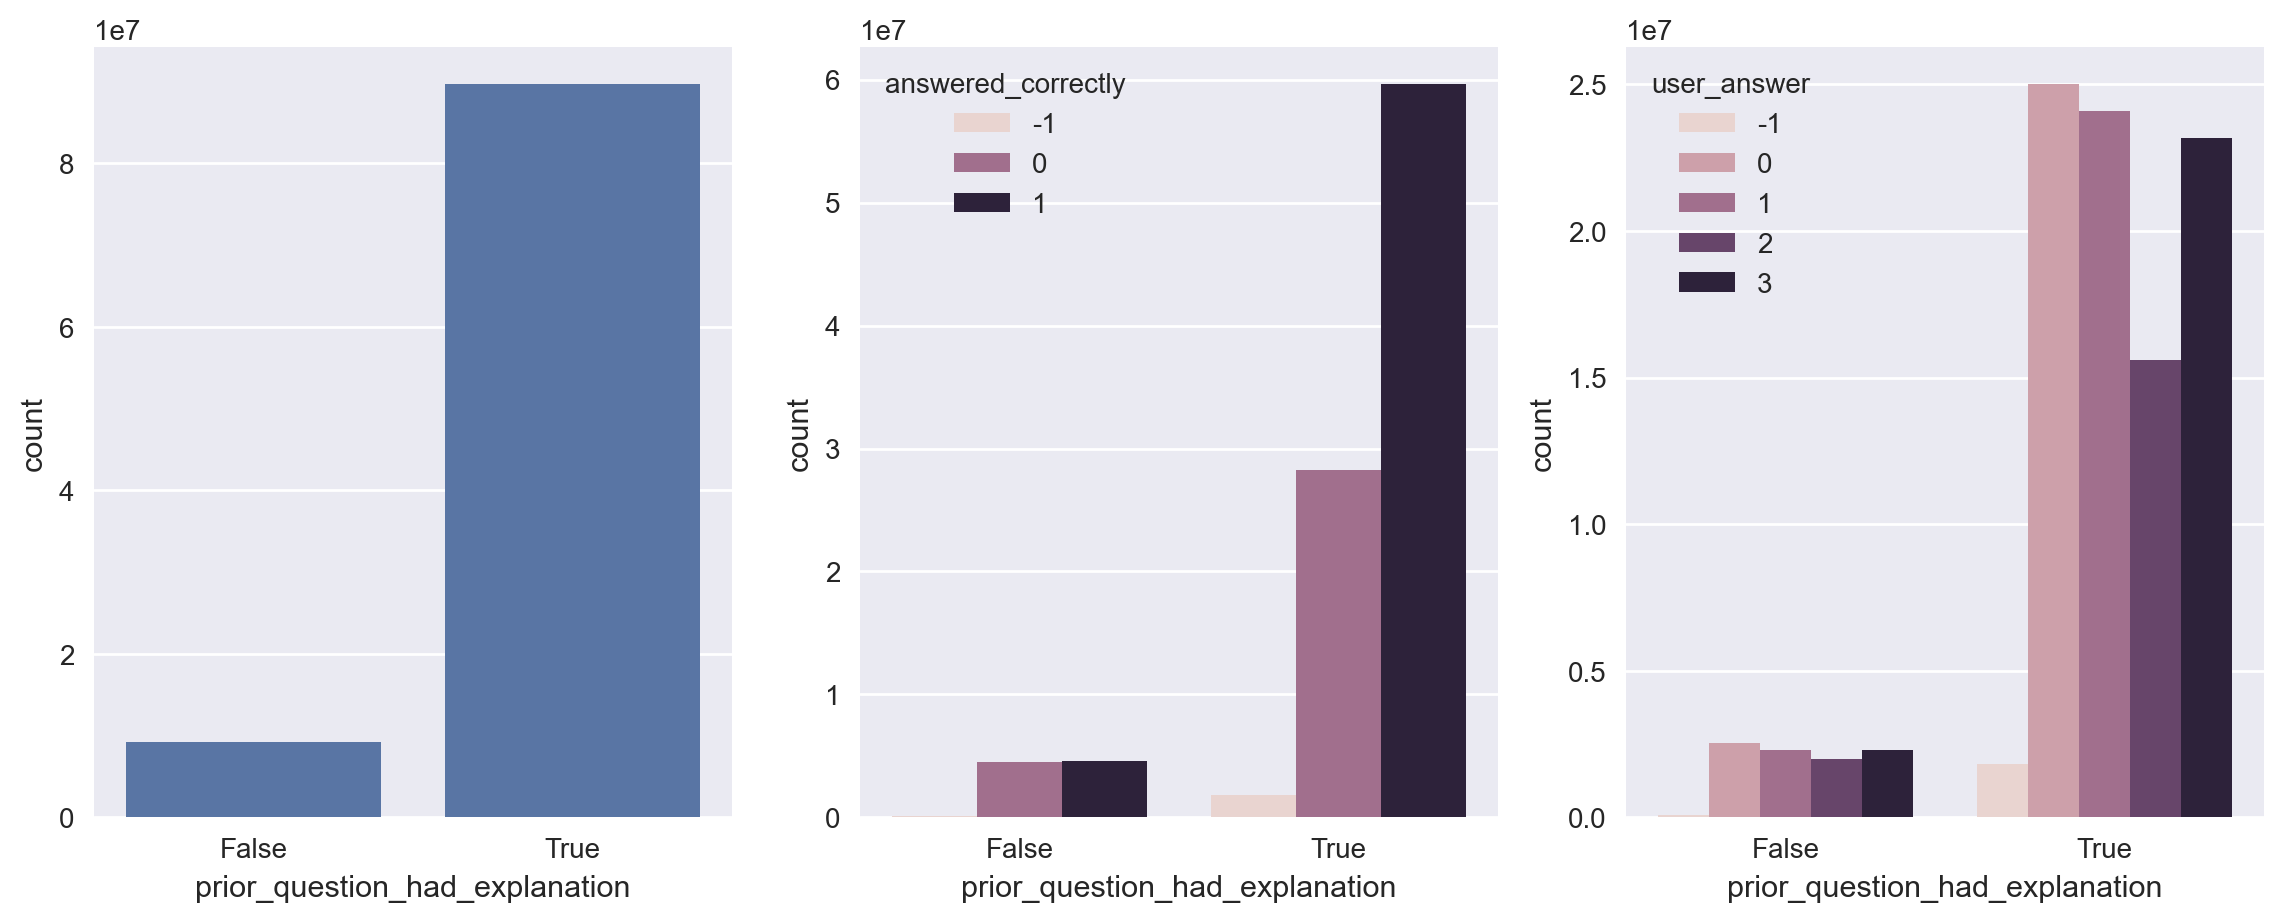

In [4]:
fig = plt.figure(figsize=(14,5))

plt.subplot(1, 3, 1)
sns.countplot(x='prior_question_had_explanation',data=df)

plt.subplot(1, 3, 2)
sns.countplot(x='prior_question_had_explanation', hue='answered_correctly', data=df)

plt.subplot(1, 3, 3)
sns.countplot(x='prior_question_had_explanation',hue='user_answer',data=df)

plt.show()

**Выводы:**
- пользователь в подавляющем большинстве случаев видел правильный ответ после текущего пакета вопросов.
- если пользователь не видел правильного ответа, то это особо не имело связи с тем, правильно ли он ответил на вопрос или нет и какой ответ он выбрал.

### 4.9. Признаки `q_correct_answer`, `q_part`, `q_tags`

- `q_correct_answer`: the answer to the question. Can be compared with the train user_answer column to check if the user was right.    
Ответ на вопрос. Можно сравнить с колонкой **train** *user_answer*, чтобы проверить, правильно ли ответил пользователь.
- `q_part`: the relevant section of the TOEIC test.     
Cоответствующий раздел теста TOEIC.
- `q_tags`: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.     
Один или несколько подробных кодов тегов для вопроса. Смысл тегов не сообщается, но этих кодов достаточно для объединения вопросов в кластеры.

In [14]:
# маска для фильтрации по значению content_type_id	= 0 - "вопрос"
mask_q = df["content_type_id"] == 0

Для дополнительного анализа.

In [6]:
df[["q_correct_answer","q_part"]].describe()

,q_correct_answer,q_part
count,9.697876e+07,9.697876e+07
mean,1.440766e+00,4.082793e+00
std,1.153922e+00,1.671248e+00
min,0.000000e+00,1.000000e+00
25%,0.000000e+00,2.000000e+00
50%,1.000000e+00,5.000000e+00
75%,3.000000e+00,5.000000e+00
max,3.000000e+00,7.000000e+00


In [7]:
df["q_tags"].describe(include=object)

count     96978759
unique        1519
top             73
freq       3003940
Name: q_tags, dtype: object

Признак `q_tags` содержит теги, причем их количество различно.

In [15]:
# разбиваем str каждого значения tags по пробелам и вычисляем длину полученного списка
tag_len = df[mask_q]["q_tags"].apply(lambda x: len(x.split(" ")))
# изучим количество каждого уникального значения длины (кол-ва цифр) признака
tag_len.value_counts(ascending=False, normalize=True)

q_tags
1    0.487174
3    0.215189
4    0.170583
5    0.087481
2    0.029870
6    0.009704
Name: proportion, dtype: float64

Почти половина вопросов идут под одним тегом, но есть вопросы с кол-ом тегов от 2 до 6.

Оставим в полученном Series длину тегов равную 1 (значение 1) и более одного (значение 2).

In [19]:
tag_len = tag_len.apply(lambda x: 1 if x == 1 else 2)
tag_len.value_counts(normalize=True)

q_tags
2    0.512826
1    0.487174
Name: proportion, dtype: float64

Визуализируем признак `q_correct_answer`

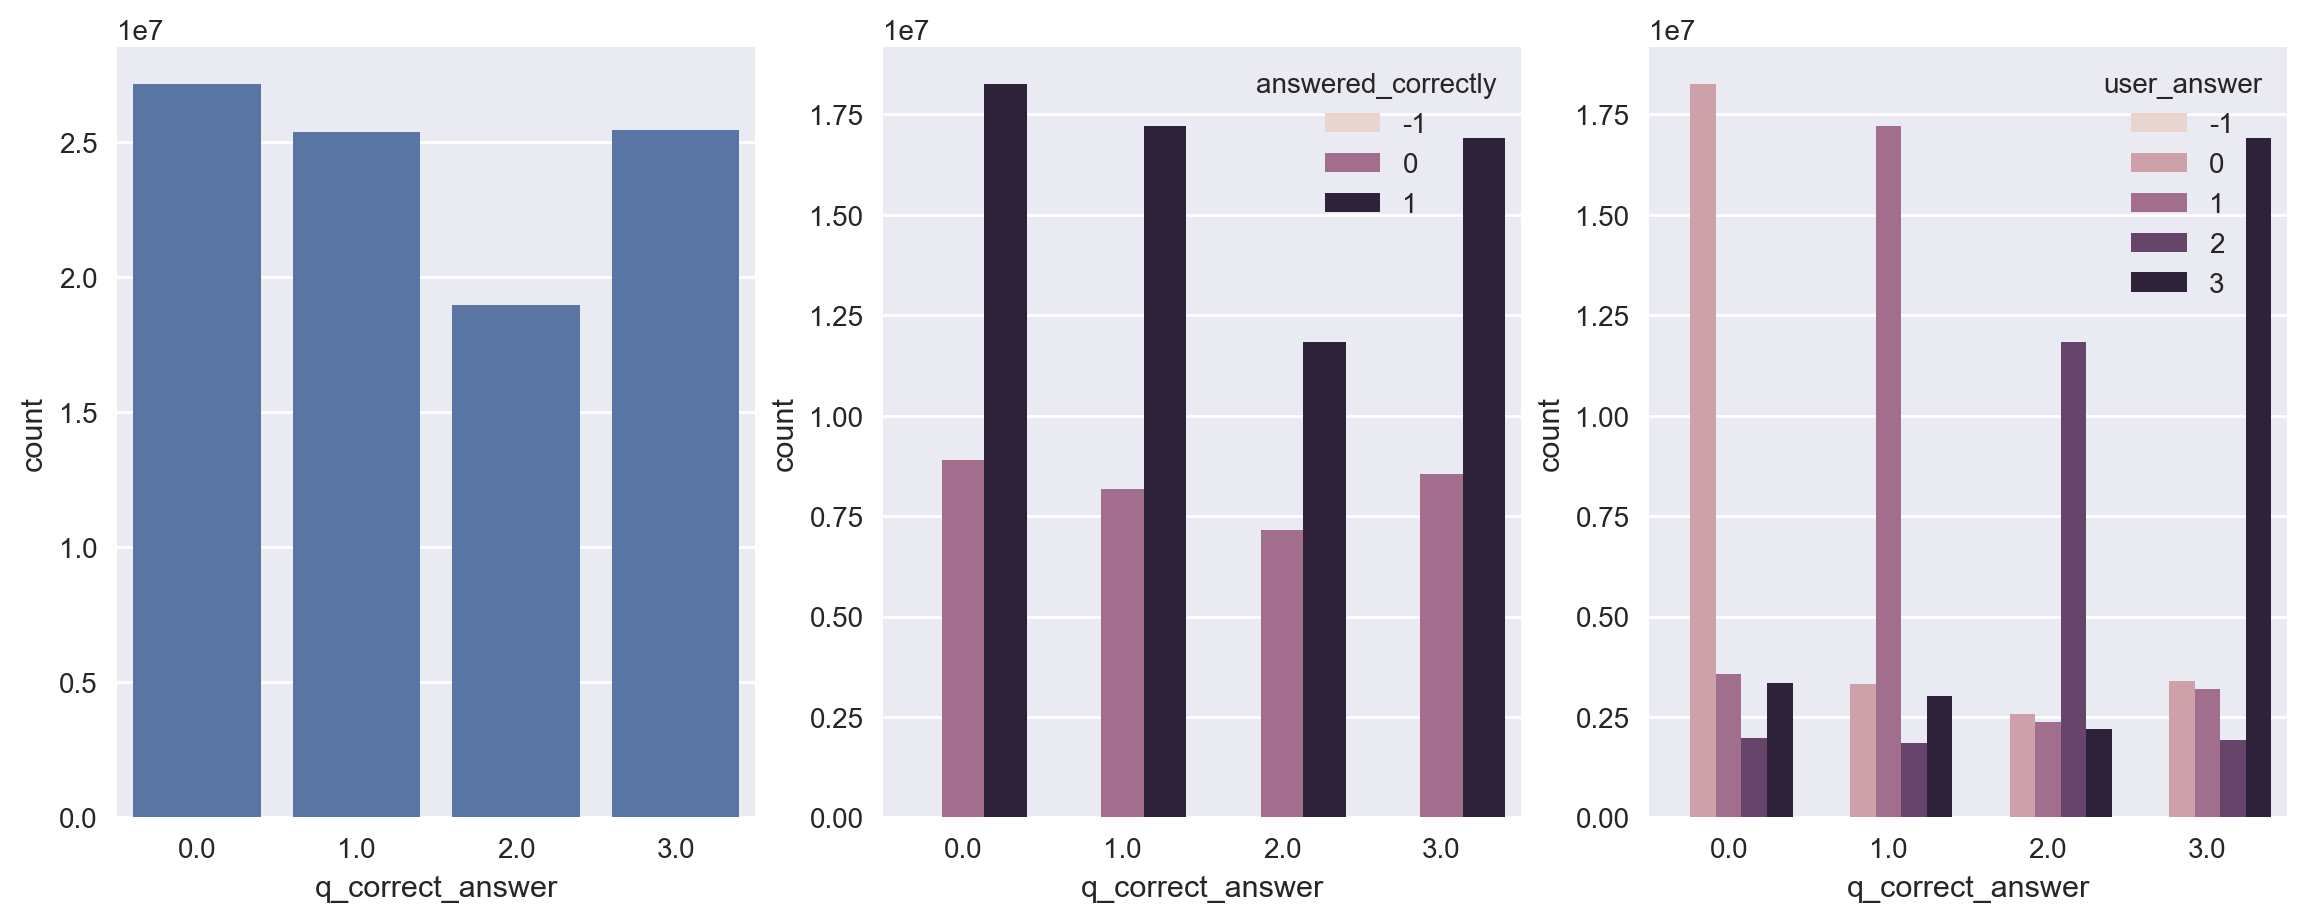

In [16]:
fig = plt.figure(figsize=(14,5))

plt.subplot(1, 3, 1)
sns.countplot(x='q_correct_answer',data=df)

plt.subplot(1, 3, 2)
sns.countplot(x='q_correct_answer', hue='answered_correctly', data=df)

plt.subplot(1, 3, 3)
sns.countplot(x='q_correct_answer',hue='user_answer',data=df)

plt.show()

Визуализируем признак `q_part`

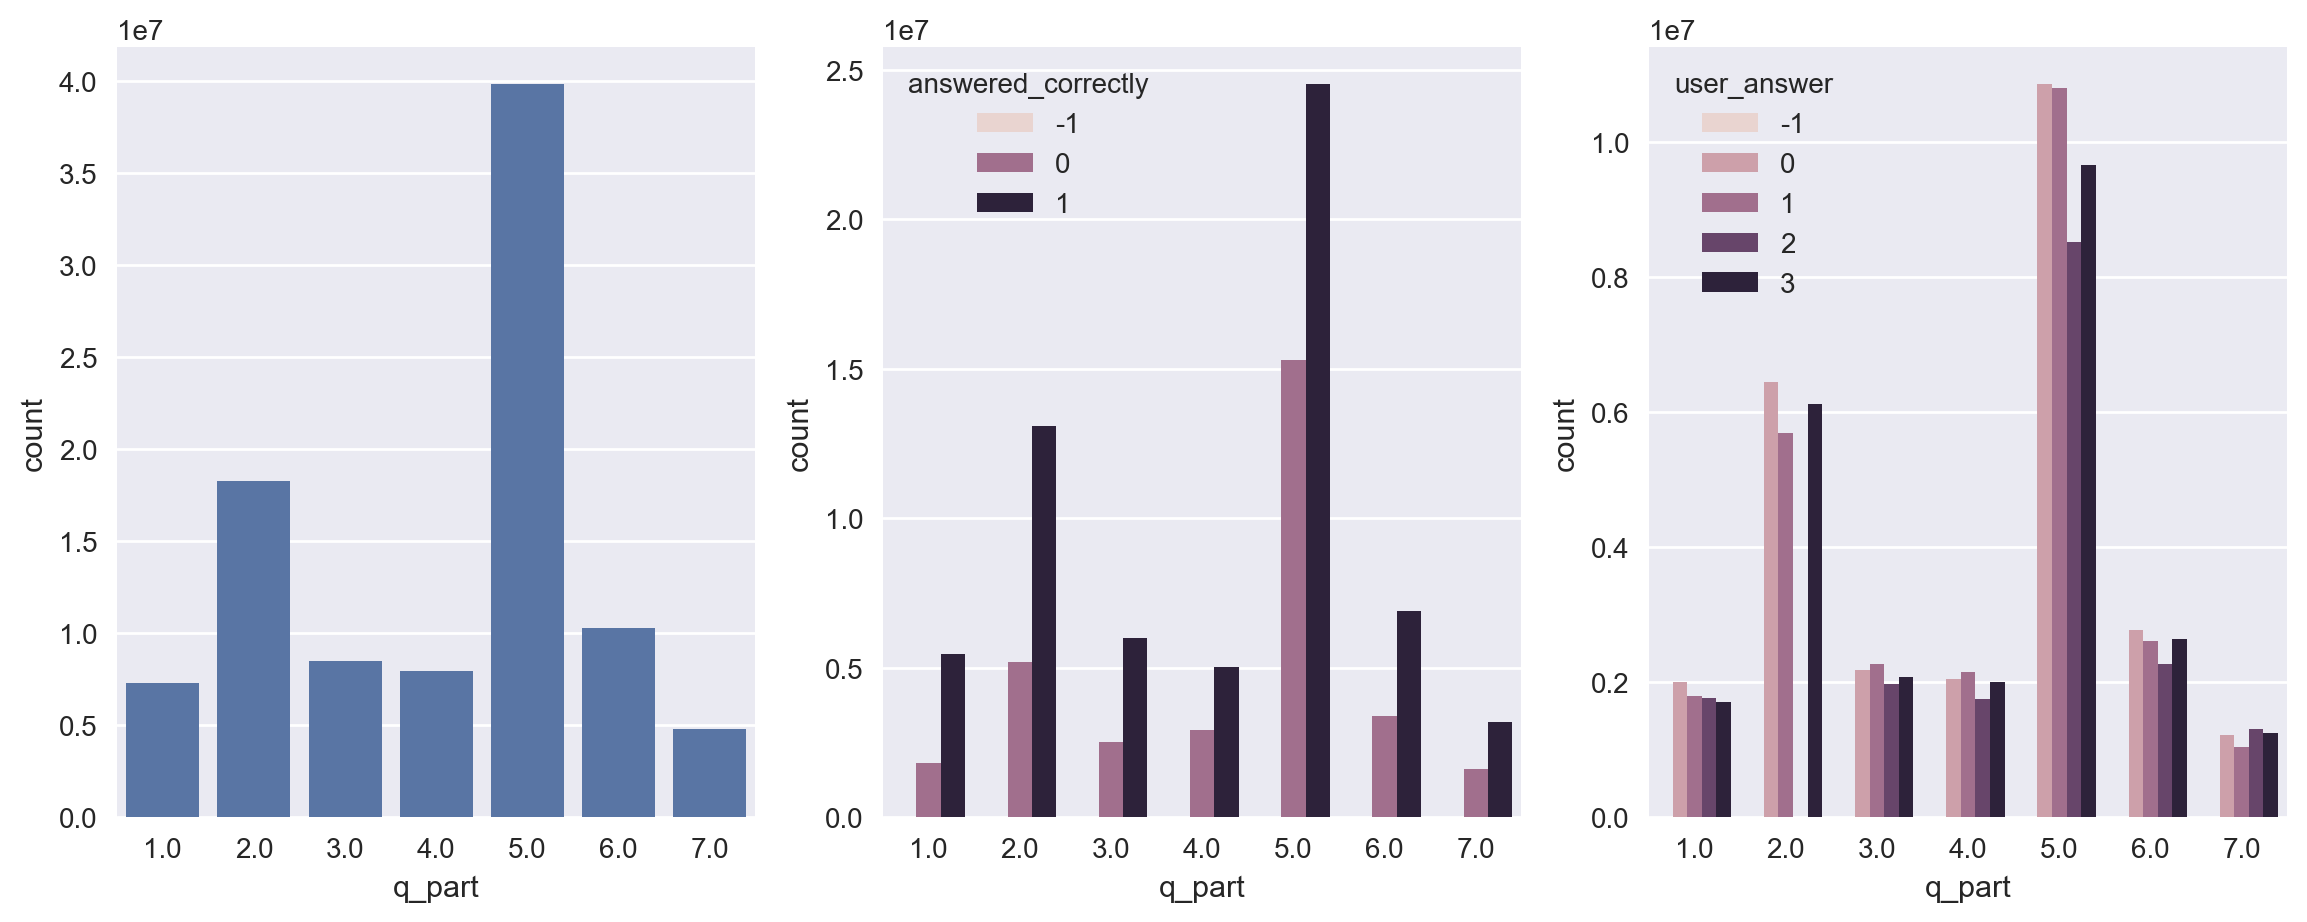

In [17]:
fig = plt.figure(figsize=(14,5))

plt.subplot(1, 3, 1)
sns.countplot(x='q_part',data=df)

plt.subplot(1, 3, 2)
sns.countplot(x='q_part', hue='answered_correctly', data=df)

plt.subplot(1, 3, 3)
sns.countplot(x='q_part',hue='user_answer',data=df)

plt.show()

Интересно, что во 2-м разделе теста TOEIC пользователи не выбирали ответ 2.

In [18]:
df[df["q_part"] == 2.0]["q_correct_answer"].value_counts()

q_correct_answer
0.0    6459395
3.0    6021091
1.0    5788886
Name: count, dtype: int64

Потому, что правильного ответа под номером 2 там нет.

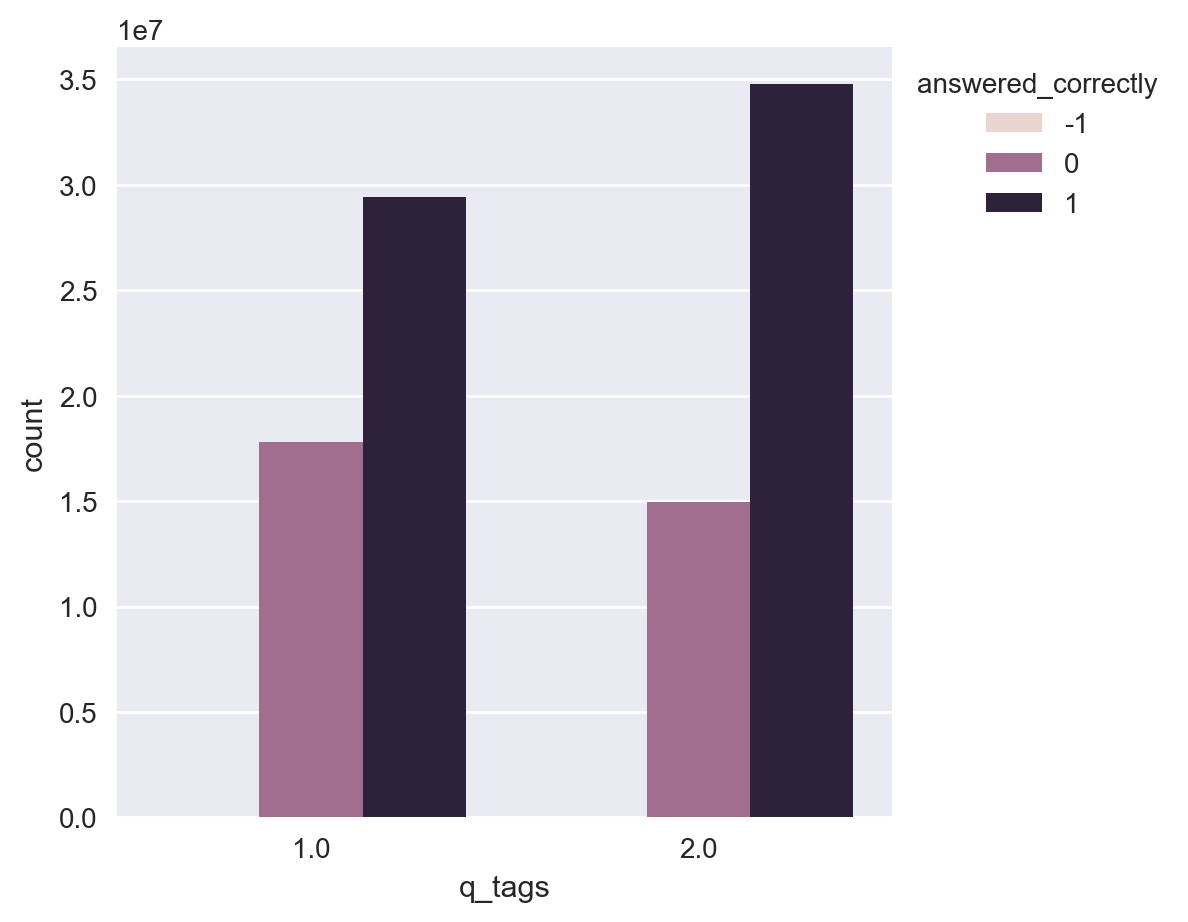

In [23]:
fig = plt.figure(figsize=(5,5))

sns.countplot(x=tag_len, hue='answered_correctly', data=df)

plt.legend(title ="answered_correctly", loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

**Выводы:**
- все 3 признака являются категориальными
- чуть менее половины вопросов - с 1 тегом, чуть более половины - с 2-6 тегами
- в разделе 2 теста TOEIC нет правильного ответа под номером 2
- все-же вопросы с 1-м тегом чаще вызывали затруднения у пользователей, чем вопросы с большим количеством тегов

### 4.10. Признаки `l_tag`, `l_part`, `l_type_of`

- `l_part`: top level category code for the lecture.    
Код категории верхнего уровня для лекции.
- `_tag`: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.    
Один код тега для лекции. Смысл тегов не приводится, но этих кодов достаточно для группировки лекций.
- `l_type_of`: brief description of the core purpose of the lecture.    
Краткое описание основной цели лекции.

In [24]:
# маска для фильтрации по значению content_type_id	= 1 - "лекция"
mask_l = df["content_type_id"] == 1

Для дополнительного анализа.

In [27]:
df[mask_l][["l_part","l_tag"]].describe()

,l_part,l_tag
count,1.900034e+06,1.900034e+06
mean,4.073454e+00,9.108059e+01
std,1.666499e+00,5.434053e+01
min,1.000000e+00,0.000000e+00
25%,2.000000e+00,4.700000e+01
50%,5.000000e+00,8.500000e+01
75%,5.000000e+00,1.360000e+02
max,7.000000e+00,1.870000e+02


In [26]:
df[mask_l][["l_type_of"]].describe(include=object)

,l_type_of
count,1900034
unique,4
top,concept
freq,1368512


Выведем наиболее часто встречающиеся теги.

In [31]:
df.l_tag.value_counts().iloc[:10]

l_tag
62.0     58500
27.0     50306
163.0    40566
136.0    40164
26.0     37268
161.0    36547
170.0    33898
94.0     31387
1.0      30732
73.0     29728
Name: count, dtype: int64

Визуализируем признаки `l_part` и `l_type_of`

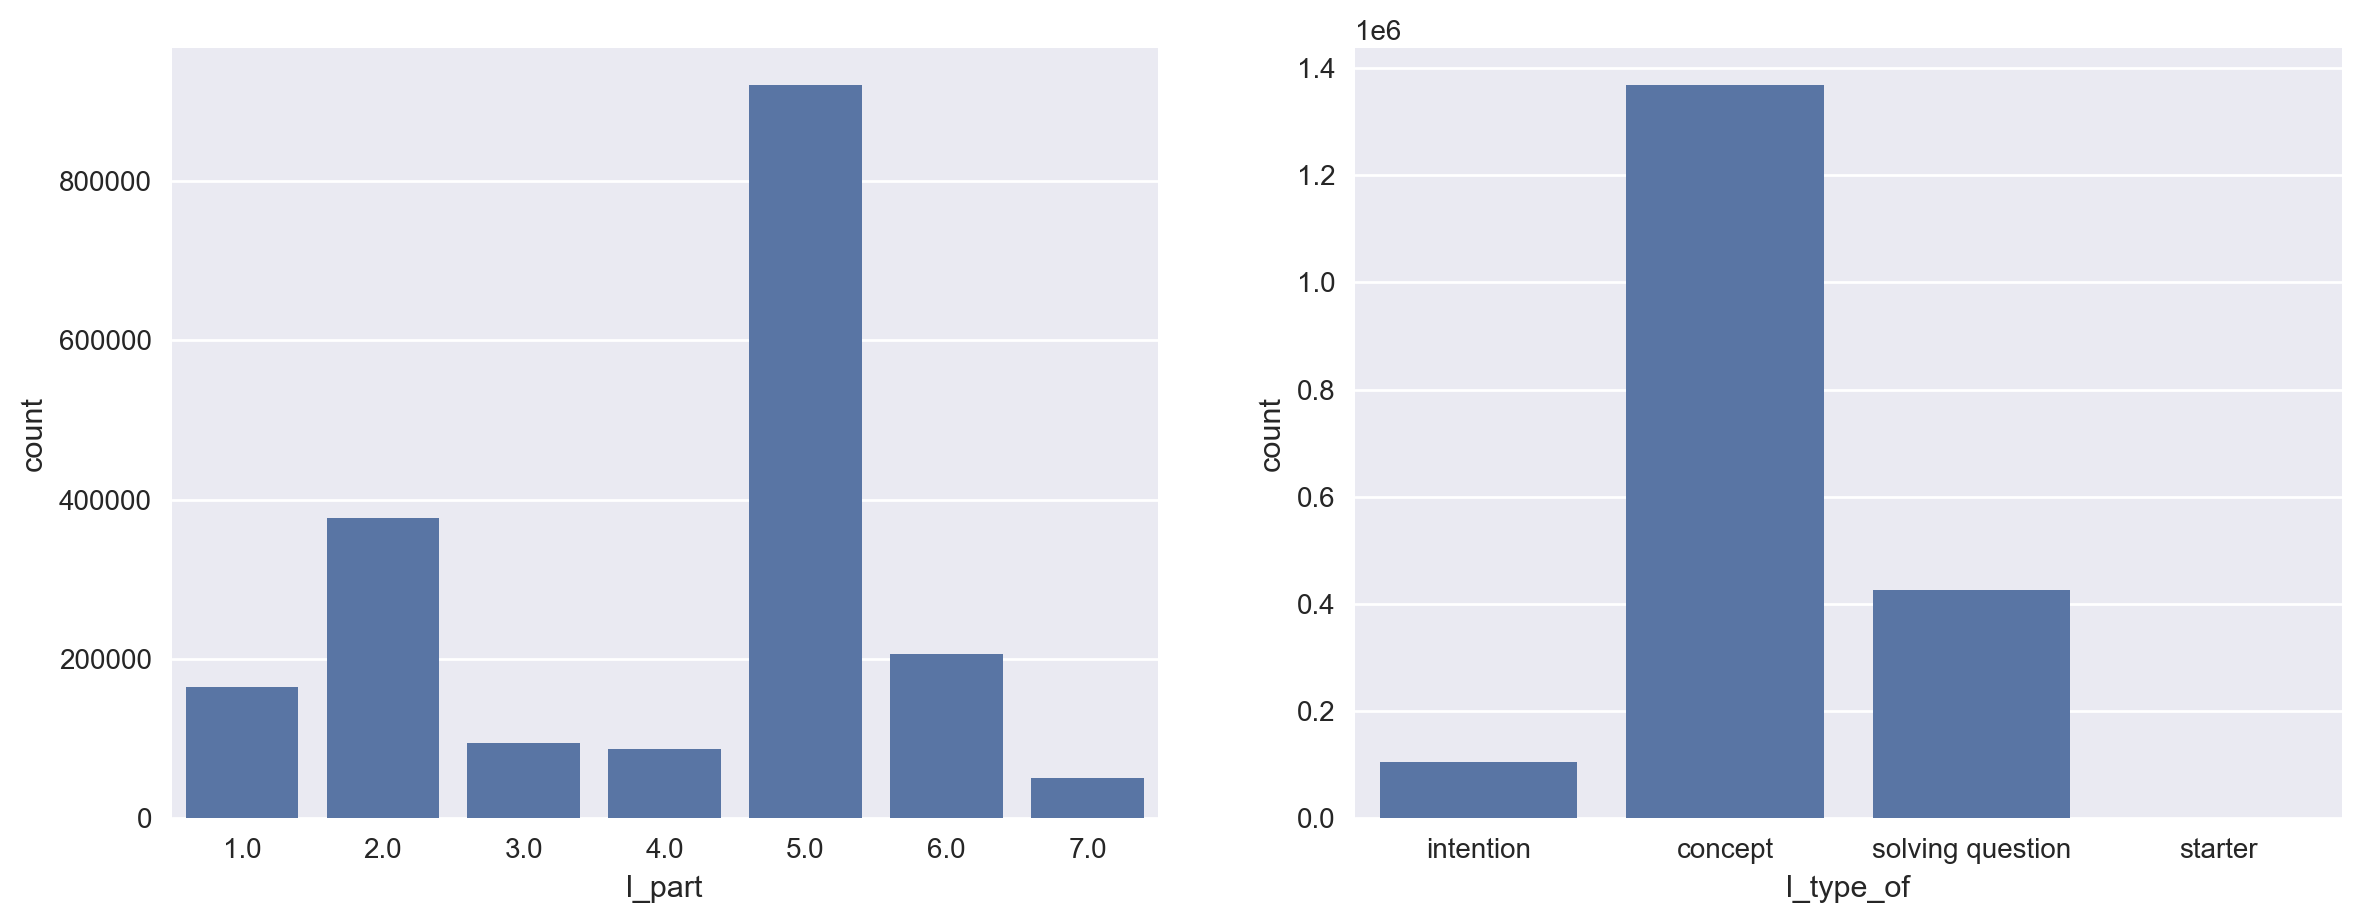

In [36]:
fig = plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
sns.countplot(x='l_part',data=df[mask_l])

plt.subplot(1, 2, 2)
sns.countplot(x='l_type_of', data=df[mask_l])

plt.show()

**Выводы:**
- наиболее частый код для лекции 5, наиболее редкий 7
- наиболее частая тема лекции concept, наиболее редкая starter

### 4.11. Успеваемость студентов

Рассмотрим только успеваемость в разрезе вопросов (`mask_q`).

In [16]:
# сгруппируем данные по user_id и answered_correctly, получив кол-во вопросов
# на которые был дан правильный ответ
g = df[mask_q][['user_id','answered_correctly']].groupby('user_id').sum().reset_index()
# то же, но получим общее кол-во вопросов
g_ = df[mask_q][['user_id','answered_correctly']].groupby('user_id').count().reset_index()

In [17]:
# получим процент успешного ответа на вопросы в разрезе пользователей

g['total']=g_['answered_correctly']
g['per']=np.round((g['answered_correctly']/g['total'])*100)
sort = g.sort_values('per',ascending=False)
sort.head()

,user_id,answered_correctly,total,per
7446,40916808,1,1,100.0
348832,1905136291,3,3,100.0
191291,1047583968,13,13,100.0
252380,1380231490,1,1,100.0
281032,1537337444,13,13,100.0


Выведем количество студентов в разрезе процента успеха при ответах на вопросы:
- процент успеха 76-100% (успешные студенты)

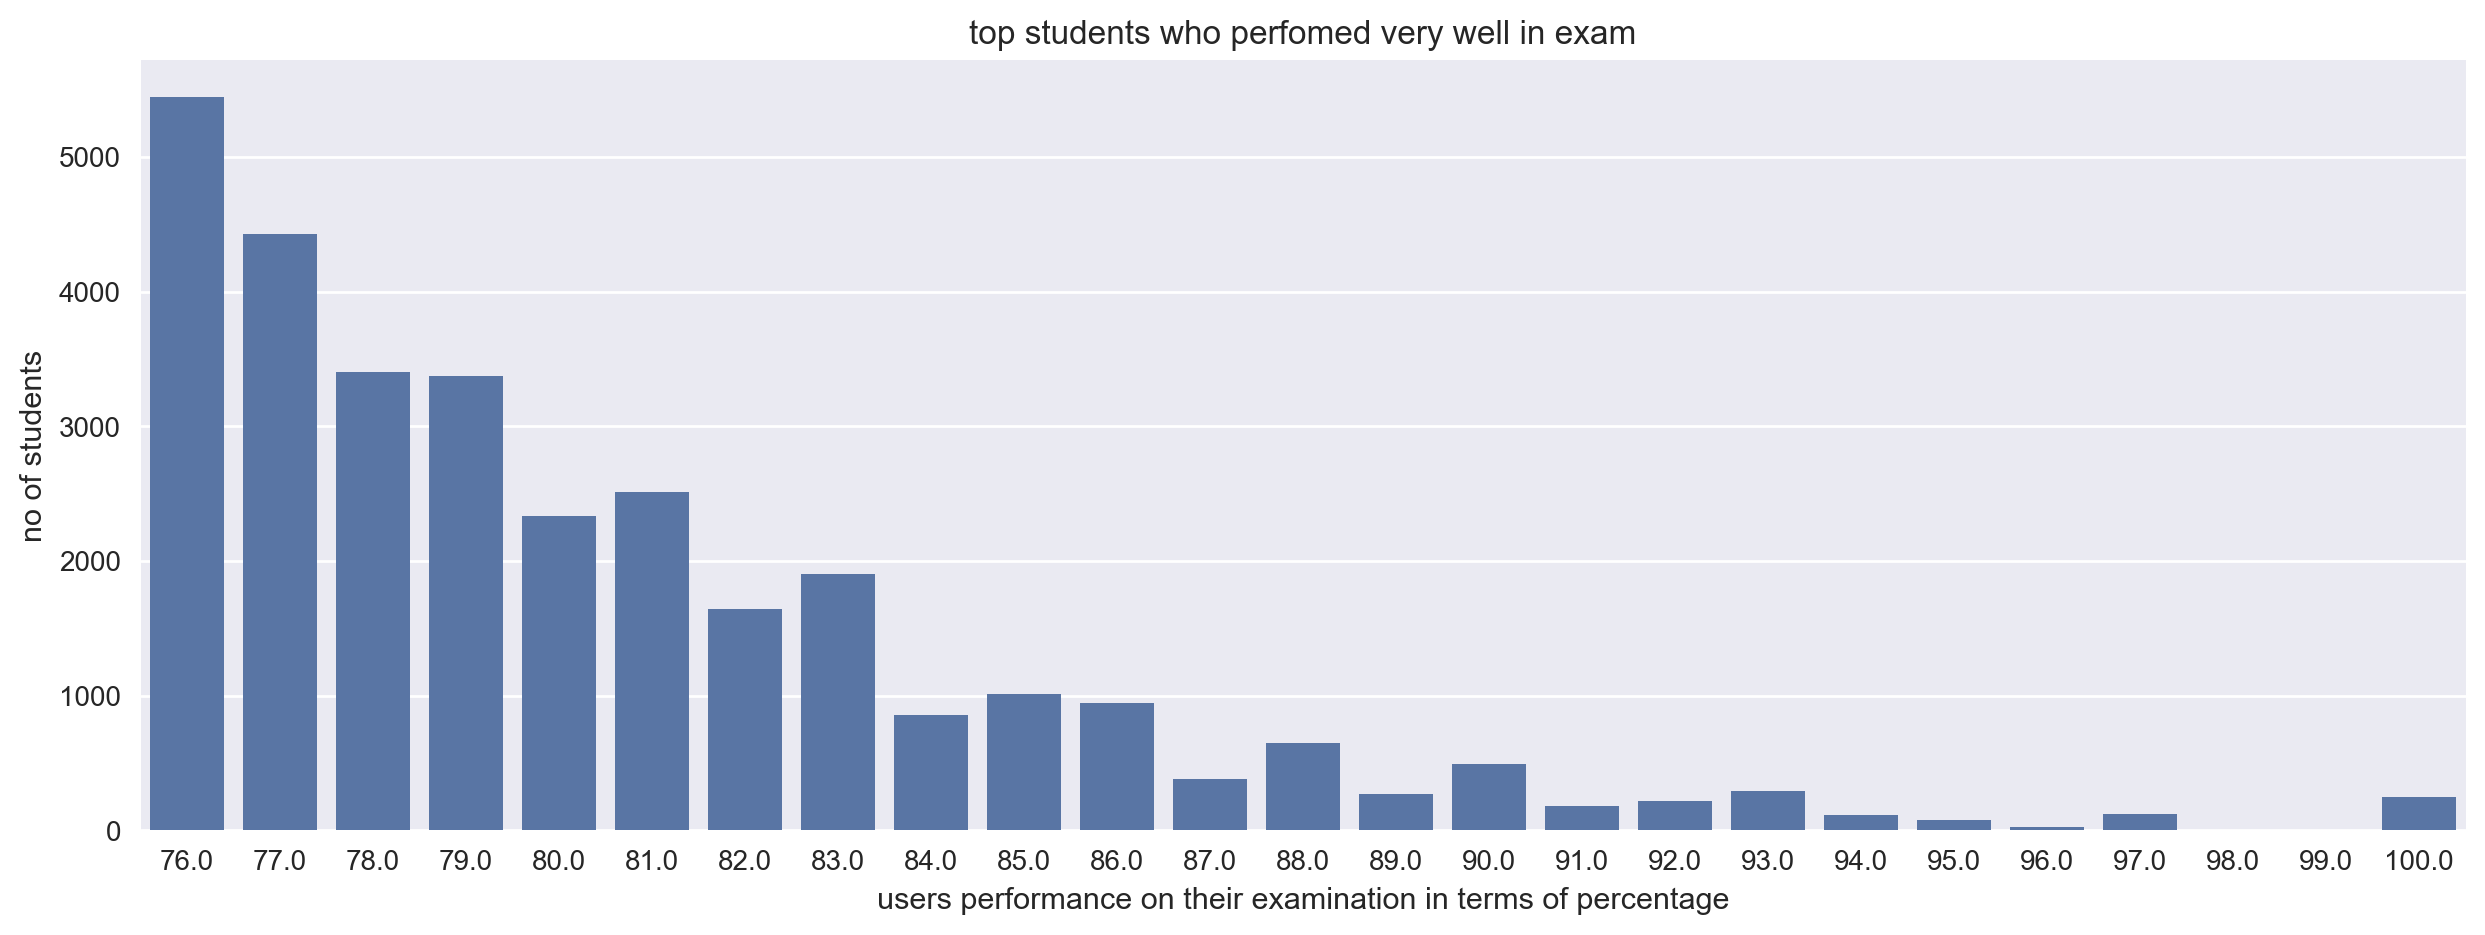

In [26]:
plt.figure(figsize=(15,5))
plt.xlabel('users performance on their examination in terms of percentage')
plt.ylabel('no of students')

per = g['per'].value_counts().sort_index(ascending=False)
sns.barplot(x=per.index[:25],y=per.values[:25].astype('int'))

plt.title('top students who perfomed very well in exam')
plt.show()

- процент успеха 0-25% (плохие студенты)

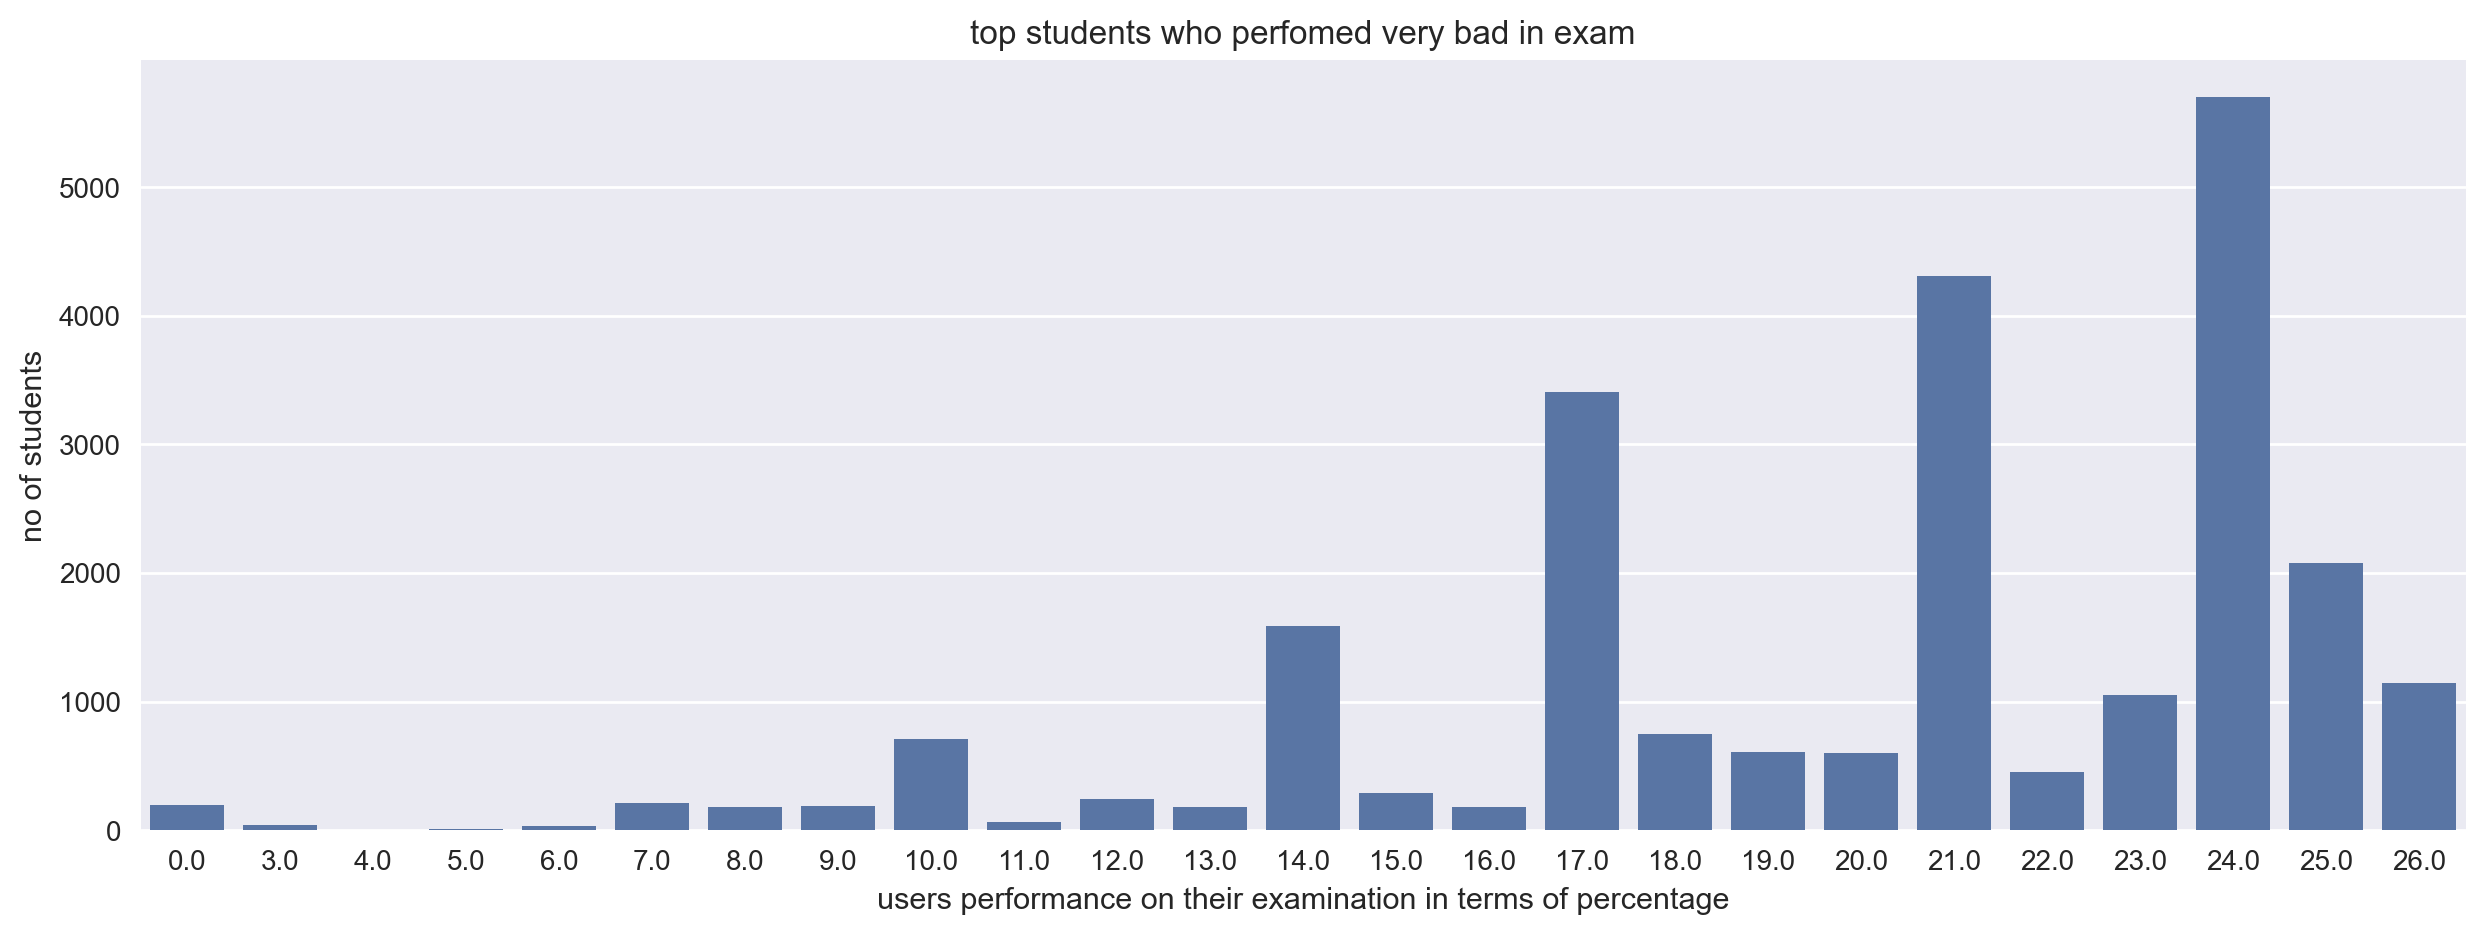

In [29]:
plt.figure(figsize=(15,5))
plt.xlabel('users performance on their examination in terms of percentage')
plt.ylabel('no of students')

per = g['per'].value_counts().sort_index(ascending=True)
sns.barplot(x=per.index[:25],y=per.values[:25].astype('int'))

plt.title('top students who perfomed very bad in exam')
plt.show()

- сколько процентов набирает основная масса студентов

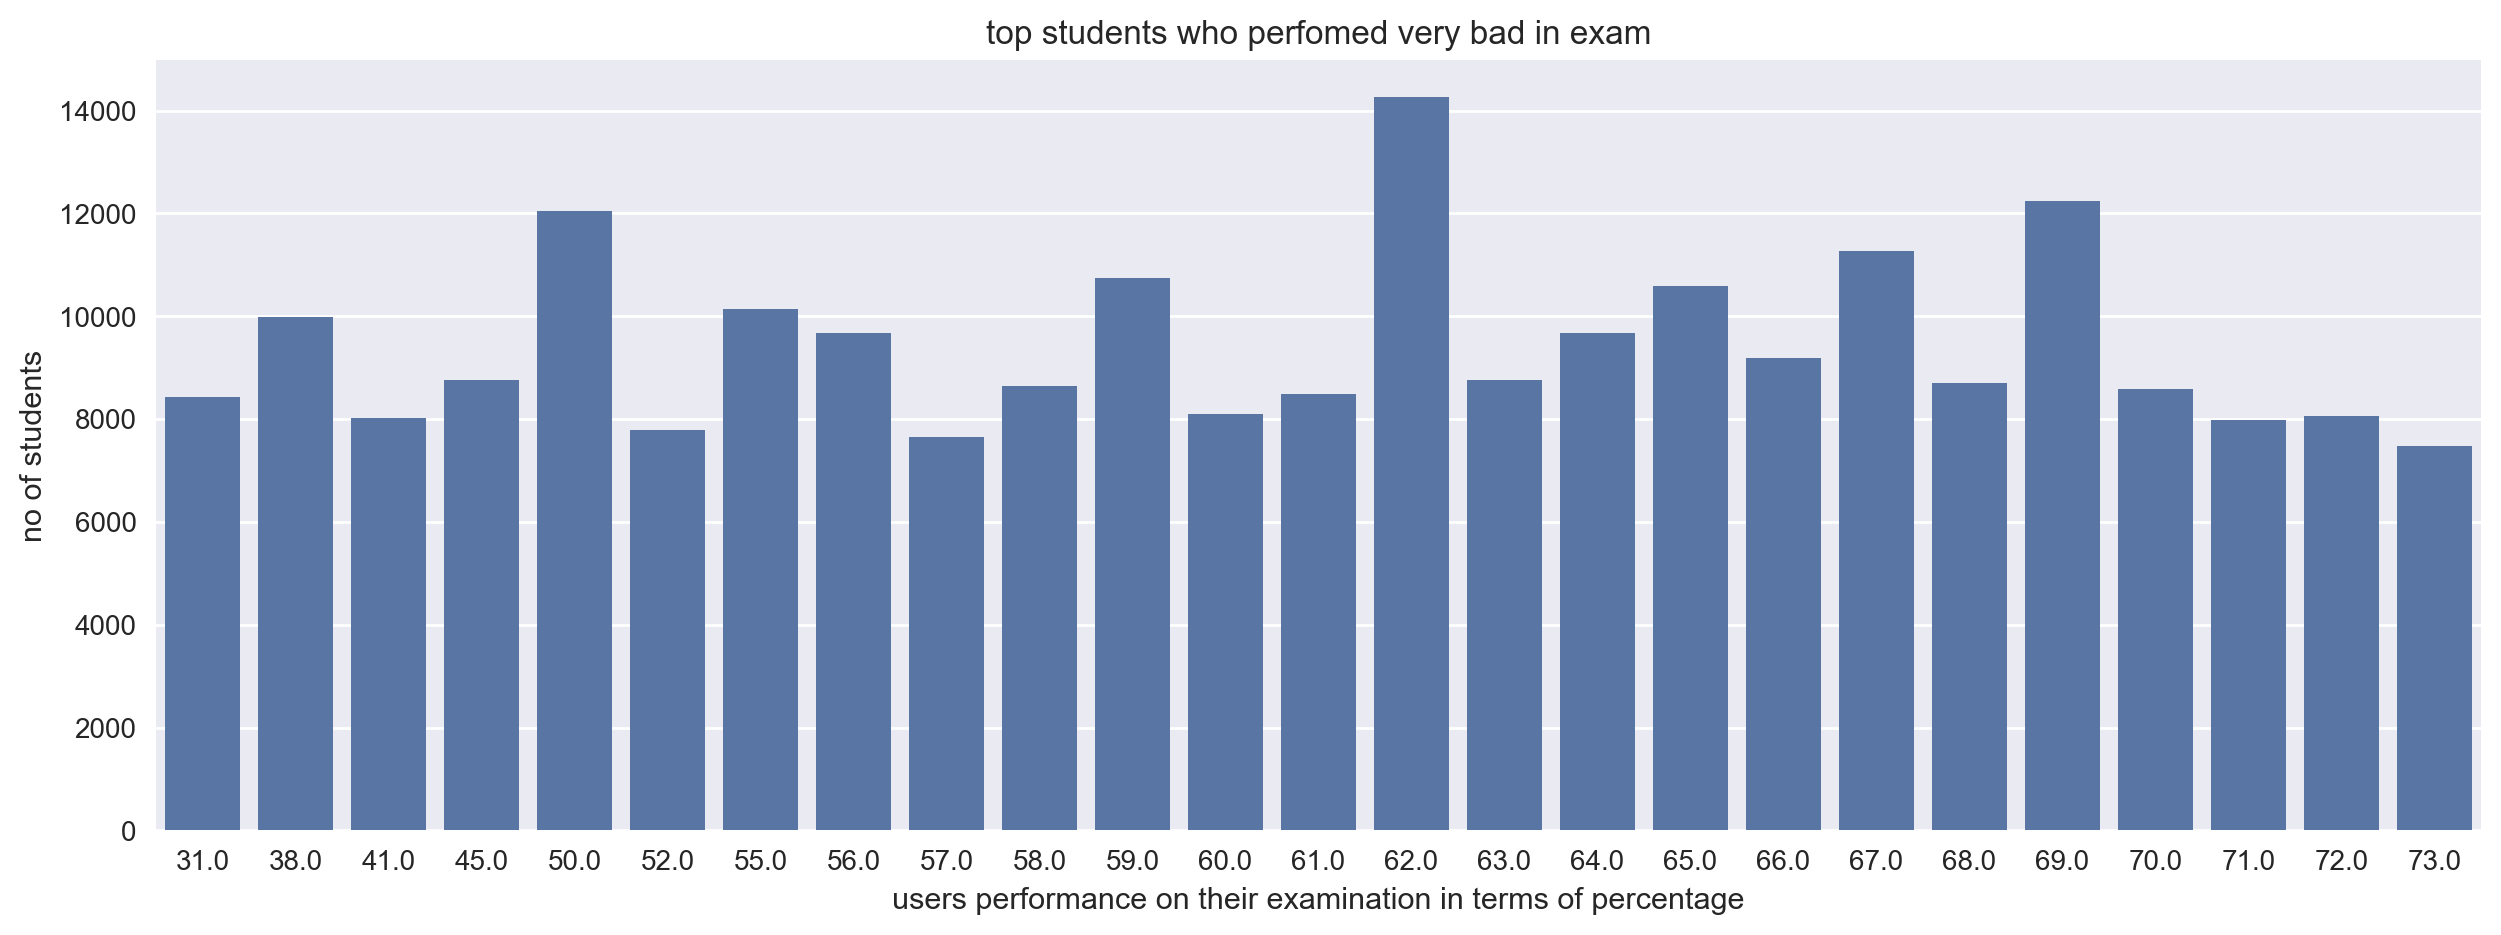

In [30]:
plt.figure(figsize=(15,5))
plt.xlabel('users performance on their examination in terms of percentage')
plt.ylabel('no of students')

per = g['per'].value_counts()
sns.barplot(x=per.index[:25],y=per.values[:25].astype('int'))

plt.title('top students who perfomed very bad in exam')
plt.show()

- теперь просмотрим кол-во всех студентов в разрезе процента успешного ответа на вопросы

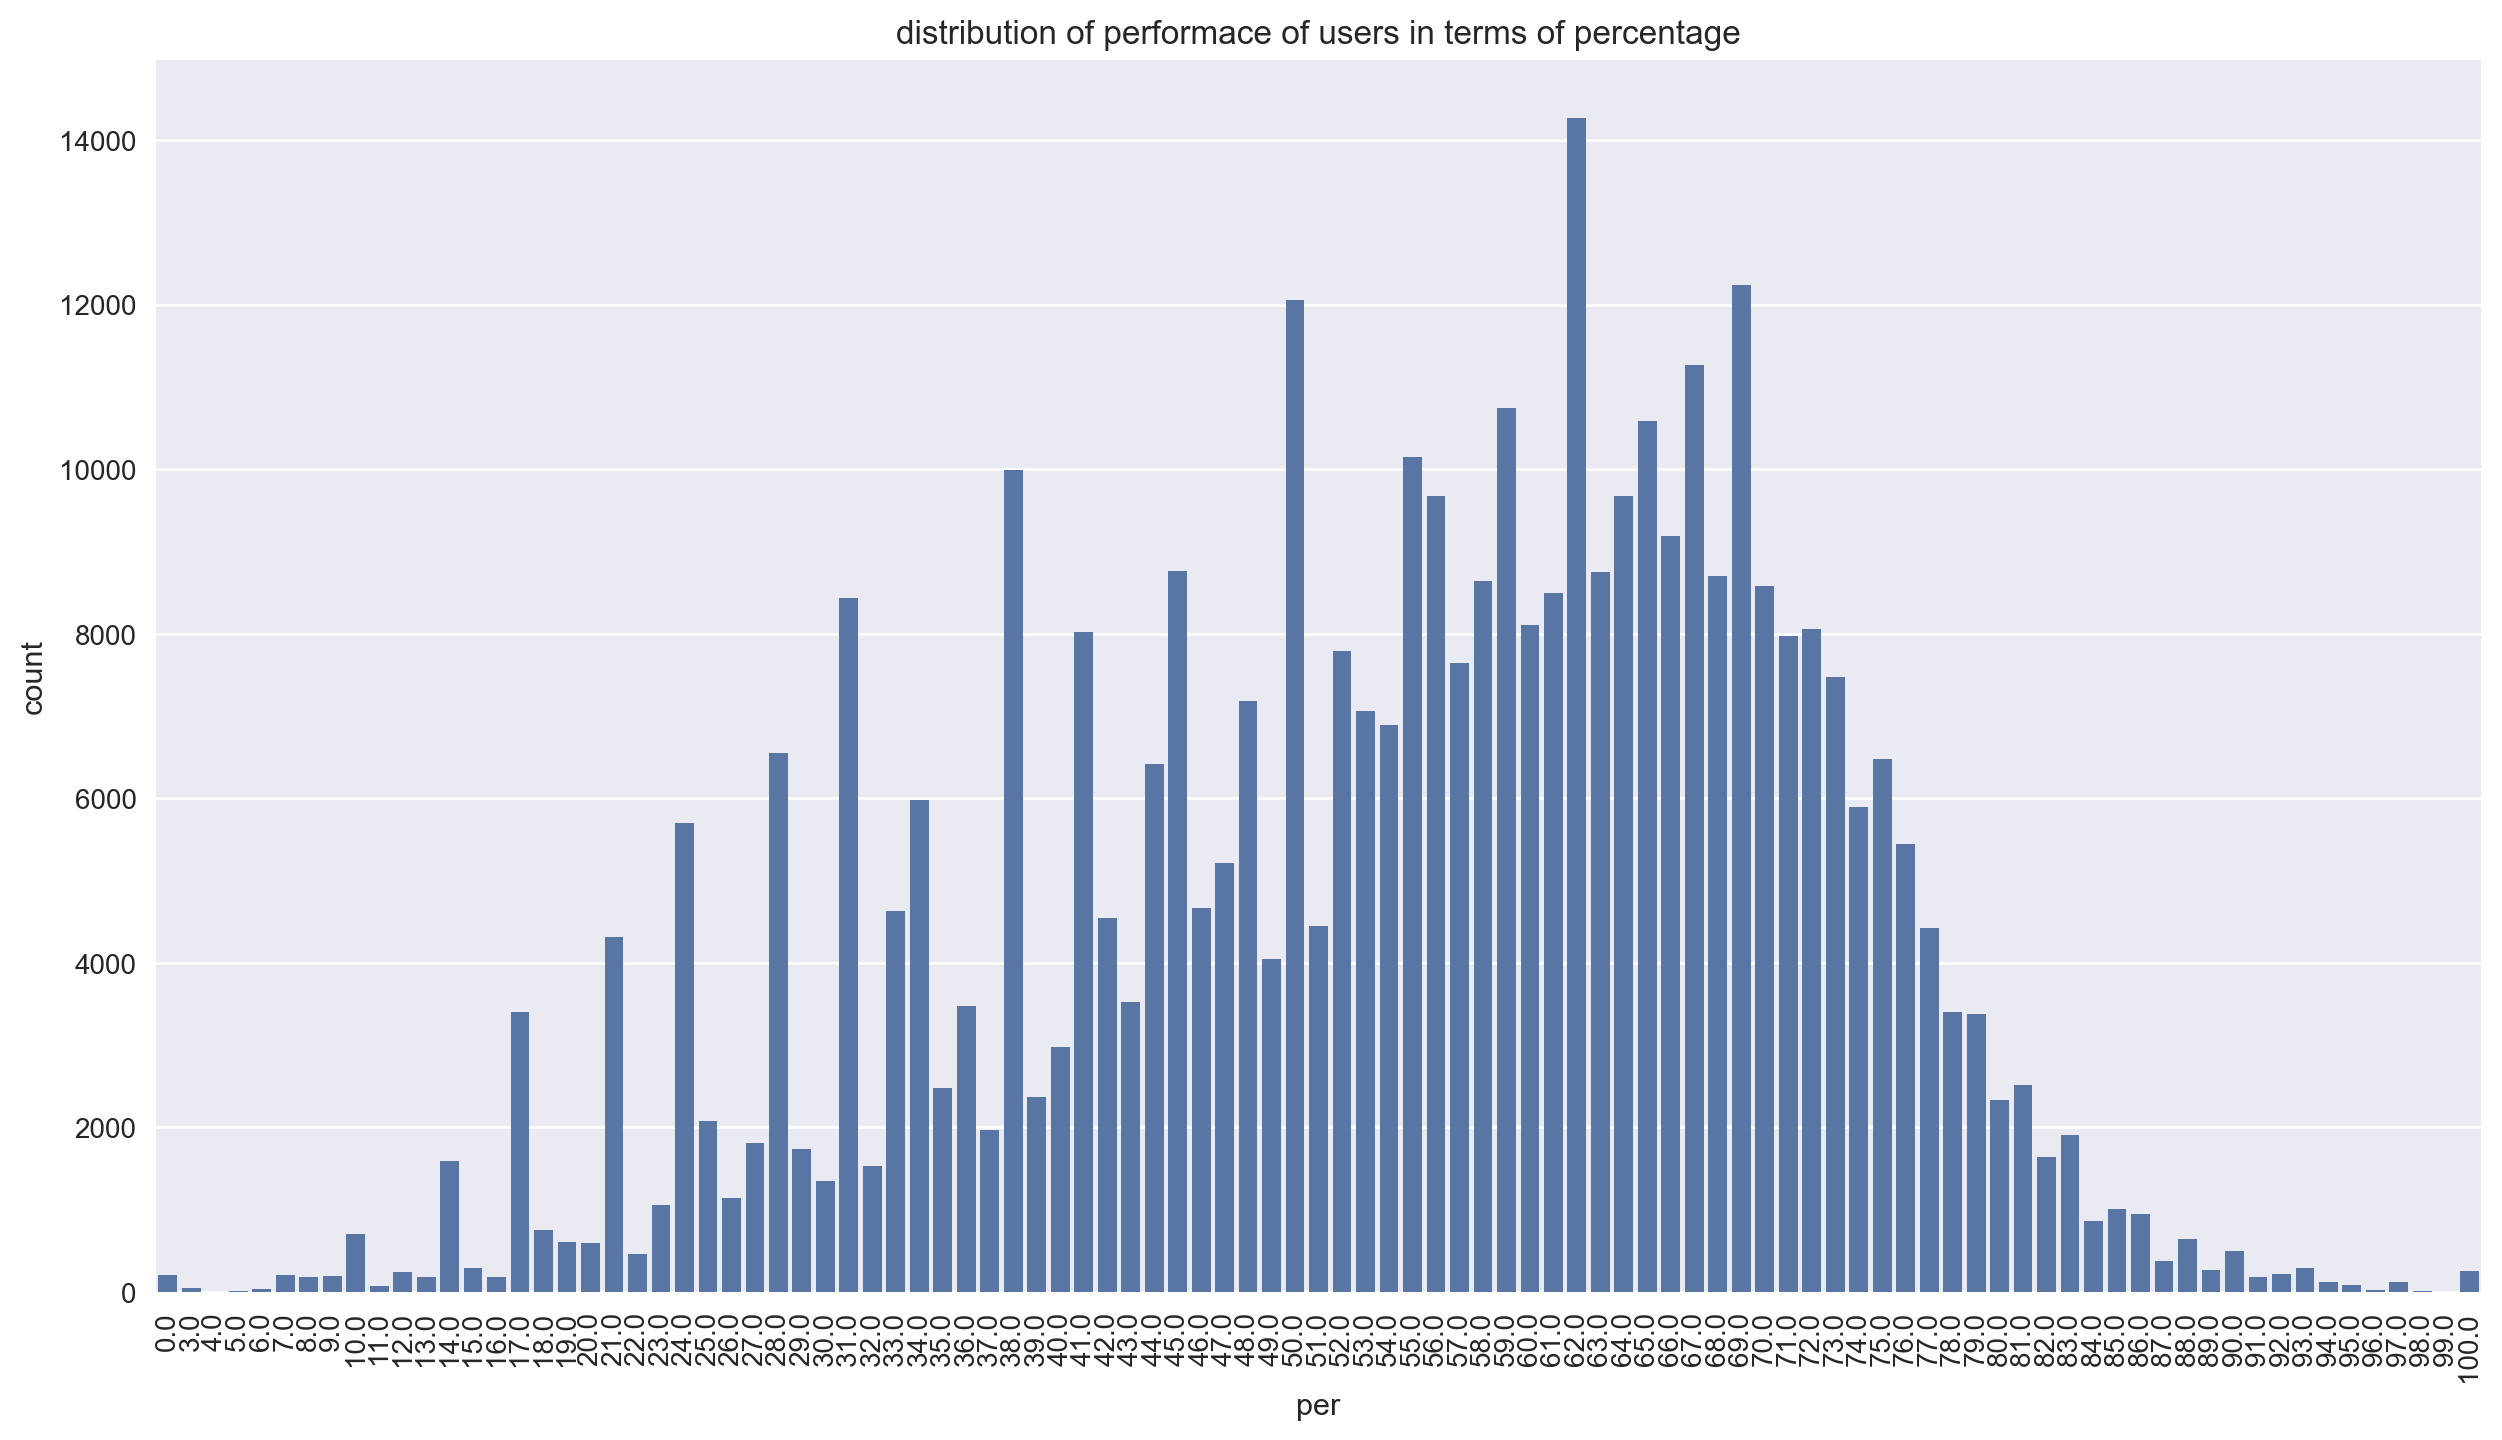

In [45]:
plt.figure(figsize=(15,8))
plt.ticklabel_format(style='plain', axis='y')
sns.countplot(x='per',data=g,order=g['per'].value_counts().sort_index().index)
plt.title('distribution of performace of users in terms of percentage')
plt.xticks(rotation=90)
plt.show()

По сути мы получили гистограмму, причем распределение довольно близко к нормальному. Проверим это:

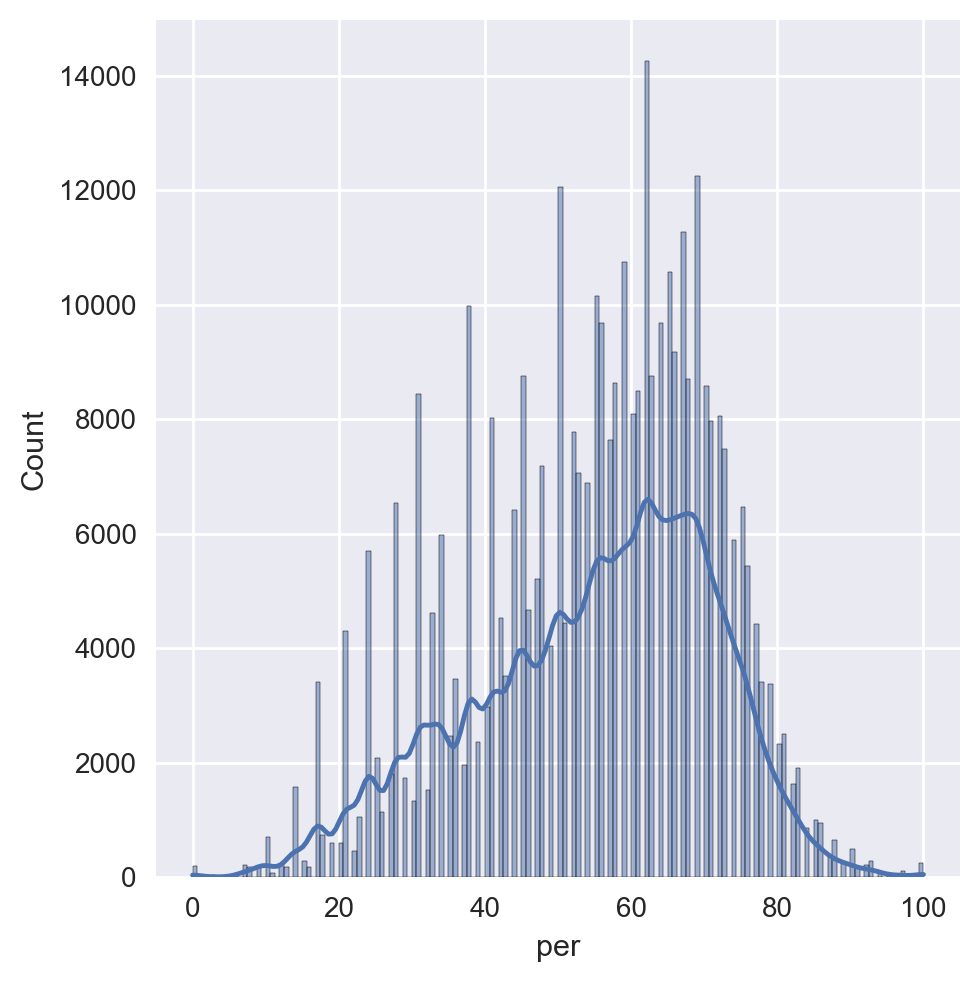

In [50]:
sns.displot(data=g, x="per", kde=True)

**Выводы:**
- чаще всего пользователи достигали 62% успеха при ответах на вопросы
- распределние количества студентов по процентам успеха в ответах на вопросы довольно близко к нормальному

# Общие выводы:
- были исследованы представленные наборы данных в виде 3 таблиц
- таблицы объединены
- удалены пропуски
- данные признаков `prior_question_elapsed_time` и `prior_question_had_explanation` были смещены "вверх" для соответствия этих данных вопросам
- была составлена таблица корреляции признаков и сделаны выводы
- исследованы основные признаки
- исследованы некоторые признаки в разрезе других признаков
- к сожалению, анализ данных поверхностный - просто не хватило времени для более качественного анализа